# Data Mining Final Project 2019 - 2020
## Authors: David Silva (r2016730) and Susana Paço (m20190821)

# 1) Introduction

The client, an insurance company, wishes to better understand the scope of its clients, in order to better serve them and increase their ROI (Return On Investment).
The group was given an ABT (Analytic Based Table), consisting of 10.290 customers and given the task of analyzing the table for evident groups of clusters, extracting the behaviour of said clusters and provide insights on how to better serve them. 

The project is contained within a github repository which can be accessed through the following link: https://github.com/theinsilicobiology/DataMiningFinalProject.
This repository provides a jupyter notebook with all the relevant analysis and a report that summarizes the work done. These two documents should be used together as they complement each other.

## 1.1: Setup Environment
Before running this notebook, the user needs to configure a separate conda environment in order to reproduce the results obtained. An environment.yml file is provided in the project repository with this objective. By creating a conda environment through the yml file, the user will be able to run the whole project without issues. Besides, the user also need to install an additional package from a personal github repository since it is not available in pypi nor in conda repositories.

In order to create the environment the user needs to run the following commands in the anaconda prompt: **conda env create -f \<path to environment.yml>**. Afterwards, the user needs to activate the created environment: **conda activate datamin** and initialize the jupyter notebook: **jupyter notebook**.

The final step is to install the sompy package from the personal github repository, which can be done by running the cell below.

In [ ]:
import sys
# This sompy version defines a random seed for the random initialization, which allows reproducibility
!{sys.executable} -m pip install git+https://github.com/DavidSilva98/SOMPY 

## 1.2: Importing Packages

In [1]:
# Required imports for the project
# test change Nastya
import sqlite3
import re
import random
import numpy as np
import pandas as pd
import scipy.stats as stats #chi2 distribution
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib.cm as cm
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.impute as imp
import sklearn.covariance as cov #Elliptic Envelop
import sklearn.neighbors as neighb #LOF
import sklearn.decomposition as decomp #PCA
import statsmodels.api as statsm #QQ plot
from sompy.sompy import SOMFactory # SOM
from sompy.visualization.mapview import View2D
# HIERARCHICAL, KMEANS
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
# GMM
from sklearn.mixture import GaussianMixture
# K-PROTOTYPES
from kmodes.kprototypes import KPrototypes
# CORRESPONDENCE ANALYSIS
from numpy.linalg import svd
from scipy.spatial import distance_matrix
from scipy.stats import chi2
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

C:\Users\davids\Anaconda3\envs\datamin\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
plt.set_loglevel("warning")

# 2) Importing and Assessing Data

In [3]:
#setup connection to the database
#mypath=".\\data\\insurance.db"
mypath="Data/insurance.db" #mac

conn=sqlite3.connect(mypath)
cursor=conn.cursor()

In [4]:
#Get information about tables from db
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
tables=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])

table_variables=[]
for i in tables.iloc[:,0]:
    table_variables.append([j.group().replace("\"", '') for j in re.finditer('\".*\"',i)])

table_variables

[['LOB',
  'index',
  'Customer Identity',
  'Premiums in LOB: Motor',
  'Premiums in LOB: Household',
  'Premiums in LOB: Health',
  'Premiums in LOB:  Life',
  'Premiums in LOB: Work Compensations'],
 ['Engage',
  'index',
  'Customer Identity',
  'First Policy´s Year',
  'Brithday Year',
  'Educational Degree',
  'Gross Monthly Salary',
  'Geographic Living Area',
  'Has Children (Y=1)',
  'Customer Monetary Value',
  'Claims Rate']]

In [5]:
#Build Analytical Base Table (ABT)
abtquery="""SELECT e.'Customer Identity', e.'First Policy´s Year', e.'Brithday Year', e.'Educational Degree', 
            e.'Gross Monthly Salary', e.'Geographic Living Area', e.'Has Children (Y=1)', e.'Customer Monetary Value', 
            e.'Claims Rate', l.'Premiums in LOB: Motor', l.'Premiums in LOB: Household', l.'Premiums in LOB: Health', 
            l.'Premiums in LOB:  Life', l.'Premiums in LOB: Work Compensations'
            FROM LOB l, Engage e
            WHERE l.'Customer Identity'=e.'Customer Identity'"""
cursor.execute(abtquery)

#Variables alias
alias=["id","first_policy","birthday","education","salary","area","children","cmv","claims_r","motor","household","health","life","work_comp"]

df=pd.DataFrame(cursor.fetchall(), columns=alias)
conn.close()
df.head()

id  first_policy  birthday        education  salary  area  children  \
0   1        1985.0    1982.0  2 - High School  2177.0   1.0       1.0   
1   2        1981.0    1995.0  2 - High School   677.0   4.0       1.0   
2   3        1991.0    1970.0        1 - Basic  2277.0   3.0       0.0   
3   4        1990.0    1981.0      3 - BSc/MSc  1099.0   4.0       1.0   
4   5        1986.0    1973.0      3 - BSc/MSc  1763.0   4.0       1.0   

      cmv  claims_r   motor  household  health    life  work_comp  
0  380.97      0.39  375.85      79.45  146.36   47.01      16.89  
1 -131.13      1.12   77.46     416.20  116.69  194.48     106.13  
2  504.67      0.28  206.15     224.50  124.58   86.35      99.02  
3  -16.99      0.99  182.48      43.35  311.17   35.34      28.34  
4   35.23      0.90  338.62      47.80  182.59   18.78      41.45

In [6]:
#Dimension of the dataset
df.shape

(10296, 14)

In [7]:
#Data types of the variables
df.dtypes

id                int64
first_policy    float64
birthday        float64
education        object
salary          float64
area            float64
children        float64
cmv             float64
claims_r        float64
motor           float64
household       float64
health          float64
life            float64
work_comp       float64
dtype: object

In [8]:
#Check if first_policy, birthday and salary are integers
for i in [df.first_policy.fillna(0), df.birthday.fillna(0), df.salary.fillna(0)]: #control for nans
    print(all(i.apply(lambda x: x.is_integer())))#will return True if all values of each series is an integer

True
True
True


In [9]:
#Correcting some data types
#"first_policy":int, "birthday":int, "salary":int, can't be converted due to NAs
df=df.astype({"area": object, "children": object})

In [10]:
#Get summary statistics from df
df.iloc[:,1:].describe(include='all')

first_policy      birthday    education        salary     area  \
count   10266.000000  10279.000000        10279  10260.000000  10295.0   
unique           NaN           NaN            4           NaN      4.0   
top              NaN           NaN  3 - BSc/MSc           NaN      4.0   
freq             NaN           NaN         4799           NaN   4145.0   
mean     1991.062634   1968.007783          NaN   2506.667057      NaN   
std       511.267913     19.709476          NaN   1157.449634      NaN   
min      1974.000000   1028.000000          NaN    333.000000      NaN   
25%      1980.000000   1953.000000          NaN   1706.000000      NaN   
50%      1986.000000   1968.000000          NaN   2501.500000      NaN   
75%      1992.000000   1983.000000          NaN   3290.250000      NaN   
max     53784.000000   2001.000000          NaN  55215.000000      NaN   

        children            cmv      claims_r         motor     household  \
count    10275.0   10296.000000  10296.000000  10262.000000  10296.000000   
unique       2.0            NaN           NaN           NaN           NaN   
top          1.0            NaN           NaN           NaN           NaN   
freq      7262.0            NaN           NaN           NaN           NaN   
mean         NaN     177.892605      0.742772    300.470252    210.431192   
std          NaN    1945.811505      2.916964    211.914997    352.595984   
min          NaN -165680.420000      0.000000     -4.110000    -75.000000   
25%          NaN      -9.440000      0.390000    190.590000     49.450000   
50%          NaN     186.870000      0.720000    298.610000    132.800000   
75%          NaN     399.777500      0.980000    408.300000    290.050000   
max          NaN   11875.890000    256.200000  11604.420000  25048.800000   

              health          life     work_comp  
count   10253.000000  10192.000000  10210.000000  
unique           NaN           NaN           NaN  
top              NaN           NaN           NaN  
freq             NaN           NaN           NaN  
mean      171.580833     41.855782     41.277514  
std       296.405976     47.480632     51.513572  
min        -2.110000     -7.000000    -12.000000  
25%       111.800000      9.890000     10.670000  
50%       162.810000     25.560000     25.670000  
75%       219.820000     57.790000     56.790000  
max     28272.000000    398.300000   1988.700000

In [11]:
#More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
id              10296 non-null int64
first_policy    10266 non-null float64
birthday        10279 non-null float64
education       10279 non-null object
salary          10260 non-null float64
area            10295 non-null object
children        10275 non-null object
cmv             10296 non-null float64
claims_r        10296 non-null float64
motor           10262 non-null float64
household       10296 non-null float64
health          10253 non-null float64
life            10192 non-null float64
work_comp       10210 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [12]:
#Check duplicates
any(df.duplicated())

False

In [13]:
#Number of missing values in each feature
df.isna().sum()

id                0
first_policy     30
birthday         17
education        17
salary           36
area              1
children         21
cmv               0
claims_r          0
motor            34
household         0
health           43
life            104
work_comp        86
dtype: int64

In [14]:
#Frequencies of number of missing values across rows
df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

In [15]:
#Define metric and non-metric datasets
metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

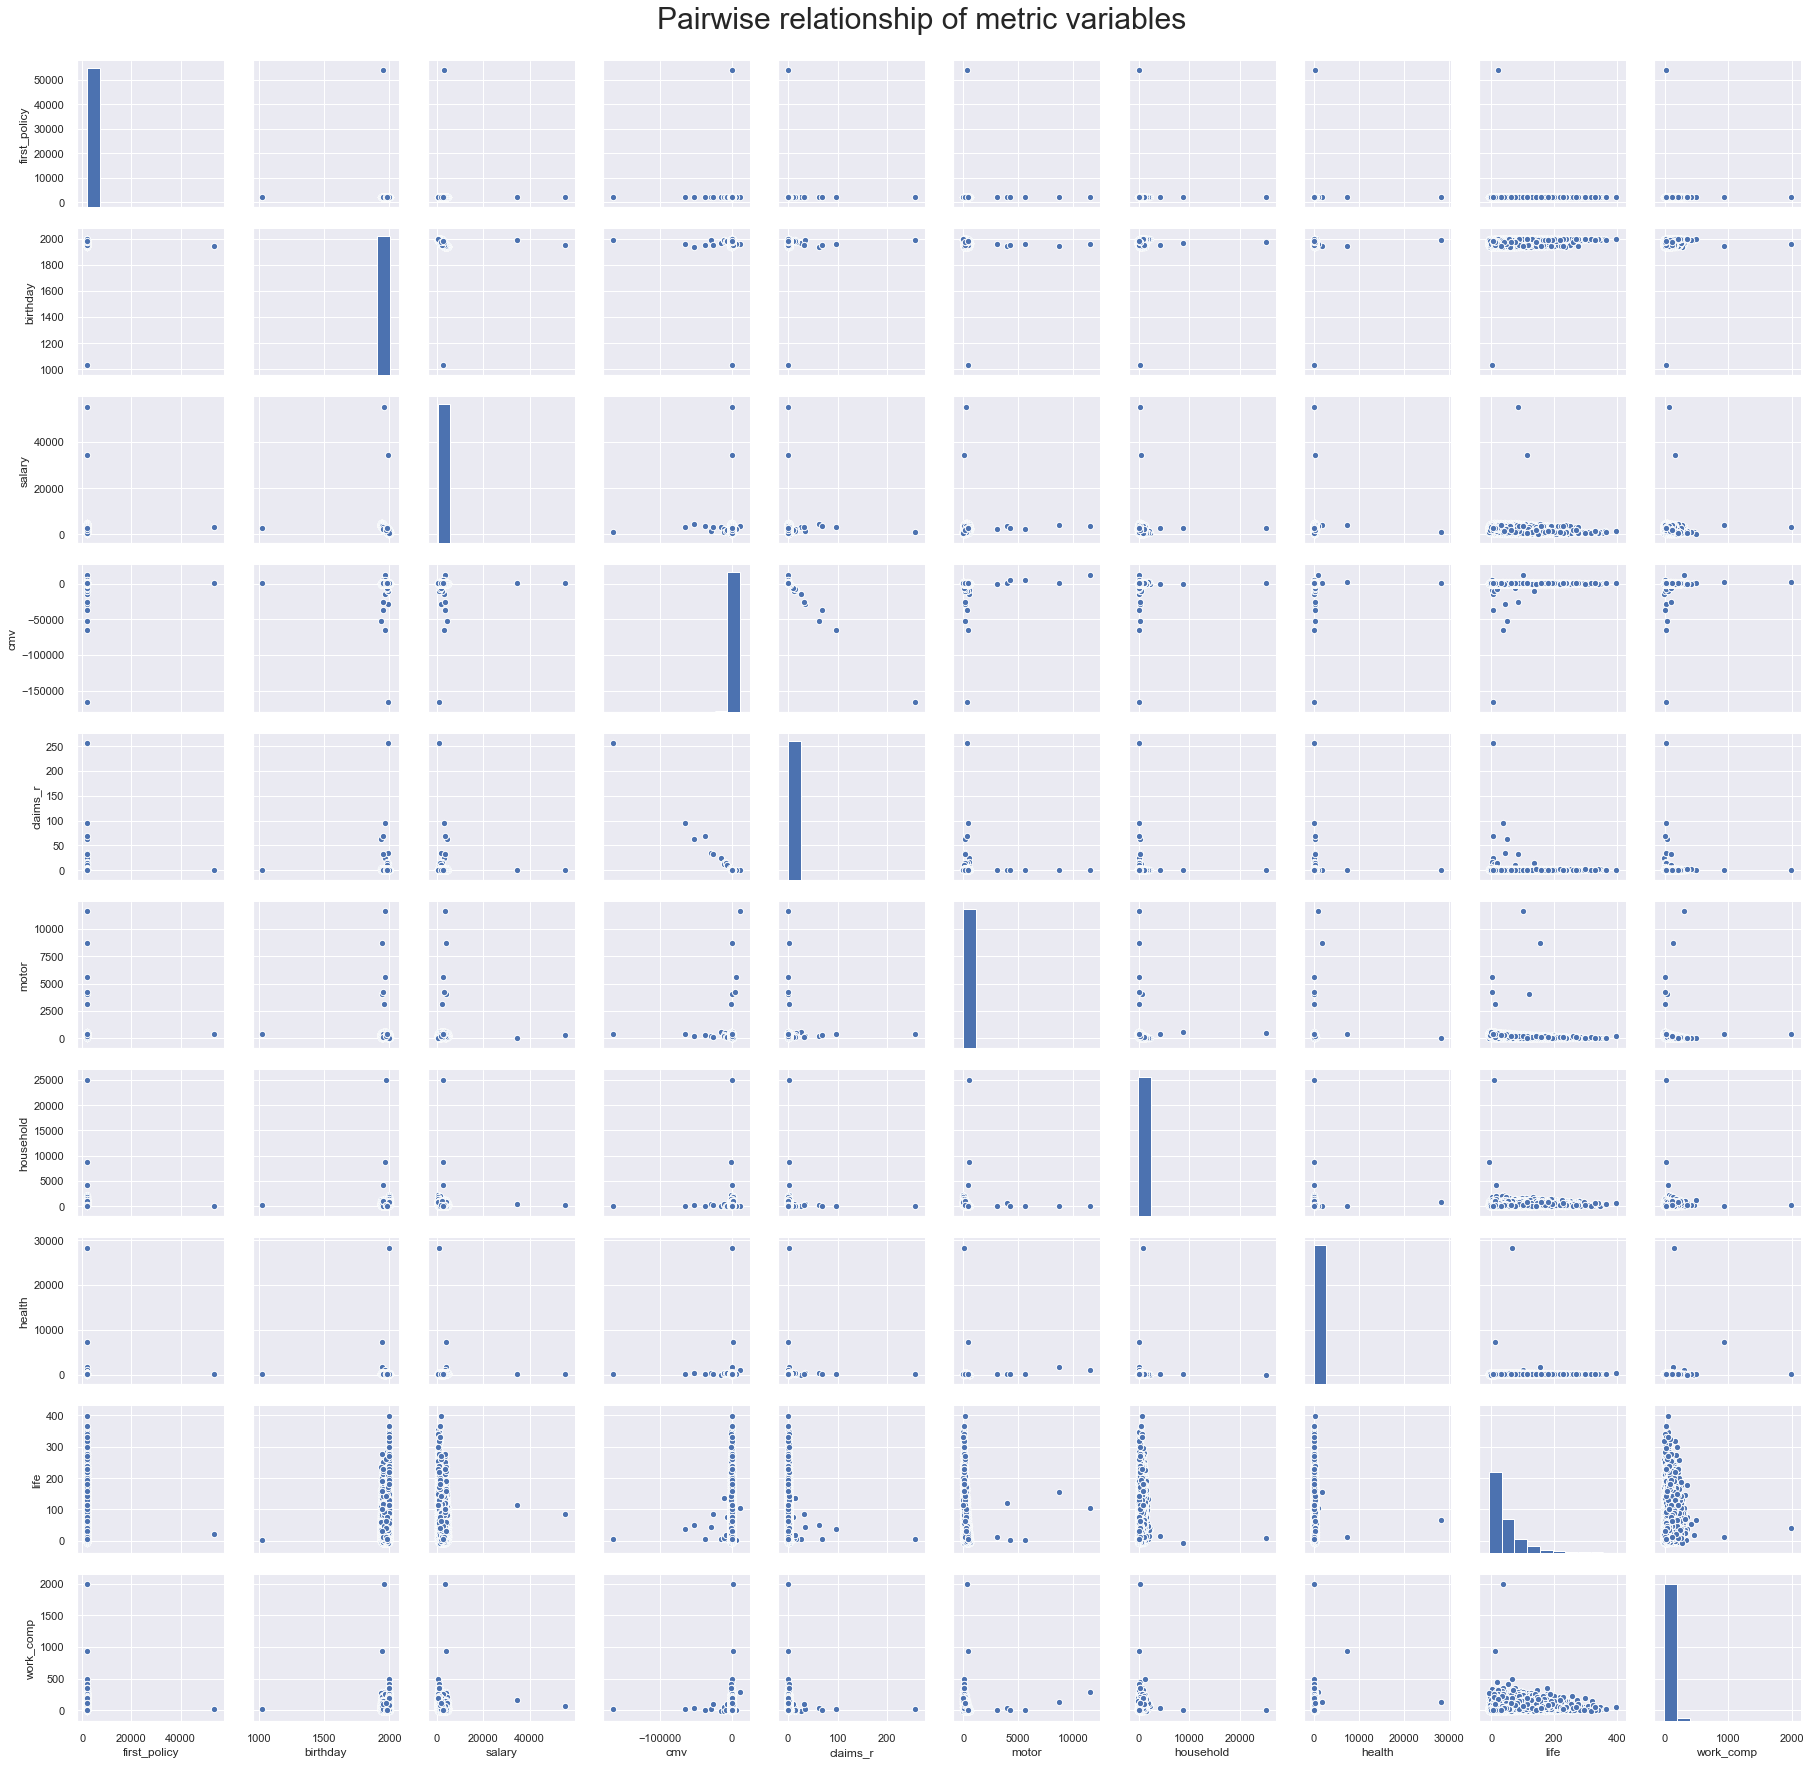

In [16]:
sns.set()

# Setting pairgrid
g = sns.PairGrid(metric_df.drop("id",1).dropna())

# Populating pairgrid
mdg = g.map_diag(plt.hist, edgecolor="w")
mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
    
# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of metric variables", fontsize=30)

plt.show()

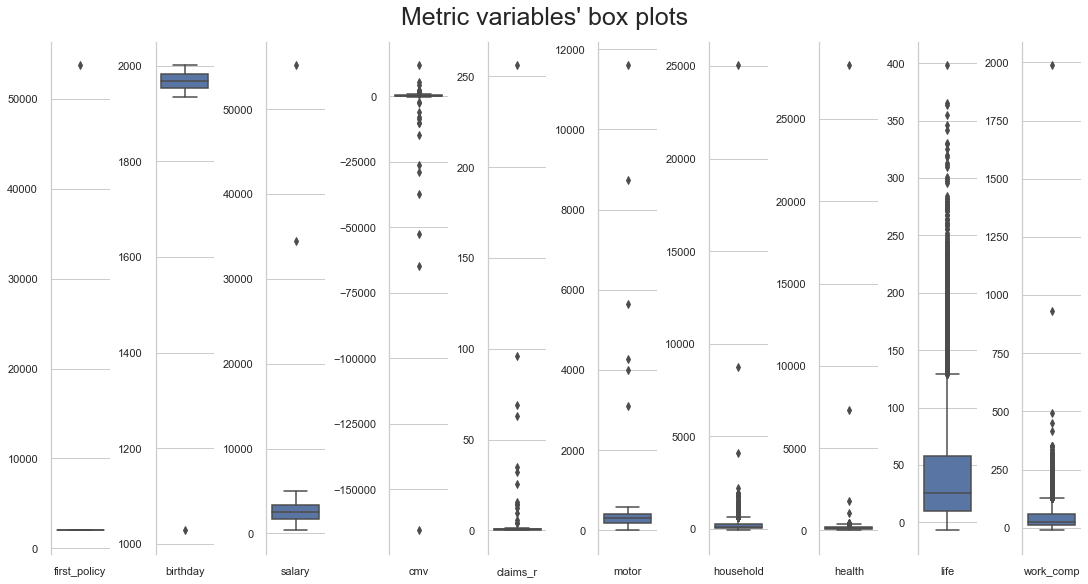

In [17]:
sns.set(style="whitegrid")

# Prepare dataframe layout
data = metric_df.melt("id")
plot_features = metric_df.drop("id",1).columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0])
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

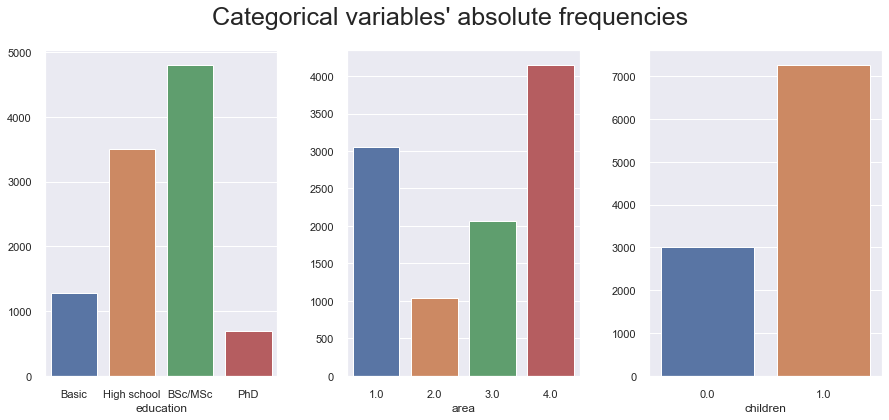

In [18]:
sns.set()

# figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

# plot data
sns.countplot(x="education", data=non_metric_df, order=["1 - Basic", "2 - High School", "3 - BSc/MSc", "4 - PhD"], ax=ax1)
sns.countplot(x="area", data=non_metric_df, ax=ax2)
sns.countplot(x="children", data=non_metric_df, ax=ax3)

# layout
ax1.set_xticklabels(["Basic", "High school", "BSc/MSc", "PhD"])
ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")

plt.subplots_adjust(wspace=0.3)
plt.suptitle("Categorical variables' absolute frequencies", fontsize=25)

plt.show()

NumExpr defaulting to 4 threads.


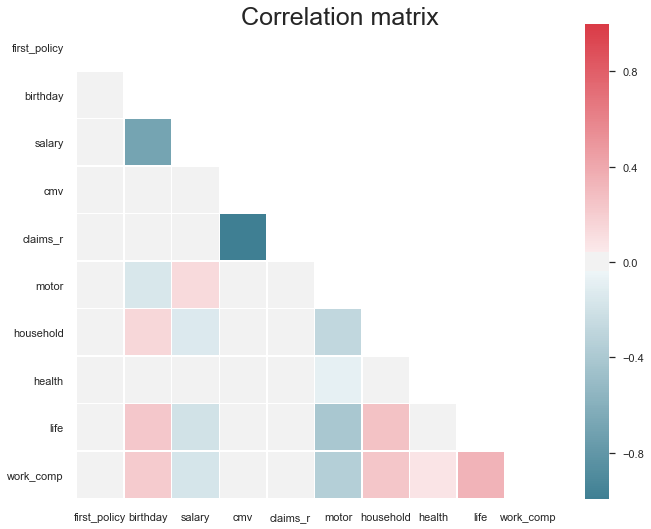

In [19]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric_df.drop("id",1).corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

# 3) Data cleaning

## 3.1: Coherence Checks
This section is necessary to make sure the data makes logical sense. Below it's possible to see what were the logical rules that we looked to verify and confirm:
* the first policy year cannot be before the person was born;
* minors cannot have children and salary.

In [20]:
df.loc[df.first_policy<df.birthday]

id  first_policy  birthday        education  salary area children  \
1          2        1981.0    1995.0  2 - High School   677.0    4        1   
13        14        1983.0    2000.0        1 - Basic  1043.0    3        1   
18        19        1981.0    1982.0        1 - Basic  1414.0    3        1   
22        23        1976.0    1986.0  2 - High School  1495.0    1        1   
40        41        1994.0    1995.0  2 - High School  1177.0    4        1   
...      ...           ...       ...              ...     ...  ...      ...   
10268  10269        1987.0    1988.0      3 - BSc/MSc  1414.0    3        1   
10273  10274        1989.0    1992.0  2 - High School  1035.0    1        1   
10284  10285        1980.0    1987.0      3 - BSc/MSc  1504.0    4        1   
10288  10289        1982.0    1993.0  2 - High School  1465.0    1        1   
10290  10291        1994.0    1999.0        1 - Basic   626.0    3        1   

          cmv  claims_r   motor  household  health    life  work_comp  
1     -131.13      1.12   77.46     416.20  116.69  194.48     106.13  
13     -75.12      1.06   44.34     342.85  127.69  267.94      94.46  
18     230.38      0.71  313.17     373.40  121.80   14.78      72.57  
22     -89.79      1.08  209.04     308.95  192.48   64.79      54.90  
40     121.36      0.84   52.01     455.65  135.47  146.36     148.03  
...       ...       ...     ...        ...     ...     ...        ...  
10268   50.46      0.90  129.58     167.80  184.48  165.92      75.46  
10273  293.51      0.58  235.71     195.60  103.13  170.92      58.12  
10284   -1.55      0.96  390.63      29.45  179.70   -6.00        NaN  
10288  795.15      0.35   67.79     820.15  102.13  182.48      86.46  
10290  176.26      0.85    6.89     878.50  103.13  113.02     201.26  

[1997 rows x 14 columns]

It is possible to see above that some of our clients had their first_policy before they were even born.

In [21]:
df.loc[(df["birthday"]>1998) & (df["children"]==1)]

id  first_policy  birthday  education  salary area children     cmv  \
13        14        1983.0    2000.0  1 - Basic  1043.0    3        1  -75.12   
186      187        1993.0    1999.0  1 - Basic  1247.0    2        1 -128.24   
397      398        1986.0    2000.0  1 - Basic   415.0    1        1 -218.48   
480      481        1984.0    1999.0  1 - Basic  1581.0    4        1  866.27   
526      527        1982.0    1999.0  1 - Basic   840.0    4        1  -23.54   
...      ...           ...       ...        ...     ...  ...      ...     ...   
9936    9937        1989.0    1999.0  1 - Basic   918.0    3        1  738.24   
9947    9948        1987.0    2000.0  1 - Basic   422.0    1        1 -145.58   
10043  10044        1983.0    1999.0  1 - Basic  1110.0    1        1  907.28   
10121  10122        1978.0    1999.0  1 - Basic   738.0    4        1  365.19   
10290  10291        1994.0    1999.0  1 - Basic   626.0    3        1  176.26   

       claims_r   motor  household  health    life  work_comp  
13         1.06   44.34     342.85  127.69  267.94      94.46  
186        1.07   33.23    1026.30   82.57   75.68     212.15  
397        1.22   52.01     348.40   49.01  193.48     225.82  
480        0.21   30.34     683.45   98.13   71.68     249.16  
526        1.00  132.69     165.60  137.36  129.69     164.14  
...         ...     ...        ...     ...     ...        ...  
9936       0.20   29.45     457.85  117.69  275.94      78.35  
9947       1.07   36.23    1409.15   66.68   14.78     171.59  
10043      0.34   25.56    1011.85  120.80  144.25     105.13  
10121      0.53   57.12     293.95  100.02  276.83      96.24  
10290      0.85    6.89     878.50  103.13  113.02     201.26  

[87 rows x 14 columns]

It is possible to see above that some of our clients are minors and have children.

In [22]:
df.loc[df["birthday"]>1998]

id  first_policy  birthday  education  salary area children     cmv  \
13        14        1983.0    2000.0  1 - Basic  1043.0    3        1  -75.12   
186      187        1993.0    1999.0  1 - Basic  1247.0    2        1 -128.24   
397      398        1986.0    2000.0  1 - Basic   415.0    1        1 -218.48   
480      481        1984.0    1999.0  1 - Basic  1581.0    4        1  866.27   
526      527        1982.0    1999.0  1 - Basic   840.0    4        1  -23.54   
...      ...           ...       ...        ...     ...  ...      ...     ...   
9936    9937        1989.0    1999.0  1 - Basic   918.0    3        1  738.24   
9947    9948        1987.0    2000.0  1 - Basic   422.0    1        1 -145.58   
10043  10044        1983.0    1999.0  1 - Basic  1110.0    1        1  907.28   
10121  10122        1978.0    1999.0  1 - Basic   738.0    4        1  365.19   
10290  10291        1994.0    1999.0  1 - Basic   626.0    3        1  176.26   

       claims_r   motor  household  health    life  work_comp  
13         1.06   44.34     342.85  127.69  267.94      94.46  
186        1.07   33.23    1026.30   82.57   75.68     212.15  
397        1.22   52.01     348.40   49.01  193.48     225.82  
480        0.21   30.34     683.45   98.13   71.68     249.16  
526        1.00  132.69     165.60  137.36  129.69     164.14  
...         ...     ...        ...     ...     ...        ...  
9936       0.20   29.45     457.85  117.69  275.94      78.35  
9947       1.07   36.23    1409.15   66.68   14.78     171.59  
10043      0.34   25.56    1011.85  120.80  144.25     105.13  
10121      0.53   57.12     293.95  100.02  276.83      96.24  
10290      0.85    6.89     878.50  103.13  113.02     201.26  

[116 rows x 14 columns]

We can even see that clients born after 1998 are receviving salary. Furthermore, it is also possible to observe from the above tables that minors have insurance policies for household, cars, health, life and so on, which doesn't make a lot of sense either.

Given all this incoherencies caused by the birhtday variable and the feedback from our client that this variable contains some errors, we decided to drop this variable.

In [23]:
df = df.drop("birthday", axis=1)

## 3.2: Outliers

We will divide the outlier dection procedure into **parametric** and **non-parametric** approaches. We will use methods such as the interquantile range, standard deviation, mahalanobis distance (chi-square plots) and local outlier factor (LOF). In order to apply some of the methods proposed we will need to map our variables to a **normal distribution**.

The end goal of this analysis is to end up with an outlier identificator column for each method and then decide which observations to exclude based on these.

### 3.2.1 - Unreasonable Values

From the boxplots and scatter plots above we can visualize the presence of observations with values that are logically invalid and should be eliminated:
* first_policy values above 50000 (we are in 2019);

In [24]:
df = df.loc[(df["first_policy"]!=53784.0)] # we have to select the exact value otherwise we will eliminate nans

#Define metric and non-metric datasets
metric_df = df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df = df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]
data = metric_df.set_index("id")
data.fillna(data.median(), inplace=True) #dealing with nans by replacing them for the median (this is not the final imputation)

### 3.2.2 - Univariate Normal Distribution

There are three common approaches to make data more Gaussian-like:
* Box-Cox;
* Yeo-Johnson;
* Quantile transformations;

However, Box-Cox requires input data to be strictly positive, for that reason we will apply all the transformations whenever possible, and then compare the normality fit through the use of QQ-plots.

In [25]:
mask = data.apply(lambda x: np.any(x<=0), axis=0)
labels = mask.index[mask==False].to_list() #getting stricly positive columns for BoxCox transformation

# Transformations
rng = np.random.RandomState(304)
bc = prep.PowerTransformer(method='box-cox')
yj = prep.PowerTransformer(method='yeo-johnson')
qt = prep.QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=rng)

# Perform power transforms and quantile transform
X_trans_bc = bc.fit_transform(data[labels])
X_trans_yj = yj.fit_transform(data)
X_trans_qt = qt.fit_transform(data)

# Merging
X_trans = np.concatenate((X_trans_bc, X_trans_yj, X_trans_qt), axis=1)

# Creating DataFrame
merge_labels = list(map(lambda x: "bc_" + x, labels))+list(map(lambda x: "yj_" + x, data.columns.to_list()))+list(map(lambda x: "qt_" + x, data.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=data.index)

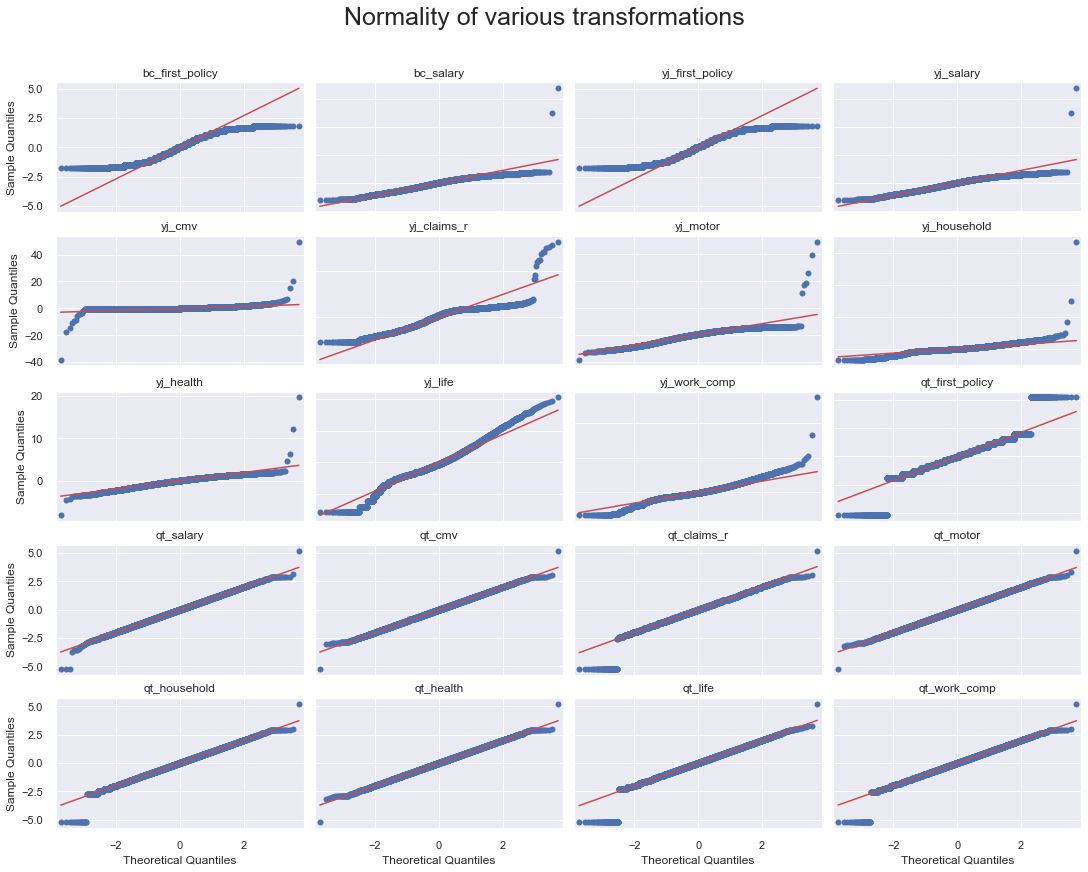

In [26]:
# Plot transformed data
sns.set()
fig, axes = plt.subplots(5,4, constrained_layout=True, figsize=(15,12))

fig.suptitle("Normality of various transformations\n", fontsize=25)

for col, ax in zip(trans_df.columns, axes.flatten()):
    x = trans_df.loc[:,col]
    statsm.qqplot(x, line="q", ax=ax)
    ax.set_title(col)

# Just appear labels on outside axes
for ax in fig.get_axes():
    ax.label_outer()

plt.show()

The fit of the transformation to a Normal Distribution can be seen through the allignment of the points over the red line, which displays the behaviour or the points in case of perfect fit (the sample quantiles match the ones from a Normal distribution). As both the Quantile and Yeo-Johnson transformations provide gaussian-like distributions, we will use both to apply the parametric tests for outlier detection.

### 3.2.3 - Univariate Outliers

In [27]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [28]:
def out_std(data, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = data.mean(), data.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

def out_iqr(data, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

In [29]:
outlier_labels = pd.concat([out_std(transyj_df, 4), out_std(transqt_df, 4), out_iqr(transyj_df, 2.5), out_iqr(transqt_df, 2.5)], axis=1)
outlier_labels.columns = ["outyjstd","outqtstd","outyjiqr","outqtiqr"]

By using the functions out_std and out_iqr we obtain the potential outlier labels according to each transformation.
The value 1 classifies an observation as a potential outlier as long as at least one variable has an abnormal value. 

We define **abnormal values** has the ones outside the 2.5 x Interquantile Range (out_iqr) and the ones more than 4 Standard Deviations away from the mean (out_std). We defined this more unrestrictive criteria since the data already had high variation by nature.

### 3.2.4 - Multivariate Normal Distribution
Even though our Univariate distributions are Normal-like, Multivariate Normality is not guaranteed as the later is a consequence to the former and not otherwise. This might cause some error in the application of techniques that rely on Multivariate Normal distributed data.

In practice however, "pathological data sets that are normal in lower dimensional representations, but nonnormal in higher dimensions, are not frequently encountered" (Johnson and Wichern 2007, pp. 177) which validates our decision to apply this type of techniques in the transformed data.

### 3.2.5 - Multivariate Outliers

In [30]:
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # Obtain mahalanobis distance of each observation to the center and then sort it
    ee_out = cov.EllipticEnvelope(contamination=contamination, random_state=random).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # Obtain chi-square percentiles of each observations
    quantiles = stats.chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # Obtain labels
    labels = ee_out.predict(data)
    
    return mahalan, quantiles, labels

mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)

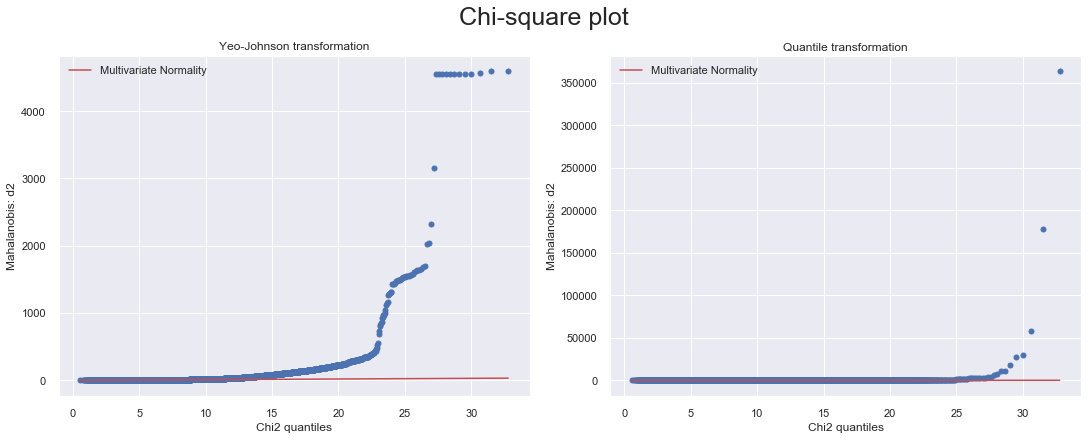

In [31]:
# Get data for the Qui-square plots
param = [[np.sort(mqt), qqt, "Yeo-Johnson transformation"], [np.sort(myj), qyj, "Quantile transformation"]]

sns.set()
# Chi-sq plot
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15,6))
fig.suptitle("Chi-square plot", fontsize=25)

for ax, p in zip(axes.flatten(), param):
    ax.scatter(p[1], p[0], s=25)
    ax.plot(p[1], p[1], "-r", label="Multivariate Normality")
    ax.legend(loc="upper left")
    ax.set_title(p[2])
    ax.set_xlabel("Chi2 quantiles")
    ax.set_ylabel("Mahalanobis: d2")
    
plt.show()

From the above visualization, one can conclude that both the Yeo-Johnson and Quantile tranformations provide a slightly poor fit to a Multivariate Normal Distribution since d2 (that follows a Chi-square distribution in case of Multivariate Normality) doesn't match the Chi-square quantiles, expected in case of Multivariate Normality, i.e. the observations don't lie above the red line. (Johnson and Wichern 2007, pp. 177-192).

Even though our fitted distribution isn't the best, we can still conclude that there are certainly some potential multidimensional outliers since some observations are very distant from the center (high values of d2). For this reason, we will consider the outlier label provided by this method as well as the ones provided directly from the **Elliptic Envelop** method (this method was used to calculate the mahalanobis distance of every observation to the center with respect to a robust estimate of the covariance matrix).

Now we will apply a non-parametric approach that looks at the density in the input space to identify outliers. 

The Local Outlier Factor (LOF) method finds out isolated data points by estimating its density with respect to the surrounding neighborhood. More precisely, the k-nearest neighbors' distance is used to estimate the local density of an observation. By comparing the local density of an observation to the local densities of its neighbors, one can identify observations that have a substantially lower density than their neighbors. These will be classified as outliers.

In [32]:
# Since we will use the original data (non-parametric method) and it isn't standardized we'll first do this since variables have different measurment scales
std_data = prep.StandardScaler().fit_transform(data)
lof = neighb.LocalOutlierFactor(n_neighbors=50, contamination="auto")
outlof = lof.fit_predict(std_data)
lof_scores = lof.fit(std_data).negative_outlier_factor_

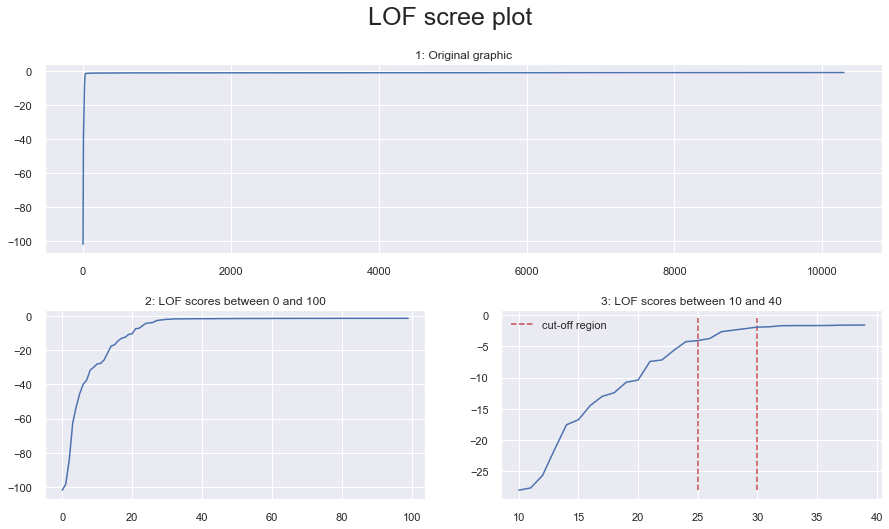

In [33]:
sns.set()
#figure
fig = plt.figure(figsize=(15,8))
fig.suptitle("LOF scree plot", fontsize=25)

#axes
gs = gspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,:]) # First row, first column
ax2 = fig.add_subplot(gs[1,0]) # First row, second column
ax3 = fig.add_subplot(gs[1,1]) # First row, all columns

#data
ax1.plot(np.sort(lof_scores))
ax2.plot(np.sort(lof_scores)[:100])
ax3.plot(np.sort(lof_scores)[10:40], data= np.arange(10, 40, 5))

#layout
ax1.set_title("1: Original graphic")
ax2.set_title("2: LOF scores between 0 and 100")
ax3.set_title("3: LOF scores between 10 and 40")
ax3.set_xticklabels(list(map(str,range(5,45,5)))) #adjust ax3 x axis tick labels
ax3.vlines(x=[15,20], ymin=-28, ymax=-0.5, color="r", linestyles ="dashed", label="cut-off region")
ax3.legend()
plt.subplots_adjust(hspace=0.3)

plt.show()

From the visualization above, it is possible to notice that the LOF score, which gives a measure of the deviation of density of an observation with respect to its neighbors, is normal for the majority of the observations, however there's a group of less than 25/30 observations whose scores is quite different from the rest. 

Therefore we defined a threshold around the 30th observation with the lowest score so that the ones with lower score will be considered as potential outliers.

In [34]:
top_lof_scores = data.index.isin(lof_scores.argsort()[:30]+1)

Since the relative position of the points doesn't change with PCA (we are simply rotating the axes) then we will represent below our observations in a 2 dimensional space given by the 2 most important Principal Components so we can get an idea of where the potential ouliers identified by the LOF method are located.

Around 45% of the total variance is accounted by the 2 Principal Components



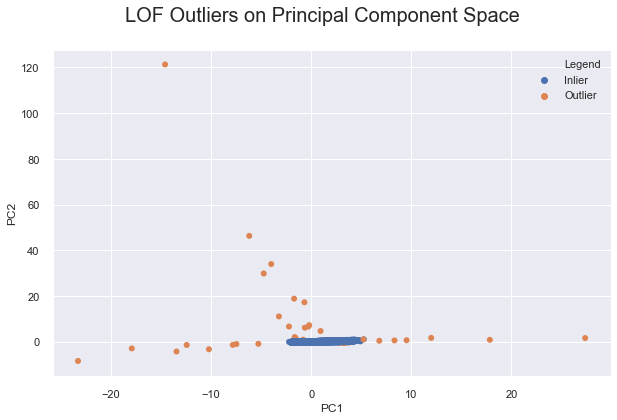

In [35]:
# PCA with standardized data since we are working with different measurment units (i.e. eigenvalue decomposition of the correlation matrix)
pca = decomp.PCA(n_components=2).fit(std_data)
print("Around {}% of the total variance is accounted by the 2 Principal Components\n".format(int(100*pca.explained_variance_ratio_.sum())))
scores = pca.transform(std_data) #representation of observations in the component space

# Visualizing the data and LOF potential outliers in the 3 Principal component space
label = np.where(outlof==-1, "Outlier", "Inlier")
# label = np.where(top_lof_scores==True, "Outlier", "Inlier")
vis2pc = pd.DataFrame(data=np.concatenate((scores, np.resize(label, (10295,1))), axis=1), columns=["PC1","PC2","Legend"])
vis2pc = vis2pc.astype(dict(zip(vis2pc.columns, [np.float64, np.float64, "object"])))

sns.set()
fig = plt.figure(figsize=(10,6))
fig.suptitle("LOF Outliers on Principal Component Space", fontsize=20)
sns.scatterplot(x="PC1", y="PC2", hue="Legend", data=vis2pc, linewidth=0)
plt.show()

It is possible to conclude from the above that the oulier identification provided by the LOF method is quite effective since in the 2 dimensional principal component space all the observations that are "alone" are labeled as potential outliers. 

One should keep in mind that by representing the data in the space we are losing aprroximately 55% of variance and therefore our conclusions are not 100% sure.

In [36]:
outlier_labels = pd.concat([outlier_labels, pd.Series(data=(lyj==-1), index=data.index),
                            pd.Series(data=(lqt==-1), index=data.index),
                            pd.Series(data=data.index.isin(np.argsort(myj)[-100:]), index=data.index),
                            pd.Series(data=data.index.isin(np.argsort(mqt)[-100:]), index=data.index),
                            pd.Series(data=(outlof==-1), index=data.index),
                            pd.Series(data=top_lof_scores, index=data.index)], axis=1)
outlier_labels.columns = ["outyjstd", "outqtstd", "outyjiqr", "outqtiqr", "outyjmhlnb", "outqtmhlnb", "outyjqqplt", "outqtqqplt", "outlof", "outlofscree"]

In [37]:
pd.DataFrame(np.round(outlier_labels.mean(),3), columns=["Proportion of potential outliers for each method:"])

Proportion of potential outliers for each method:
outyjstd                                                 0.005
outqtstd                                                 0.042
outyjiqr                                                 0.024
outqtiqr                                                 0.042
outyjmhlnb                                               0.030
outqtmhlnb                                               0.030
outyjqqplt                                               0.010
outqtqqplt                                               0.010
outlof                                                   0.005
outlofscree                                              0.003

In [38]:
# Align table to left side
from IPython.core.display import HTML
HTML("<style>table {margin-left: 0 !important;}</style>")

We tested some possible hypothesis regarding the exclusion of outliers. In each hypothesis we changed the outlier labels used and the number of flags (i.e. minimum number of outlier flags an observation needs to be considered outlier) required. In return, we obtained different numbers of outliers, and we also analyzed the box plots to see if all the abnormal points were removed. These are the results we obtained:

|   |                       Outlier Labels                      | # Flags | # Outliers | Boxplot quality |
|:-:|:---------------------------------------------------------:|:-------:|:----------:|:---------------:|
| 1 |                        No dropping                        |    >3   |     87     |        5*       |
| 2 |                     outqtstd, outqtiqr                    |    >3   |     48     |        5*       |
| 3 |               outqtstd, outqtiqr, outqtmhlnb              |    >2   |     50     |        5*       |
| 4 |       outqtstd, outqtiqr, outqtmhlnb,<br>outqtqqplt       |    >2   |     48     |        5*       |
| 5 | outqtstd, outqtiqr, outqtmhlnb,<br>outqtqqplt, outyjmhlnb |    >2   |     42     |        3*       |
| 6 |   outqtstd, outqtiqr, outqtmhlnb,<br>outqtqqplt, outlof   |    >2   |     47     |        4*       |
| 7 |                        Just outlof                        |    .    |     49     |        3*       |

In conclusion, we will resort to **configuration 4** since it's the one that is able to provide the best clean up of outliers while preserving the maximum number of observations. Below we will check the results provided by this configuration.

In [39]:
out_mask = outlier_labels.drop(["outqtstd", "outqtiqr", "outqtmhlnb", "outqtqqplt"], axis=1).apply(lambda x: x.sum(), axis=1)>2
out_mask.value_counts()

False    10247
True        48
dtype: int64

### 3.2.6 - Checking Results

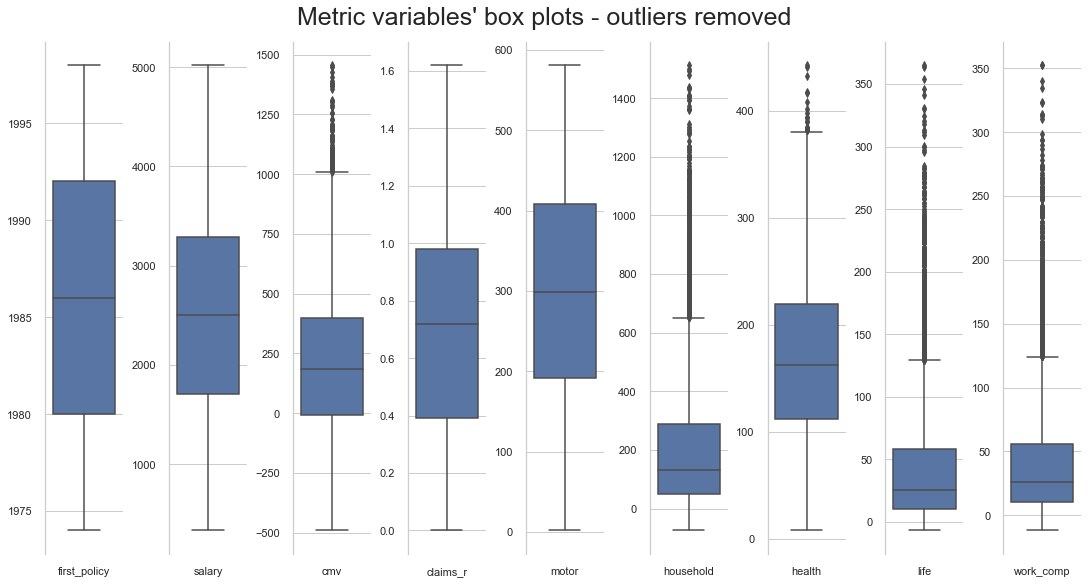

In [40]:
sns.set(style="whitegrid")

# Prepare dataframe layout
plot_data = metric_df.set_index("id")[~out_mask].reset_index().melt("id")
plot_features = data.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=plot_data.loc[plot_data["variable"]==i[1]], ax=i[0])
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots - outliers removed", fontsize=25)
sns.despine(bottom=True)

plt.show()

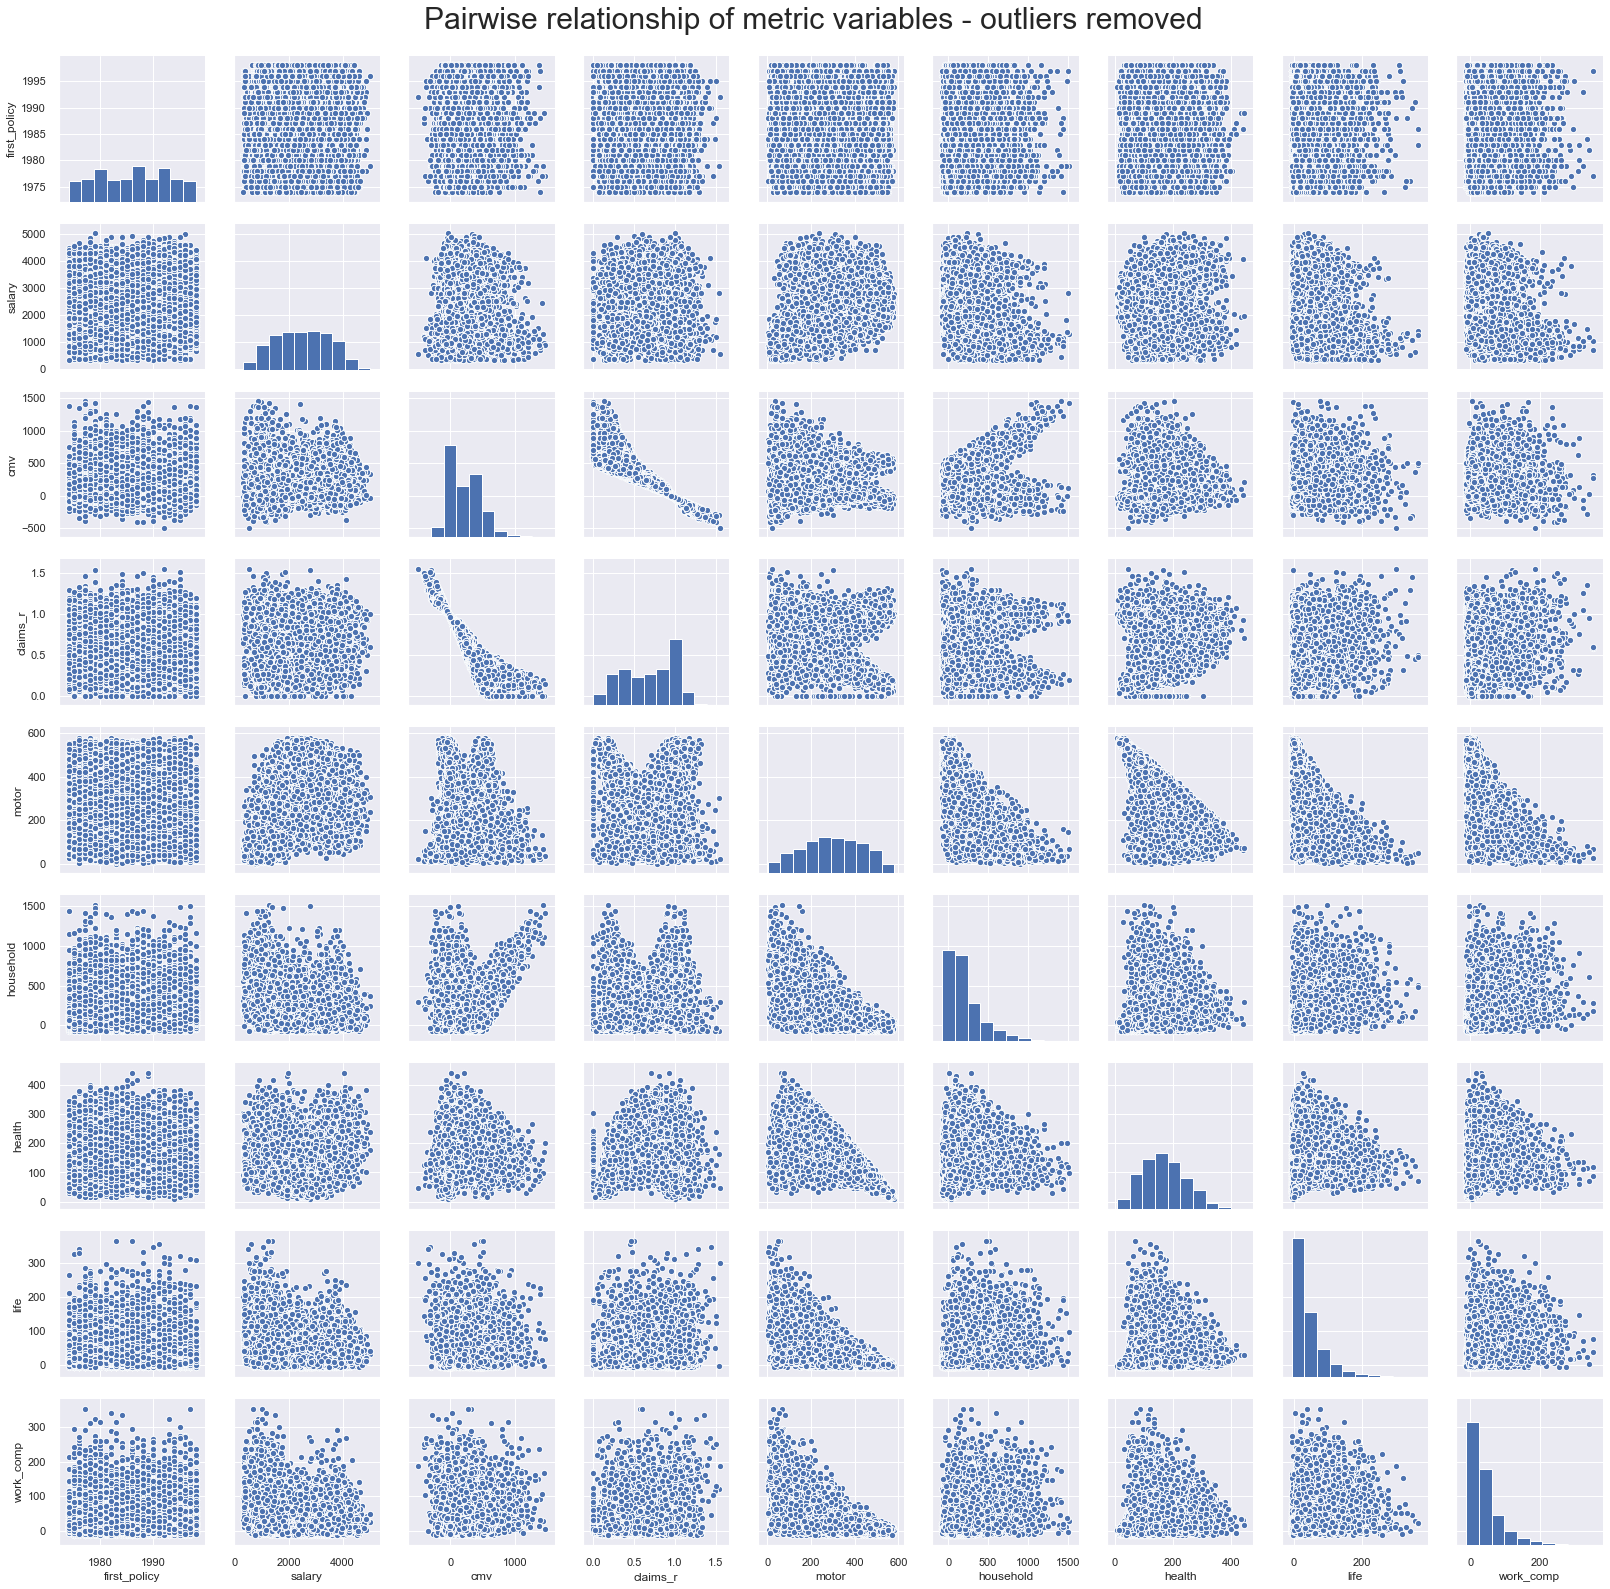

In [41]:
sns.set()

# Setting pairgrid
g = sns.PairGrid(metric_df.set_index("id")[~out_mask].dropna())

# Populating pairgrid
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of metric variables - outliers removed", fontsize=30)

plt.show()

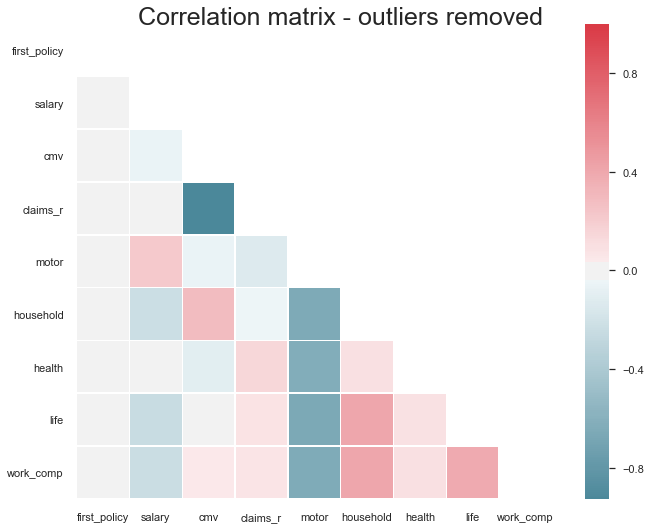

In [42]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric_df.set_index("id")[~out_mask].corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix - outliers removed", fontsize=25)
plt.yticks(rotation=0)

# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [43]:
df.set_index("id", inplace=True)
df_out = df[out_mask] # We will also keep the outlier observations so that we can classify them later in the clusters
df = df[~out_mask] # No reset_index because we want to keep track of customer id

As it's possible to observe from the visualizations above, the presence of outliers had a clear negative effect on the quality of the data. Both the pairwise relationship and box plot graphics provide a more clear representation of the data now that the outliers were removed. Furthermore, the correlations are more meaningful and already unveil some of the patterns in the behaviour of the customers. 

## 3.3: Missing Values

In this section we will deal with the missing values present in the dataset. We will perform the imputation of the outliers using the K-nearest neighbors method.

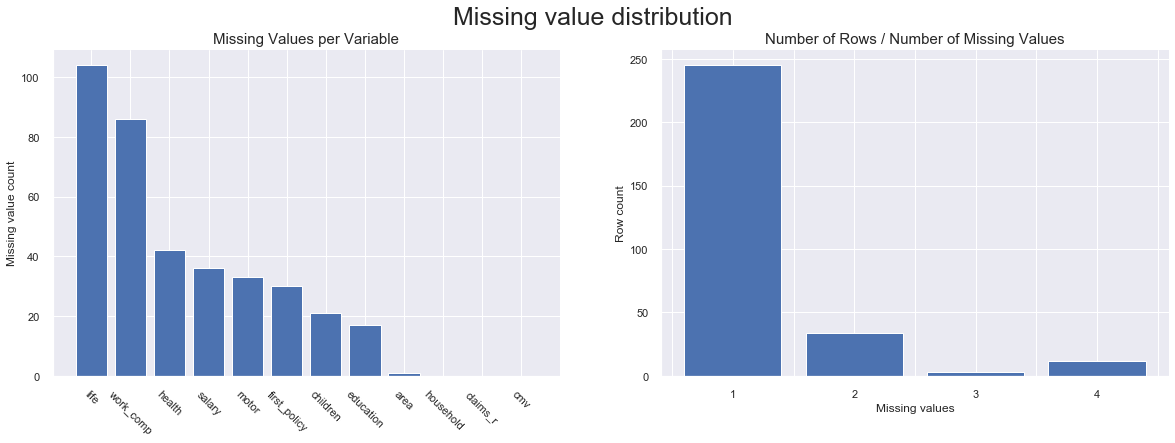

In [44]:
#Number of missing values in each feature
sns.set()

#figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

#data
ax1_data=df.isna().sum().sort_values(ascending=False)
ax1.bar(x=ax1_data.index, height=ax1_data)
ax2_data=df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index().drop(0, axis=0)
ax2.bar(x=ax2_data.index, height=ax2_data)

#layout
plt.suptitle("Missing value distribution", fontsize=25)

ax1.set_ylabel("Missing value count")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title("Missing Values per Variable", fontsize=15)
for tick in ax1.get_xticklabels():
    tick.set_rotation(-45)

ax2.set_xlabel("Missing values")
ax2.set_ylabel("Row count")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticklabels(["","",1,"",2,"",3,"",4])
ax2.set_title("Number of Rows / Number of Missing Values", fontsize=15)

plt.show()

From the visualization above one can see that most of the missing values are concentrated on the variables life and work_comp and that household, claims_r and cmv don't have missing values. Besides, we can also see that at most, rows will have 4 missing values and that most of them contain one missing value.

Regarding missing values, it is strange that almost no one has "0" in one or more premiums making this a dataset that almost everybody has almost all products. This dataset is not in accordance with the general knowledge of the area of business, namely, insurance. The only premium column that has zeros is the household and even this column only has 60 individuals with zero, which makes for around 0.6% of the client database, which is an extremely low percentage comparing to what would be expected.

Not knowing if the NaNs values in the premiums are "0"s or a proper missing value, and knowing that the database already has errors in other variables (i.e. birthday), we decided to go forward on an approach that still remains valid even after the data quality is improved, imputting the missing values using the K-Nearest Neighbors method as it is independent of which scenario is the correct one.

In [45]:
# Mask to observe the imputed values
nan_mask = df.isna().apply(lambda x: x.any(), axis=1)

table1 = df[nan_mask].head(10)

# Styling function
def highlight_nans(x):
    c1 = 'background-color: red'
    c2 = ''
    # Mask
    mask = table1.isna()
    # DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame(c2, index=x.index, columns=x.columns)
    # Modify values of df1 column by boolean mask
    df1[mask] = c1
    return df1

# Styler
table1.style.apply(highlight_nans, axis=None)

In [46]:
# Standardizing metric data since variables have different scales and KNN will calculate distances in a multi-dimensional space
metric_df = df.drop(["education", "area", "children"], axis=1)
non_metric_df = df.drop(metric_df.columns, axis=1).astype("category")
std = prep.StandardScaler()
std.fit(metric_df)
std_m_df = std.transform(metric_df)

# KNN imputer for metric variables
imputer_m = imp.KNNImputer(n_neighbors=100, weights="distance")
imputer_m.fit(std_m_df)
imputted_m = imputer_m.transform(std_m_df)
imputted_m = std.inverse_transform(imputted_m)
imputted_m[:,0] = imputted_m[:,0].astype(int)

# Mode imputer for non metric variables
imputer_nm = imp.SimpleImputer(strategy="most_frequent")
imputer_nm.fit(non_metric_df)
imputted_nm = imputer_nm.transform(non_metric_df)

# Concatenating metric and non-metric imputations
imp_df = pd.DataFrame(np.concatenate([imputted_m, imputted_nm], axis=1), df.index)
imp_df.columns = ["first_policy", "salary", "cmv", "claims_r", "motor", "household",
                  "health", "life", "work_comp", "education", "area", "children"]
imp_df = imp_df.astype(dict(zip(imp_df.columns, 
                                ["float64", "float64", "float64", "float64", "float64", "float64", 
                                 "float64", "float64", "float64", "object", "object", "object",])))

# Styler
imp_df = imp_df[df.columns]
table2 = imp_df[nan_mask].head(10)
table2.style.apply(highlight_nans, axis=None)

Above we imputted the missing values. We used the K-Nearest Neighbors imputter provided in the scikit-learn package to impute missing values in metric variables using the mean of the neighbors. For the non-metric variables we simply imputted the missing values using the mode of the categorical variable by resorting to the Simple imputter. It is also possible to visualize the imputted values above since they are highlighted.

In [47]:
# Imputting missing values for outlier observations using the fitted estimators of the 

# Standardizing metric data since variables have different scales and KNN will calculate distances in a multi-dimensional space
metric_df_out = df_out.drop(["education", "area", "children"], axis=1)
non_metric_df_out = df_out.drop(metric_df_out.columns, axis=1).astype("category")
std_m_df_out = std.transform(metric_df_out)

# KNN imputer for metric variables
imputted_m_out = imputer_m.transform(std_m_df_out)
imputted_m_out = std.inverse_transform(imputted_m_out)
imputted_m_out[:,0] = imputted_m_out[:,0].astype(int)

# Mode imputer for non metric variables
imputer_nm.fit(non_metric_df_out)
imputted_nm_out = imputer_nm.transform(non_metric_df_out)

# Concatenating metric and non-metric imputations
imp_df_out = pd.DataFrame(np.concatenate([imputted_m_out, imputted_nm_out], axis=1), df_out.index)
imp_df_out.columns = ["first_policy", "salary", "cmv", "claims_r", "motor", "household",
                  "health", "life", "work_comp", "education", "area", "children"]
df_out = imp_df_out.astype(dict(zip(imp_df_out.columns, 
                                ["float64", "float64", "float64", "float64", "float64", "float64", 
                                 "float64", "float64", "float64", "object", "object", "object",])))

In [48]:
df = imp_df
n_nans = df.isna().values.sum()
print("There exists {} missing values in df".format(n_nans))

There exists 0 missing values in df


## 3.4: Non-metric Variables

Standard cluster analysis requires the use of distance metrics, such as euclidean distance, to measure the similarity between clusters. In the case where euclidean distance is employed, the input variables need to be metric and continuous (even though the later condition can usually be disregarded without causing too much harm). In the present dataset, we have some features which don't satisfy the first condition (i.e. education, area and children). Before applying an adequate solution to deal with this issue, we will first assess if these variables actually present any useful pattern that could contribute for the development of the clusters.

### 3.4.1 - Usefulness of Non-metric Variables

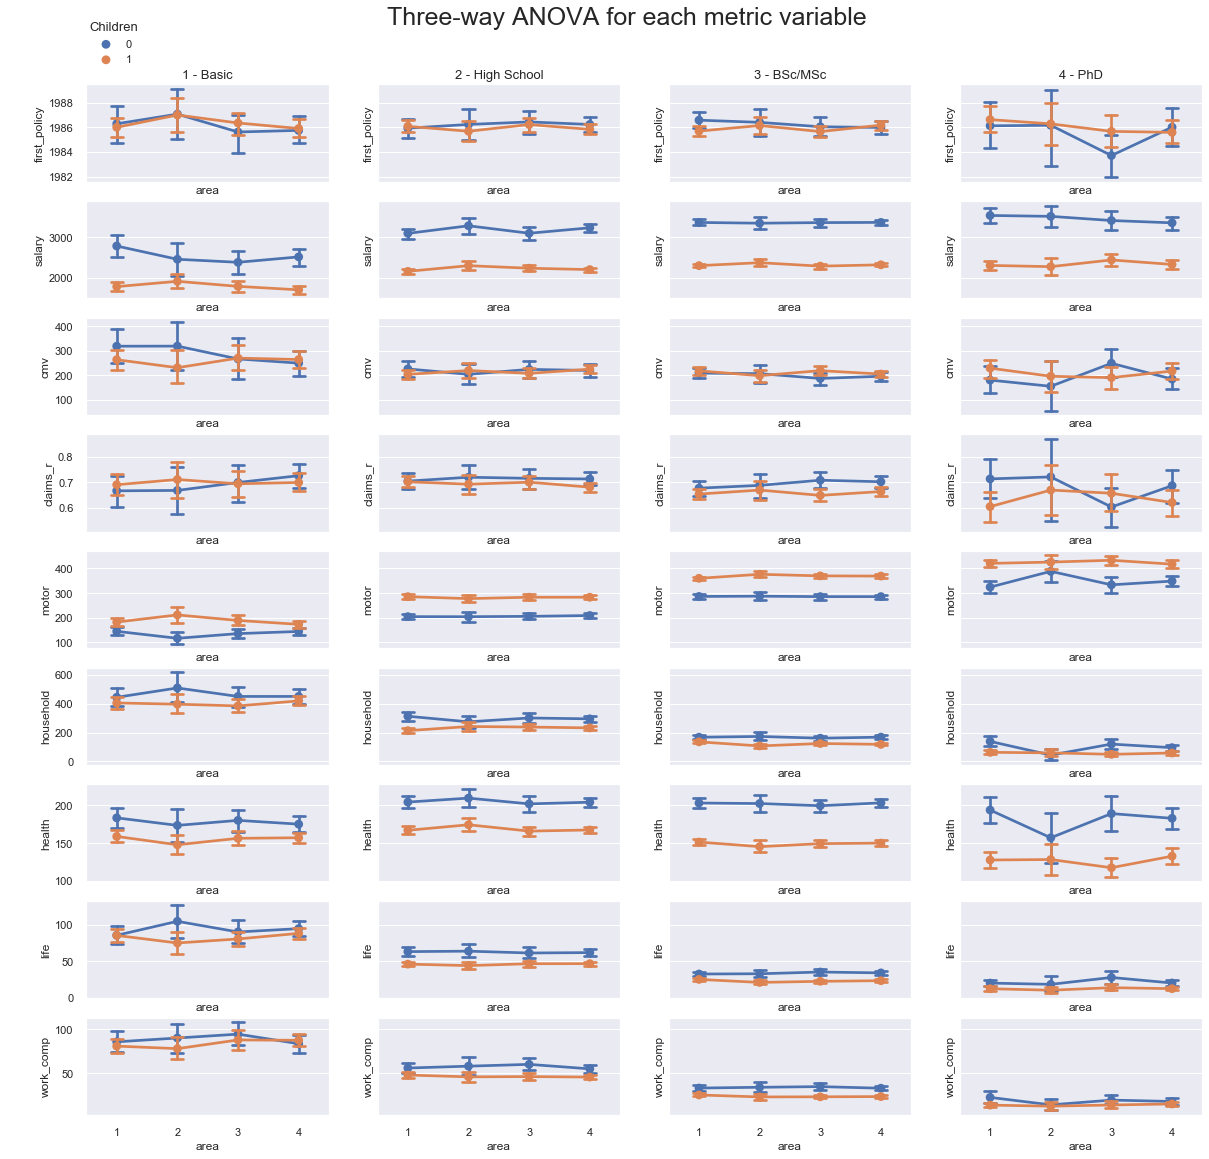

In [49]:
sns.set()

fig, axes = plt.subplots(9, 4, figsize=(20,18), sharex=True, sharey="row")

metric_vars = ["first_policy", "salary", "cmv", "claims_r", "motor", "household", "health", "life", "work_comp"] 

educ_vals = ["1 - Basic", "2 - High School", "3 - BSc/MSc", "4 - PhD"]

for ax, var, educ in zip(axes.flatten(), np.array([[i]*4 for i in metric_vars]).flatten(), educ_vals*9):
    data = df.loc[df["education"]==educ]
    sns.pointplot(x="area", y=var, hue="children", data=data, capsize=.2,
                 height=6, aspect=.75, ax=ax)
    ax.get_legend().remove()
#     ax.set_xlabel("Area", fontsize=13)

# Set columns' titles (education)
for ax, label in zip(axes[0,:], educ_vals):
    ax.set_title(label, fontsize=13)

# Set legend (children)
handles, _ = axes[0,0].get_legend_handles_labels()
fig.legend(handles, ["0","1"], loc=(0.07,0.94), title="Children", title_fontsize=13)

# Set x axis labels (area)
plt.xticks([0,1,2,3], ["1","2","3","4"])

# Set figure
plt.subplots_adjust(top=0.92)
plt.suptitle("Three-way ANOVA for each metric variable", fontsize=25)

plt.show()

From the visualization above we can compare the mean estimate (points) along with its confidence interval (width) across different levels of area (x axis), children (color) and education (columns) for each metric variable (rows). This allows one to partially see whether the categorical variables impact or not the distribution of the metric variables (i.e. if the average changes for different levels of the categorical variables) and in which way. The concept of this graphic is very similiar to the one behind a three-way ANOVA test and can be considered almost as an illustration of this test.

We can easily observe that customers with **children** have lower salary, higher motor and lower health. It isn't so noticeable but children also slightly impacts the remaining LOBs, so we concluded that children is in fact a meaningful variable that could provide useful information for the cluster analysis. About **education**, we can also see some clear patterns: people with Basic Education receive fairly less salary than the other groups and the cmv for this group is also higher, relative to the LOBs the higher the education, the higher motor will be, even though household, life, and work_comp will decrease. The only LOB that remains sort of constant across education is health. Finally, there doesn't seem to exist significant deviations in the metric variables' distribution according to **area**, thus we decided to exclude this variable from further analysis.

In [50]:
df.drop("area", axis=1, inplace=True)
df_out.drop("area", axis=1, inplace=True)

## 3.5: Feature Engineering

Below are the new features we decided to create together with a brief explanation of each:

- **Years as customer (years_customer):**

Instead of using first_policy we will use years_customer
- **Annual profit proxy = cmv/ years_customer (annual_profit):**

This is a proxy variable since it doesn't consider the acquisition cost of the customer (however we think that this should be relatively the same for each customer)
- **Total premiums (t_premiums):**

This variable reflects the amount of money each customer spent with the insurance company in the last year (monetary variable)
- **Yearly salary (year_salary):**

Instead of using salary we will use year_salary because other variables are measured yearly
- **Proportion of salary spent in insurance  = t_premiums/ year_salary (t_premiums_salary):**

This variable relativizes the amount of money spent by each customer by taking into consideration their salary
- **Each premium LOB/ Total premiums:**

This variables reflect the same information as the previous premium LOBs but as a proportion of the spending of each customer
- **Canceled (negative premiums):**

This variable expresses which customers canceled a contract (i.e. reversals in premiums)

In [51]:
# Feature engineering
def feature_eng(df):
    df["years_customer"] = 2016 - df["first_policy"]
    df["annual_profit"] = df["cmv"] / df["years_customer"] # we don't know the acquisition cost so this is a proxy
    df["t_premiums"] = df[["motor","household","health","life","work_comp"]].applymap(lambda x: 0 if x<0 else x).sum(axis=1) #some values are negative and then the prop would become >1 and <0
    df["year_salary"] = df["salary"]*12 #the salary is monthly and the premium are anual
    df["t_premiums_salary"] = df["t_premiums"] / df["year_salary"]
    df["motor_prop"] = df["motor"] / df["t_premiums"]
    df["household_prop"] = df["household"] / df["t_premiums"]
    df["health_prop"] = df["health"] / df["t_premiums"]
    df["life_prop"] = df["life"] / df["t_premiums"]
    df["work_comp_prop"] = df["work_comp"] / df["t_premiums"]
    df["canceled"] = (df.loc[:,["motor","household","health","life","work_comp"]]<0).any(axis=1).astype(int)
    df["educ_enc"] = df["education"].apply(lambda x: x[0])

# Organizing df
feature_eng(df) # Creating new features for df
df = df.drop(["first_policy", "salary", "education"], axis=1) # no need to keep both first_policy and years_customer
df = df.astype(dict(zip(df.columns, [str] + [float]*17 + [str, str])))
df = df[["years_customer", "educ_enc", "year_salary", "children", "cmv", "claims_r", 
         "motor", "household", "health", "life", "work_comp", "annual_profit", "t_premiums_salary",
         "t_premiums", "motor_prop", "household_prop", "health_prop", "life_prop", "work_comp_prop", "canceled"]]

# Organizing df_out
feature_eng(df_out) # Creating new features for df_out
df_out = df_out.drop(["first_policy", "salary", "education"], axis=1) # no need to keep both first_policy and years_customer
df_out = df_out.astype(dict(zip(df_out.columns, [str] + [float]*17 + [str, str])))
df_out = df_out[["years_customer", "educ_enc", "year_salary", "children", "cmv", "claims_r", 
                 "motor", "household", "health", "life", "work_comp", "annual_profit", "t_premiums_salary",
                 "t_premiums", "motor_prop", "household_prop", "health_prop", "life_prop", "work_comp_prop", "canceled"]]

df.head()

years_customer educ_enc  year_salary children     cmv  claims_r   motor  \
id                                                                            
1             31.0        2      26124.0      1.0  380.97      0.39  375.85   
2             35.0        2       8124.0      1.0 -131.13      1.12   77.46   
3             25.0        1      27324.0      0.0  504.67      0.28  206.15   
4             26.0        3      13188.0      1.0  -16.99      0.99  182.48   
5             30.0        3      21156.0      1.0   35.23      0.90  338.62   

    household  health    life  work_comp  annual_profit  t_premiums_salary  \
id                                                                           
1       79.45  146.36   47.01      16.89      12.289355           0.025477   
2      416.20  116.69  194.48     106.13      -3.746571           0.112132   
3      224.50  124.58   86.35      99.02      20.186800           0.027104   
4       43.35  311.17   35.34      28.34      -0.653462           0.045547   
5       47.80  182.59   18.78      41.45       1.174333           0.029743   

    t_premiums  motor_prop  household_prop  health_prop  life_prop  \
id                                                                   
1       665.56    0.564712        0.119373     0.219905   0.070632   
2       910.96    0.085031        0.456881     0.128096   0.213489   
3       740.60    0.278355        0.303133     0.168215   0.116595   
4       600.68    0.303789        0.072168     0.518030   0.058833   
5       629.24    0.538141        0.075965     0.290175   0.029846   

    work_comp_prop canceled  
id                           
1         0.025377        0  
2         0.116503        0  
3         0.133702        0  
4         0.047180        0  
5         0.065873        0

## 3.6: Data Cleaning Validation

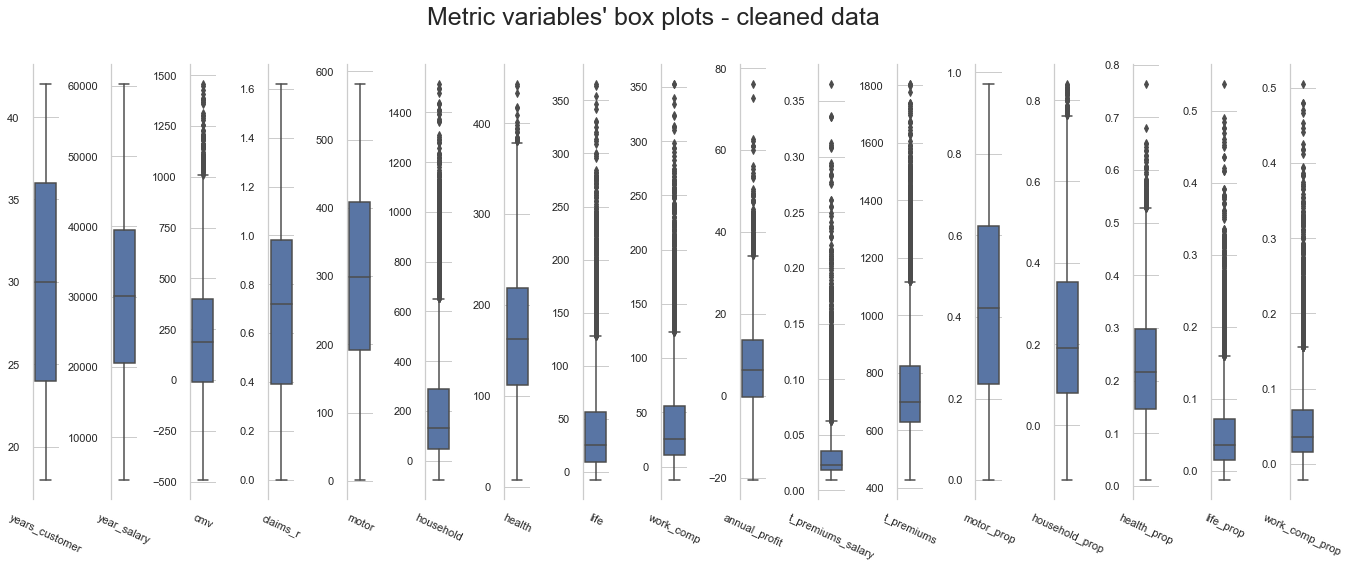

In [52]:
sns.set(style="whitegrid")

# Prepare dataframe layout
metric_df = df[df.columns[df.dtypes!="object"]]
plot_data = metric_df.reset_index().melt("id")
plot_features = metric_df.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(23,8))
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=plot_data.loc[plot_data["variable"]==i[1]], ax=i[0])
    i[0].set_xlabel("")
    i[0].set_ylabel("")
    for tick in i[0].get_xticklabels():
        tick.set_rotation(-25)

# Finalize the plot
plt.subplots_adjust(wspace=2)
fig.suptitle("Metric variables' box plots - cleaned data", fontsize=25)
sns.despine(bottom=True)

plt.show()

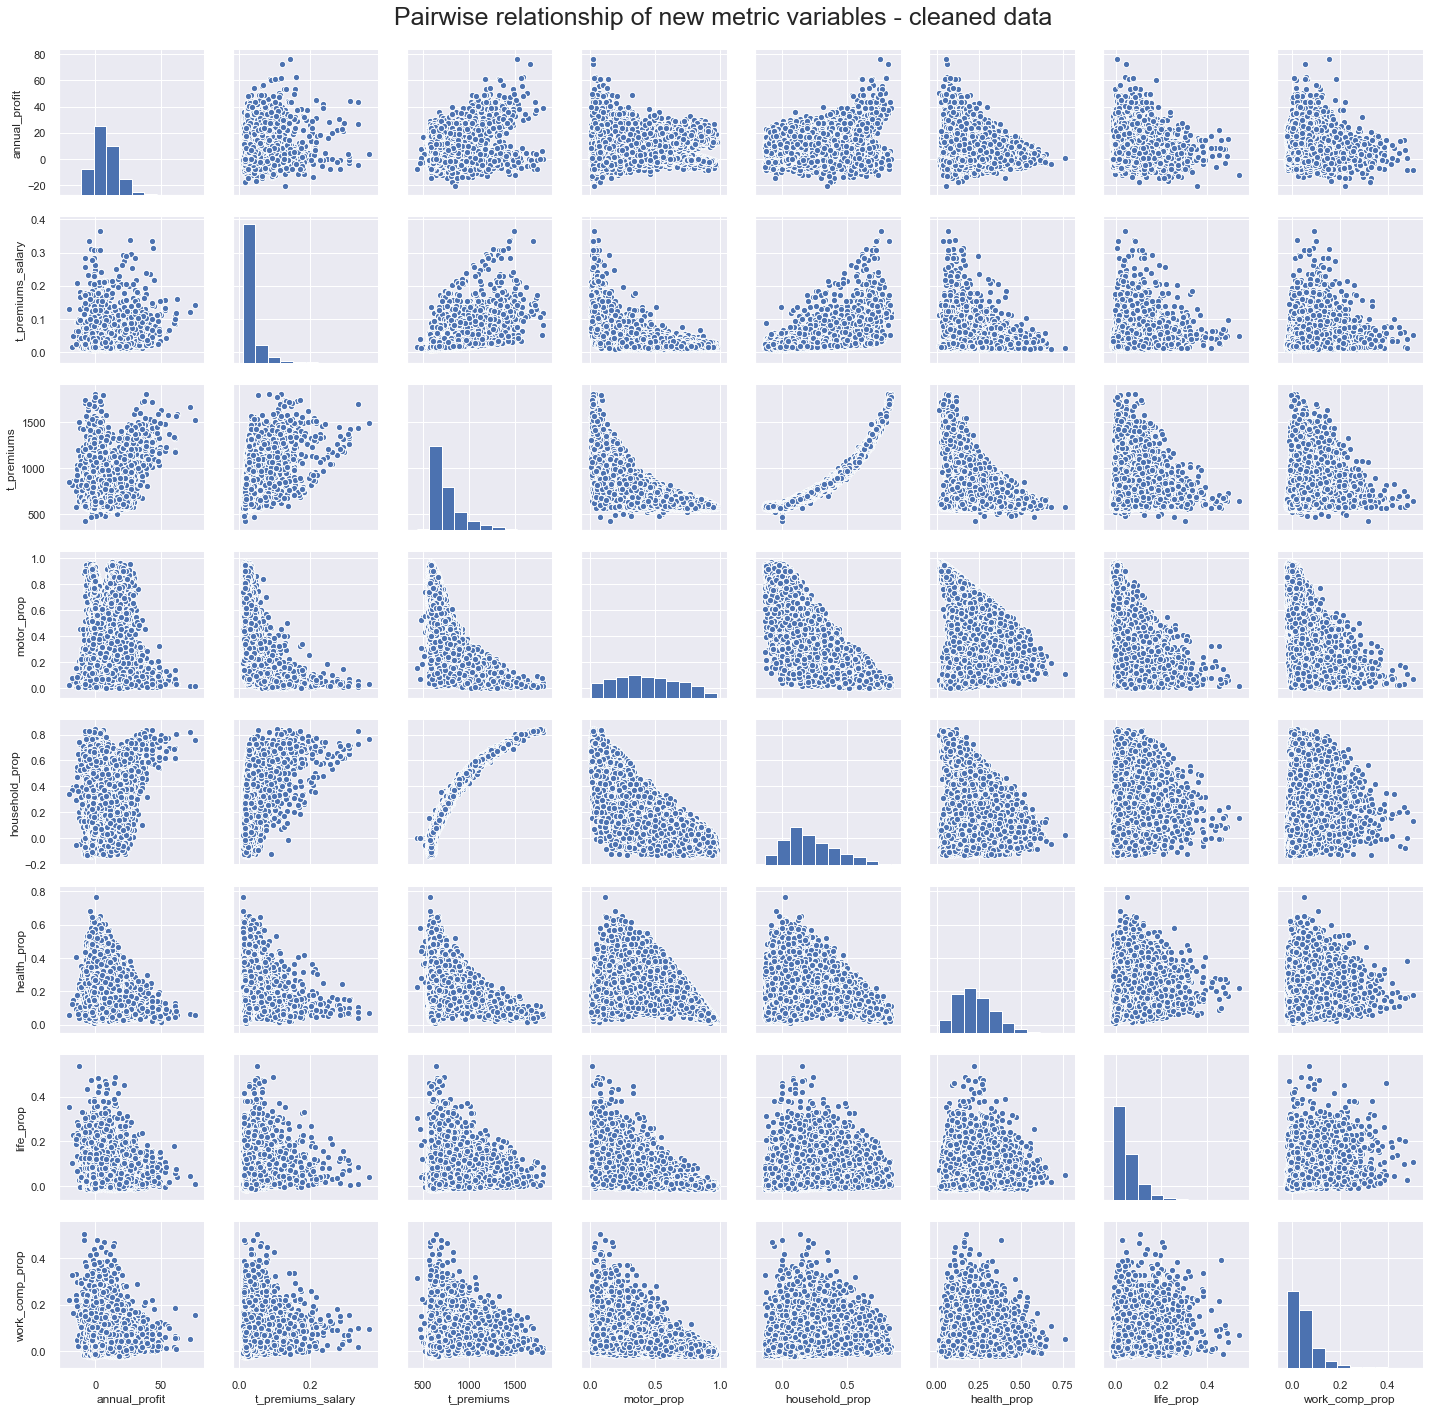

In [53]:
sns.set()

new_metric_df = metric_df[["annual_profit", "t_premiums_salary", "t_premiums", "motor_prop", 
                           "household_prop", "health_prop", "life_prop", "work_comp_prop"]]
# Setting pairgrid
g = sns.PairGrid(new_metric_df)

# Populating pairgrid
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of new metric variables - cleaned data", fontsize=25)

plt.show()

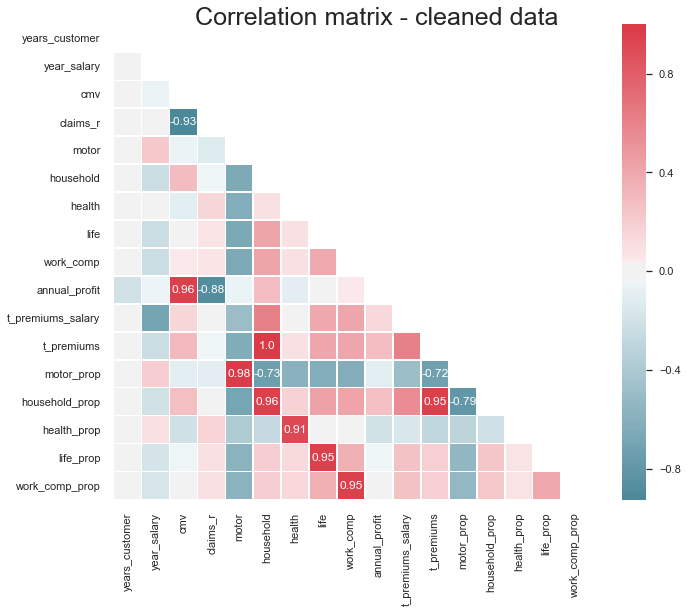

In [54]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric_df.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Pass 2D Numpy array to annot parameter
mask_annot = np.absolute(corr.values)>=0.70 # Annotate correlations above abs(0.7)
annot_arr = np.where(mask_annot, corr.values.round(2), np.full((17,17),""))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, mask=mask, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix - cleaned data", fontsize=25)
plt.yticks(rotation=0)

# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

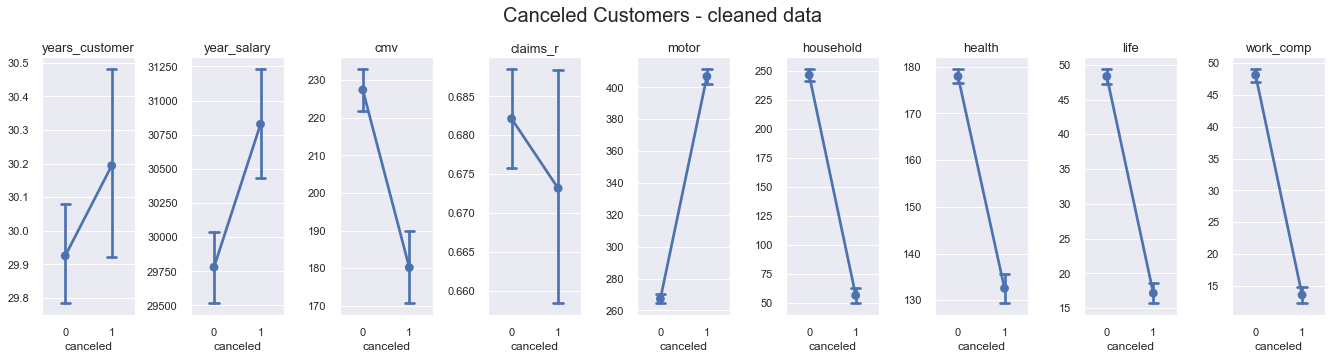

In [55]:
sns.set()

fig, axes = plt.subplots(1, 9, figsize=(23,5))

metric_vars = ["years_customer", "year_salary", "cmv", "claims_r", "motor", "household", "health", "life", "work_comp"] 

for ax, var in zip(axes, metric_vars):
    sns.pointplot(x="canceled", y=var, data=df, capsize=.2,
                 height=6, aspect=.75, ax=ax)
    ax.set_ylabel("")
    
# Set axes' titles
for ax, label in zip(axes, metric_vars):
    ax.set_title(label, fontsize=13)
    
# Set x axis labels (canceled)
plt.xticks([0,1], ["0","1"])

# Set figure
plt.subplots_adjust(top=0.84, wspace=0.6)
plt.suptitle("Canceled Customers - cleaned data", fontsize=20)

plt.show()

From the validation above we can take some conclusions. First, from the "Metric Variable's box plots - cleaned data" we can see that the univariate distribution of our variables seems fairly well behaved with some high values in annual_profit, t_premiums_salary, health_prop and life_prop but nothing too concerning that would cause them to be considered outliers.

Then, from the "Pairwise relationship of new metric variables - cleaned data" we can observe the bivariate distributions of the each pair of new variables. These again, don't show any absurd observation. More interestingly, is the relationship between house_prop and t_premiums which suggests that customers that spend more in premiums (absolute value) have an higher proportion of their spendings in the household LOB. 

In the "Correlation matrix - cleaned data" it is possible to confirm that household_prop and t_premiums are highly positively correlated (1). Besides, the prop and absolute LOBs are also highly positively correlated which indicates that we should consider each set separately in the cluster analysis to avoid redundancy. It is also interesting to see that the motor LOB is negatively correlated with the remaining variables which suggests that one of our clusters are the customer that only spend in the motor LOB. Besides, cmv is highly correlated with annual_profit and claims_r which indicates the three variables shouldn't be used together.

Finally we also looked at the characteristics of customers that canceled any of their contracts. There's a clear significant distinction between the ones that canceled and that didn't, namely on the cmv and all the LOBs, as can be seen from the "Canceled Customers - cleaned data" visualization. 

# 4) Cluster Analysis
After cleaning the data we can now proceed to the actual cluster analysis. The data cleaning was required to enable a good cluster solution since the type of techniques that we will use don't tolerate missing values and are susceptible to the presence of outlier observations. We also focused on building new features that could provide meaningful information to discriminate between the clusters and also in the analysis of the non-metric variables and in what information they provide.

In this analysis we will focus on several clustering algorithms, as well as in three different segmentations: 
* "complete", where we will find the groups of customers according to both their purchasing and socio-economic behaviour;
* "customer", where we will find the groups of customers according to their socio-economic behaviour;
* "product", where we will find the groups of customers according to their purchasing behaviour.

## 4.1: Feature Selection

In order to perform each segmentation we need to select the variables that reflect the behaviour that we want to represent. Besides, our choice should provide some statistical validity, that is, we should avoid including highly correlated variables in the same clustering since these will provide redudant information. As seen previously, we shouldn't include the following set of variables simultaneously:
* absolute and proportional LOBs,
* cmv, annual_profit and claims_r and 
* t_premiums, household and household_prop

Below there are the datasets that we decided would be interesting to use:

In [56]:
complete_df = df.loc[:,['years_customer', 'educ_enc', 'year_salary', 'children', 'cmv', 'motor', 'household', 
                        'health', 'life', 'work_comp', 't_premiums_salary', 'canceled']]
prod_abs_df = df.loc[:,['motor', 'household', 'health', 'life', 'work_comp']]
prod_prop_df = df.loc[:,['motor_prop', 'household_prop', 'health_prop', 'life_prop', 'work_comp_prop']]
custom_df = df.loc[:,['years_customer', 'educ_enc', 'year_salary', 'children', 'cmv', 't_premiums_salary', 'canceled']]

## 4.2: Defined Functions
For the cluster analysis to be consistent we defined some functions that allow us to perform repetitive tasks. These functions will be used along section 4) Cluster Analysis and a brief description of each one can be consulted through the respective docstrings.

In [57]:
def kelbowplots(clus_estim, data):
    """
    This function produces the k-elbow plot for a given clustering estimator according to 3 different clustering quality measures: "Distortion", "Silhouette" and "Calinski Harabasz".
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # Plot the data
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        # KElbowVisualizer produces the elbow plot for several quality measures
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    # Set figure
    plt.suptitle("K-Elbow Plots", fontsize=23)

    plt.show()

In [58]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    This function calculates the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on the fact that the Sum of squares (SSt) of all the data
    can be decomposed into the sum of SS within clusters (SSw) and SS between clusters (SSb): SSt = SSw + SSb. The R2 is the ratio between
    SSb and SSt: R2 = SSb/SSt. The higher the R2 the better the solution since SSw will be close to 0 which indicated perfect homogeneous
    clusters.
    """
    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

In [59]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    This function calculates the silhouette coefficient for each observation according to a clustering solution and then builds the 
    Silhouette plots for a given range of cluster solutions. This is useful to find out the most appropriate number of clusters.
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))
    
    sns.set()
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # in case we want to seed the silhouette for just one cluster solution
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # Get parameter that defines number of clusters
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Estimator has no parameter to define number of clusters")
            return None
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # initialize y_lower
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("{} Clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette Coefficients")
        ax.set_ylabel("Cluster Labels")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette") # The vertical line for average silhouette score of all the values
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average Silhouette = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Clustering Silhouette Plots"), fontsize=23, fontweight='bold')
    plt.show()

In [60]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [61]:
def comp_gmm_models(df, max_nclus, min_nclus=2):
    """
    This function produces a bar plot for each quality criteria (AIC, BIC) to asses what is the best gmm configuration
    """
    # Data
    n_components_range = range(min_nclus, max_nclus+1)
    cv_types = ['spherical', 'tied', 'diag', 'full'] #values of the covariance type parameter
    bic = np.empty((4, len(n_components_range)))
    aic = np.empty((4, len(n_components_range)))
    for r, cv_type in enumerate(cv_types):
        for c, n_components in enumerate(n_components_range):
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(df)
            # Save quality measure value
            bic[r, c] = gmm.bic(df)
            aic[r, c] = gmm.aic(df)

    # Traces
    bic = pd.DataFrame(bic, columns=n_components_range, index=cv_types)
    aic = pd.DataFrame(aic, columns=n_components_range, index=cv_types)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,7))
    
    sns.barplot(data=bic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax1)
    
    sns.barplot(data=aic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax2)

    # Layout
    ax1.set_xlabel('Number of Components')
    ax2.set_xlabel('Number of Components')
    ax1.set_ylabel('BIC Criteria')
    ax2.set_ylabel('AIC Criteria')
    ax1.legend(title="Covariance Type")
    ax2.legend(title="Covariance Type")
    plt.suptitle('BIC and AIC Scores per Model', fontsize=23)

    plt.show()

In [62]:
def correspondence_analysis(cat_df, row_cats=None, mca=False, dim_plot=False, ret_dim=2, assess=False, normalization="row_principal"):
    """
    This function performs simple or multiple correspondence analysis and outputs the corresponding perceptual map, which can be used to interpret the associations between categories.
    """
    # FORM INPUT MATRIX
    cat_labels = cat_df.columns
    if mca:
        Z = cat_df.values
        input_matrix = Z.T@Z # Burt Table
    else:
        input_matrix = cat_df.loc[:,row_cats].values.T @ cat_df.loc[:,[i for i in cat_labels if i not in row_cats]].values # Contigency table
        
    # FROM INPUT MATRIX TO CHI-SQ VALUES
    n = np.sum(input_matrix)  # grand total
    P = input_matrix / n  # correspondence matrix/ frequency table
    rt = np.expand_dims(np.sum(P, axis=1), axis=1)  # row totals
    ct = np.expand_dims(np.sum(P, axis=0), axis=1)  # column totals
    RP = np.diag(rt[:, 0] ** -1) @ P  # row profile table
    CP = np.diag(ct[:, 0] ** -1) @ P.T  # columns profile table
    E = rt @ ct.T  # independence model/ expected proportions
    R = P - E  # residuals/ difference between observed and expected proportions
    CS = (R ** 2) / E  # chi-sq values

    # CHI-SQ TEST OF INDEPENDENCE OF COLUMNS AND ROWS
    Csqs = n * np.sum(CS)  # Chi-sq statistic
    inertia = Csqs / n  # total inertia of Fm
    df = (input_matrix.shape[0] - 1) * (input_matrix.shape[1] - 1)  # df for test of independence
    p_value = 1 - chi2.cdf(Csqs, df)  # p-value for independence test of employees and smoking habits
    print("The Chi-square test of independence has a p-value of {0:.2f}".format(p_value))
    
    # DECOMPOSING THE STANDARDIZED RESIDUALS MATRIX
    I = R / E  # indexed residuals - tells us the association between 2 categories comparing to what would be expected
    Z = I * (E ** 0.5)  # standardized residuals (sqrt of CS)
    U, s, v = svd(Z, full_matrices=False)  # singular values decomposition of Z
    V = v.T
    S = np.diag(s)
    
    # DETERMINING NUMBER OF DIMENSIONS TO RETAIN
    max_dim = np.min(input_matrix.shape) - 1  # maximum number of dimensions possible
    inrt_dim = np.diag(S)[:max_dim] ** 2  # inertia retained by each dim
    perc_inrt = inrt_dim / inertia  # proportion inertia retained by each dim
    cumul_inrt = np.cumsum(perc_inrt)  # cumulative inertia retained by each dim
    expect_inrt = inertia / max_dim  # expected inertia for each dim
    print("The proportion of Inertia retained with {0} dimensions is {1:.2f}".format(ret_dim, cumul_inrt[ret_dim-1]))
    
    if dim_plot:
        # Figure
        sns.set(style="dark")
        fig, ax1 = plt.subplots(figsize=(16, 8))
        # Traces
        x = np.arange(1, max_dim+1)
        ax2 = ax1.twinx()
        ax2.plot(x, cumul_inrt, color='r', marker='o', linewidth=2.5, label='Cumulative Proportion of Inertia')
        ax1.bar(x, height=inrt_dim, label='Inertia by Dimension')
        ax1.axhline(expect_inrt, color='k', linestyle="--", label="Expect Inertia by Dimension")
        # Layout
        ax1.set_ylabel('Inertia')
        ax2.set_ylabel('Cumulative Proportion of Inertia')
        ax1.set_xlabel('Dimensions')
        ax1.set_title('Inertia Over Dimensions', fontsize=18, pad=20)
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # build legend
        plt.xticks(x, list(map(lambda i: str(i), list(x))))
        # Show figure
        plt.show()
    
    if normalization == "row_principal":
        # COMPUTING ROW SCORES
        row_scores = np.diag(rt[:, 0] ** -0.5) @ U  # standard coordinates
        row_scores = (row_scores @ S)[:, :max_dim]  # applying principal normalization
        ret_rscr = row_scores[:, 0:ret_dim]

        # COMPUTING COLUMN SCORES
        col_scores = np.diag(ct[:, 0] ** -0.5) @ V  # standard coordinates
        col_scores = col_scores[:, :max_dim]  # no normalization (row principal normalization)
        # col_scores = (col_scores @ S)[:, :max_dim]  # applying principal normalization
        ret_cscr = col_scores[:, 0:ret_dim]
    else:
        print("Not implemented")
        return True
    
    if not assess:
        return ret_rscr, ret_cscr
    else:
        # PM REPRESENTATION QUALITY ASSESSMENT
        row_inert = np.sum(CS, axis=1)  # inertia by rows
        col_inert = np.sum(CS, axis=0)  # inertia by columns
        row_mass = rt  # mass of rows
        col_mass = ct  # mass of columns
        eigval = (S @ S.T)[:max_dim, :max_dim]  # Getting eigenvalues (inertia accounted by each dimension)
        ret_var = np.sum(np.diag(eigval)[:ret_dim]) / np.sum(np.diag(eigval))  # % inertia retained by retained dimensions
        base = np.append(row_scores, col_scores, axis=0) ** 2
        sq_cosines = np.diag(1 / np.sum(base, axis=1)) @ base
        # squared cosines: proportion of categories variation accounted by each dim (analogous to communalities in FA)
        abs_ctrb = np.diag(np.append(row_mass, col_mass, axis=0)[:, 0]) @ base @ np.diag(np.diag(eigval) ** -1)
        # absolute contributions: proportion of dimension's inertia attributable to each category
        quality = np.sum(sq_cosines[:, :ret_dim], axis=1)  # representation of each category overall
        
        #SUMMARY OF QUALITY OF PM
        summary_df = pd.DataFrame(np.concatenate((np.expand_dims(np.append(row_inert/inertia, col_inert/inertia), axis=1),
                                          np.expand_dims(np.append(row_mass, col_mass), axis=1),
                                          np.expand_dims(quality, axis=1),
                                          np.append(row_scores[:, :ret_dim], col_scores[:, :ret_dim], axis=0),
                                          sq_cosines[:, :ret_dim],
                                          abs_ctrb[:, :ret_dim]), axis=1),
                          columns=["Prop inertia","Mass","Quality","D1","D2","SqC1","SqC2","Ctr1","Ctr2"],
                          index=cat_labels)
        return ret_rscr, ret_cscr, summary_df

## 4.3: All Data Segmentation
The first step of our cluster analysis is to provide a segmentation according to all the variables used simultaneously. We want to do this segmentation to have an overall notion of the customer behaviour groups. Afterwards, we will perform a customer and a product segmentation separately in order to study the customers' behaviour according to their socio-economic and product purchasing behaviour more precisely.

### 4.3.1 - K-means
The K-means algorithm provides a fast and efficient way to cluster individuals from a large dataset. This algorithm works by iteratively allocating each observation to the closest seed in the feature space and then recomputing the seeds by using the centroids of the points allocated to each one of them. Here the seeds are simply points in the feature space which can be initialized randomly and the number of seeds is defined by the analyst and it represents the number of clusters.

In [63]:
# Get data for clustering
# Standardize input data because we want every one of them to have the same importance
scaler = prep.StandardScaler()
complete_metric_df = complete_df.drop(['educ_enc', 'children', 'canceled'], axis=1) # Discard non-metric variables since we wil be using euclidean distance
complete_std_df = pd.DataFrame(scaler.fit_transform(complete_metric_df), index=complete_metric_df.index, columns=complete_metric_df.columns)

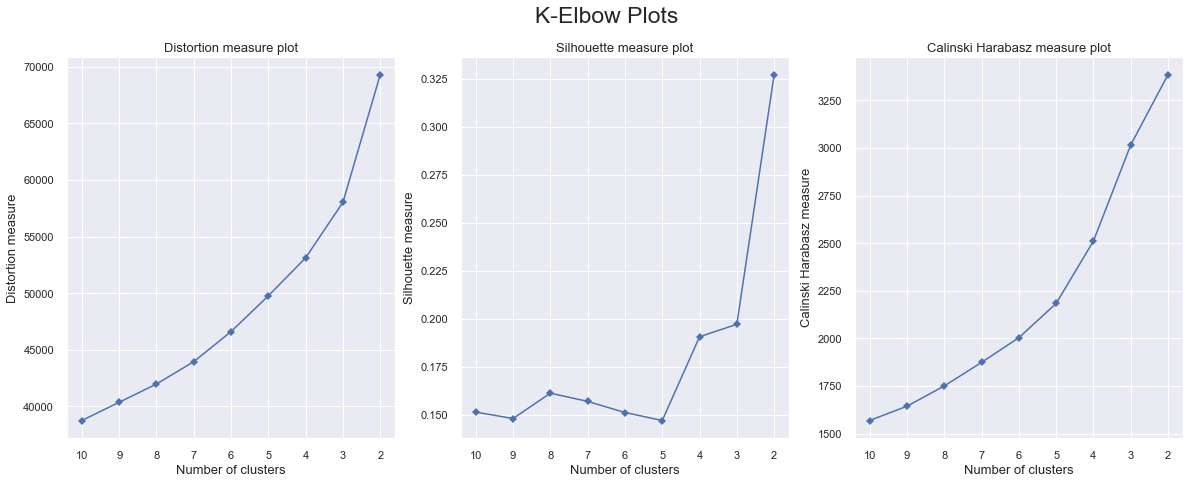

In [64]:
# Instantiate a scikit-learn K-Means model
clus_estim = KMeans(random_state=0)
# K-elbow plots
kelbowplots(clus_estim, complete_std_df)

From the visualization above we can assess how many clusters we should retain by comparing the quality of the possible cluster solutions. Besides, we also provide this comparison according to three quality measures: **Distortion, Silhouette and Calinski Harabasz**. The measures represent respectively the mean sum of squared distances to centers, mean ratio of intra-cluster and nearest-cluster distance and ratio of within to between cluster dispersion and their values should respectively be low, high and high.

In our opinion, the right choice in this case is 3 clusters since the first plot produces an elbow at the 3 clusters solution and all the remaining measures provide good results at the 3 clusters solution. The elbow is an indication that our solution is relatively good. The main rationale behind this approach is that the quality of a cluster solution always increases with the number of clusters and we should try to define a cut-off by looking at the marginal difference of the quality between adjacent cluster solutions and selecting the solution before a big drop of quality. Besides, we should also try to find a small number of clusters since it becomes increasingly hard to deal with larger number of clusters.

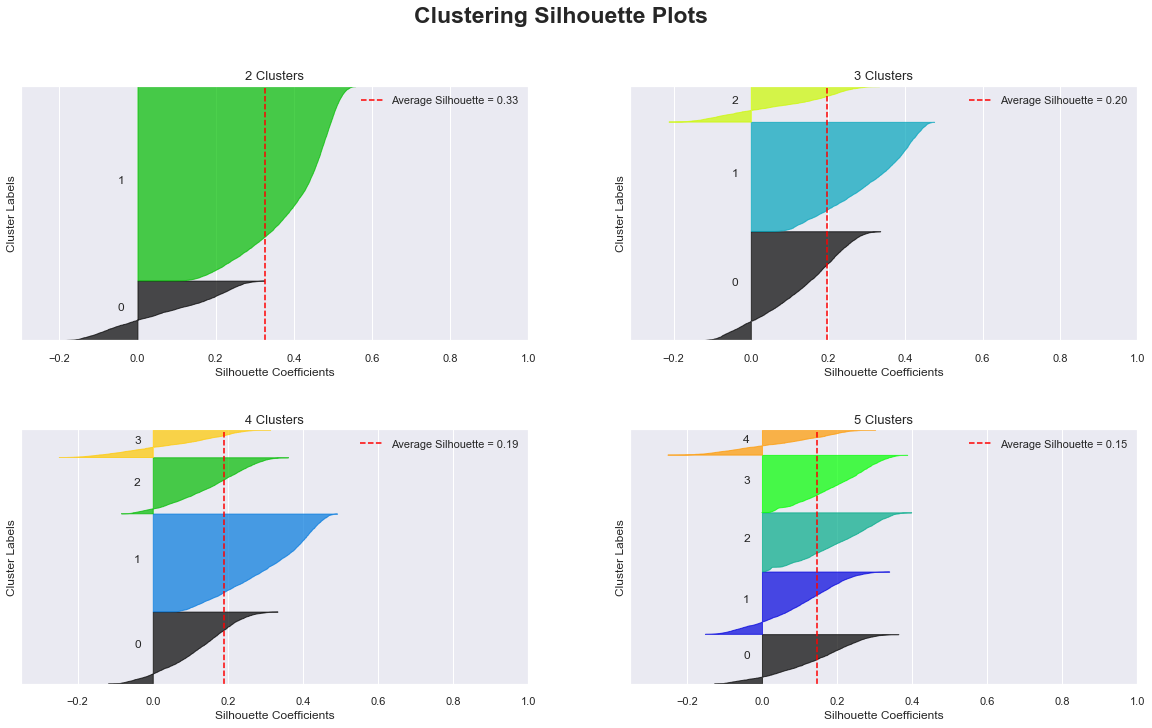

In [65]:
kmeans = KMeans(random_state=0)
silhouette_analysis(complete_std_df, kmeans, (2,2), (20,11), max_nclus=6)

Besides the K-Elbow plots we also produced the Silhouette plots for each cluster solution. This enables the analyst to visualize the silhouette score of each observation, which indicates whether the observation is correclty assigned to a specific cluster. Furthermore, one can see the average silhouette score, which is a reference of the quality of the cluster solution. It is important to note that the silhouette score has a range of \[-1, 1\], where negative and positive values imply that the observation is wrongly and correctly assigned, respectively.

From the analysis above, there doesn't seem to appear a dominant solution. The 2 clusters solution is the one with better silhouette score, however it produces very heterogeneous clusters as confirmed by the Distortion measure.

We will opt to select 3 clusters for this analysis as it is suggested by the elbow in the Distortion plot.

In [66]:
#K means Clustering 
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [67]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(complete_std_df, 3)
kmeans_complete_std_df = complete_std_df.copy()
kmeans_complete_std_df["kmeans_labels"] = clust_labels

### 4.3.1 - Gaussian Mixture Modelling (GMM)
An useful extension of the K-means model, the GMM works as a probability based clustering method. This means, that instead of being a hard clustering method (i.e. to each point one single cluster is attributed) the GMM is a soft clustering method that attributes probabilities to each point of belonging to each cluster. In a short sentence, it works as a K-means extended by Gaussians. This method does account for variablity in size and shape of clusters, admitting all ellipsoids.

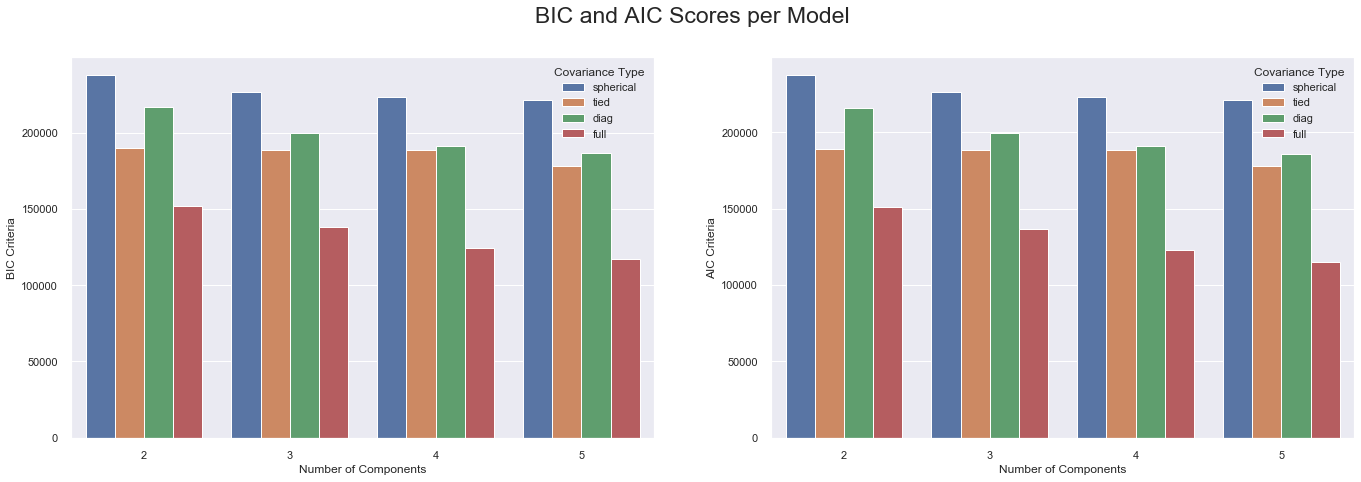

In [68]:
# Use the function built to choose the best GMM configuration
comp_gmm_models(complete_std_df, 5)

The first step in GMM is to define the parameters to use, such as the number of clusters to retain and the covariancy type to use.

It is clear from the plot above that the covariance type "full" dominates the others both in terms of AIC and BIC information criteria (the lower the better), which are measures of the cluster quality. Therefore, from the plot above we conclude that we want to use the "full" Covariance Type in our GMM.

Besides, it is also possible to see how the quality varies according to the number of clusters retained. One can conclude that with more clusters, the quality increases overall, independently of the covariance type (as it would be expected). Therefore, we will perform some further investigation on how many clusters to retain.

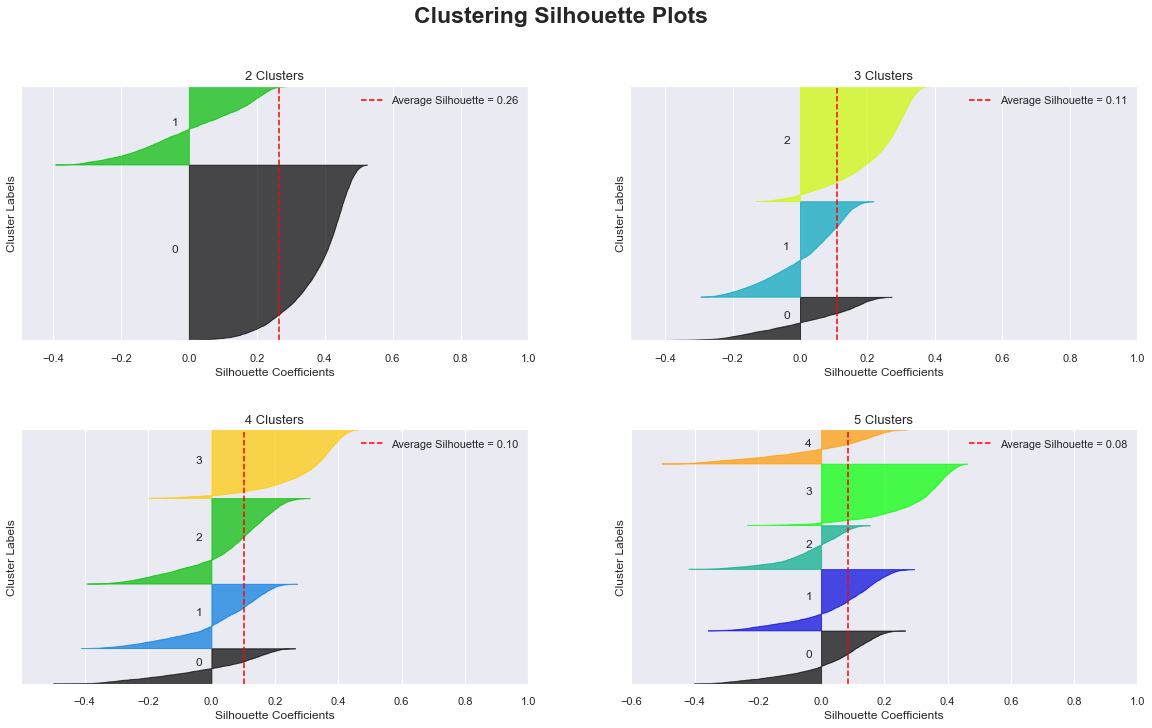

In [69]:
gmm = GaussianMixture(init_params='kmeans', random_state=0)
silhouette_analysis(complete_std_df, gmm, (2,2), (20,11), max_nclus=6)

We employed the silhouette analysis again to see how the GMM performs in terms of silhouette score. It looks that it underperforms the K-means however we will proceed to interpret this solution as the interpretation and meaning for the business often provide the best quality measure.

Again, it is hard to define the correct number of clusters to retain, so we will keep the same number of clusters as indicated by the K-means elbow plot (i.e. 3 clusters).

In [70]:
#the gmm method was aggregated on a function
def doGMM(df, nclust):
    model=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    return(clust_labels)

In [71]:
# Performing gmm and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels = doGMM(complete_std_df, 3)
gmm_complete_std_df = complete_std_df.copy()
gmm_complete_std_df["gmm_labels"] = clust_labels

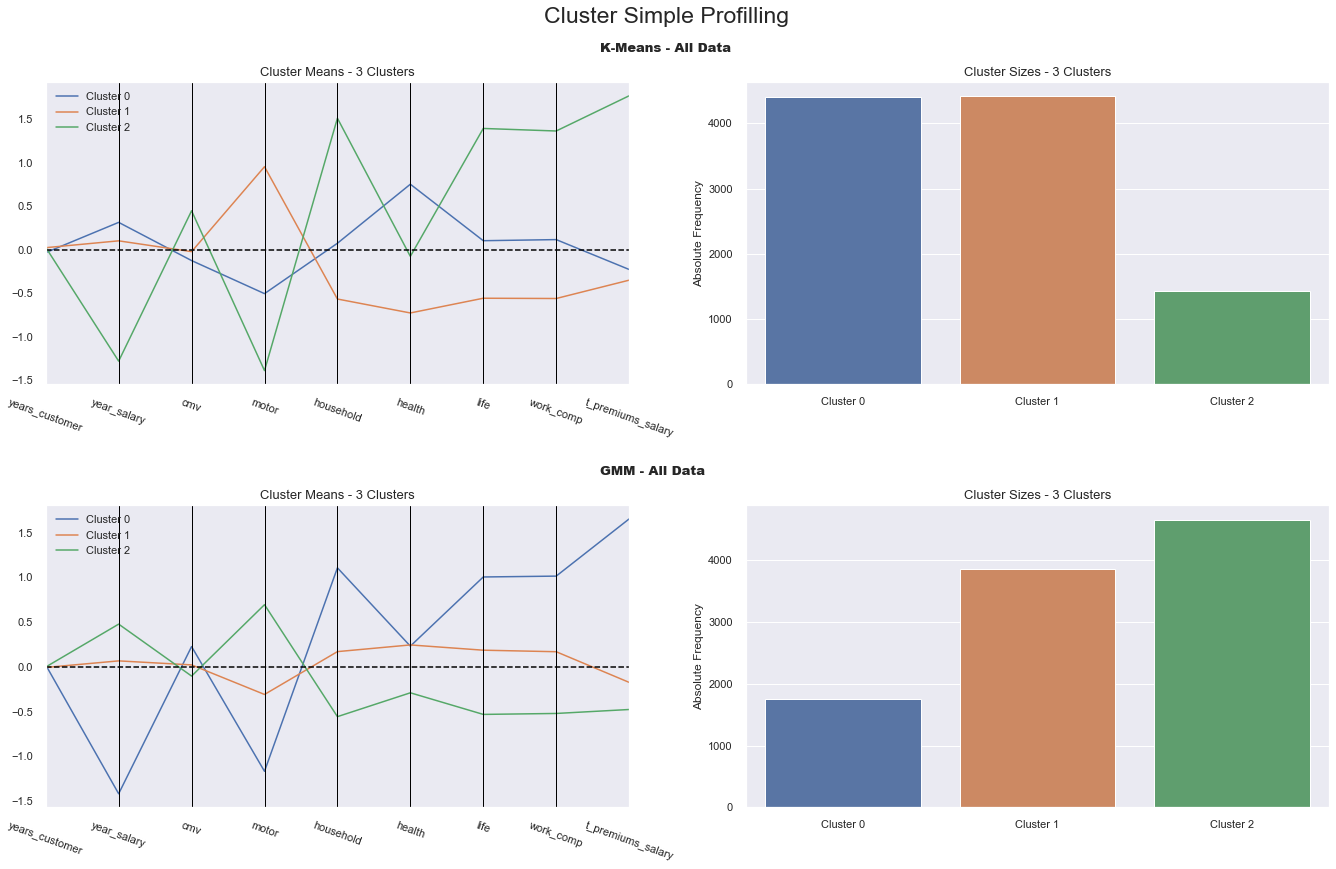

In [72]:
# Comparing both K-means and GMM solutions
comp_complete_std_df = kmeans_complete_std_df.merge(gmm_complete_std_df["gmm_labels"], left_index=True, right_index=True)
cluster_profiles(comp_complete_std_df, ["kmeans_labels", "gmm_labels"], figsize=(23, 13), compar_titles=["K-Means - All Data", "GMM - All Data"])

After comparing the 2 cluster solutions, it is evident that the GMM produces worse solutions since we obtain clusters with more similar average behaviour. For example, in terms of life and work_comp the 3 clusters lines are more near each other in the GMM than in the K-means solution. Besides, we can see that cluster 1 in GMM doesn't appear to have any particular behaviour, since the cluster line overs around the mean of each variable.

By analyzing the K-means solution, we can see that the variables that provide more discriminant behaviours across the clusters are motor, household and life, suggesting that the customers differ mainly according to the product behaviour. Furthermore, we can see (cluster 2) that there's a clear relationship between the year_salary and the product behaviour: people that earn less, invest mainly in the LOBs household, life and work_comp (and don't spend in motor). Besides, these customers are the ones that spend the highest proportion of their salary in premiums (t_premiums_salary) and the ones that have higher customer monetary value (cmv), making them a very important segment, despite their small size.

We can also identify a segment (cluster 1) of customers that spend a lot in motor and in nothing else. Finally, cluster 0 are the customers that spend the most in health, have the highest salary and are averse to spending money in motor.

## 4.4: Product segmentation

In this section we will find what are the groups of customers according to their product preferences. We will first perform a simple k-means to decide if we should use the absolute values or proportion of spending in the product LOBs. Then we will perform different clustering approaches to find out the one with the best results. Finally, we will provide the best solution we found, we will interpret it and propose ways for the company to produce value using this information. 

### 4.4.1 - Absolute Product VS Relative Product 
By using absolute data we are taking the monetary value of the customer into account. In the other hand, by using proportion data we are controlling for this characteristic. In order to decide which data to use, we will assess the quality of both clustering solutions. We will then base our decision in the comparison of these two approaches.

#### Absolute Product

In [73]:
# Get data for clustering
# Standardize input data because we want every one of them to have the same importance
scaler = prep.StandardScaler()
prod_abs_std_df = pd.DataFrame(scaler.fit_transform(prod_abs_df), index=prod_abs_df.index, columns=prod_abs_df.columns)

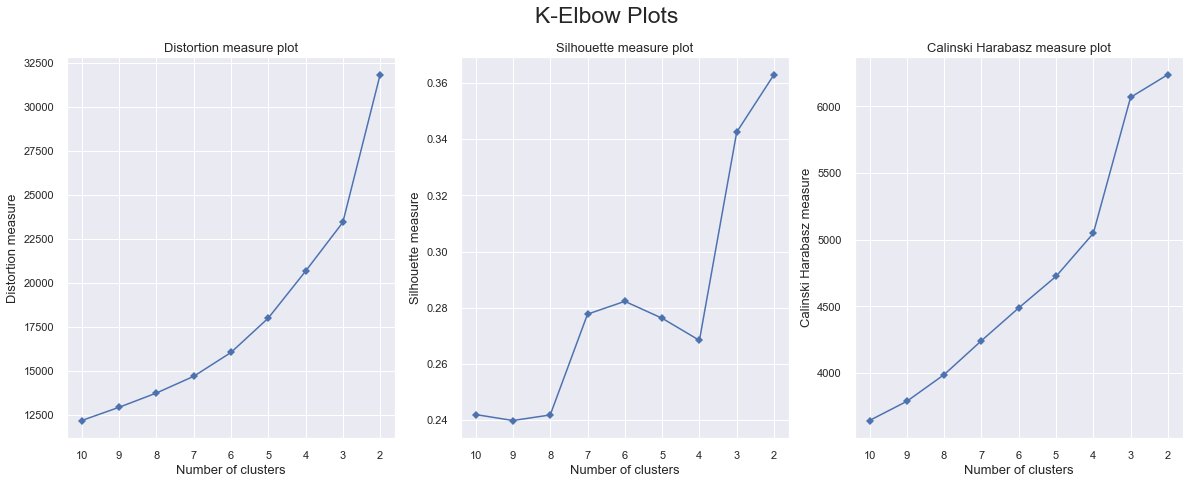

In [74]:
# Instantiate a scikit-learn K-Means model
clus_estim = KMeans(random_state=0)
# K-elbow plots
kelbowplots(clus_estim, prod_abs_std_df)

In our opinion, it is clear that the right choice in this case is 3 clusters since the first plot produces an elbow at the 3 clusters solution and all the remaining measures provide good results at the 3 clusters solution.

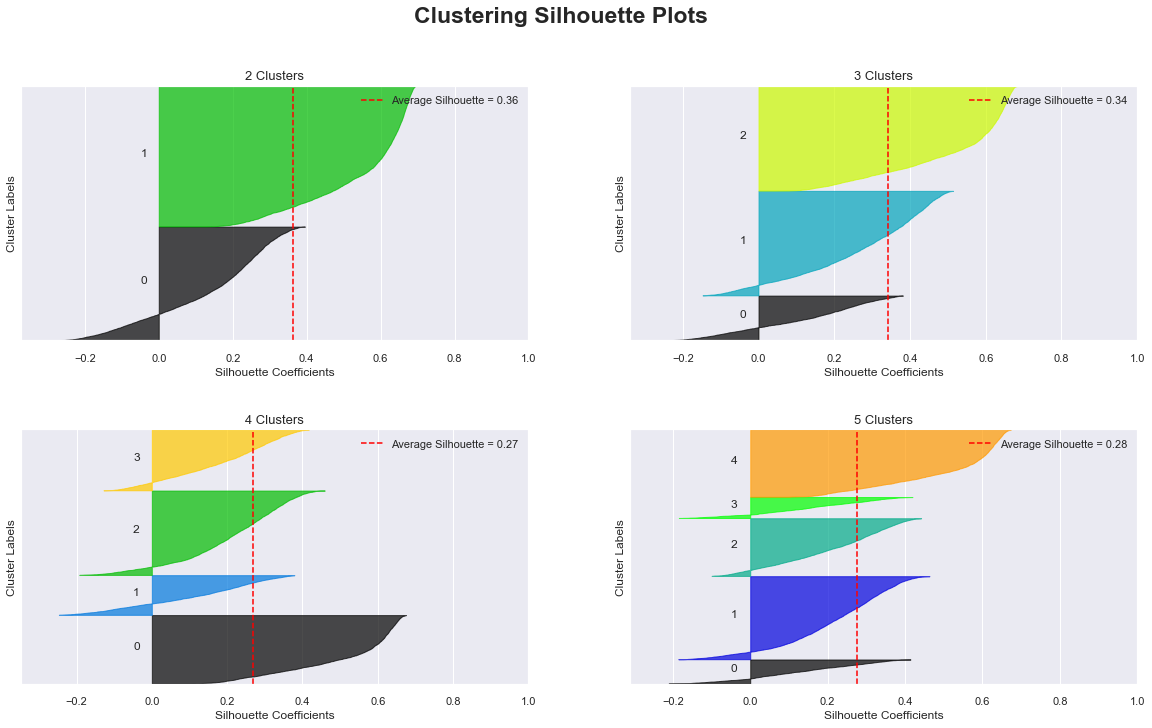

In [75]:
# Instantiate a scikit-learn K-Means model
clus_estim = KMeans(random_state=0)
# Produce silhouette_analysis
silhouette_analysis(prod_abs_std_df, clus_estim, (2,2), (20,11), max_nclus=6)

We also produced the Silhouette Plots to compare the quality between different number of clusters. Once again we can see that the 3 clusters solution performs slightly better relative to the rest. We can also see that our 3 clusters solution isn't the best since we have negative silhouette samples and for this reason, the clustering approach can be improved.

In [76]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(prod_abs_std_df, 3)
kmeans_prod_abs_std_df = prod_abs_std_df.copy()
kmeans_prod_abs_std_df["kmeans_abs_labels"] = clust_labels

#### Proportion Product

In [77]:
# Get data for clustering
# Standardize input data because we want every one of them to have the same importance
scaler = prep.StandardScaler()
prod_prop_std_df = pd.DataFrame(scaler.fit_transform(prod_prop_df), index=prod_prop_df.index, columns=prod_prop_df.columns)

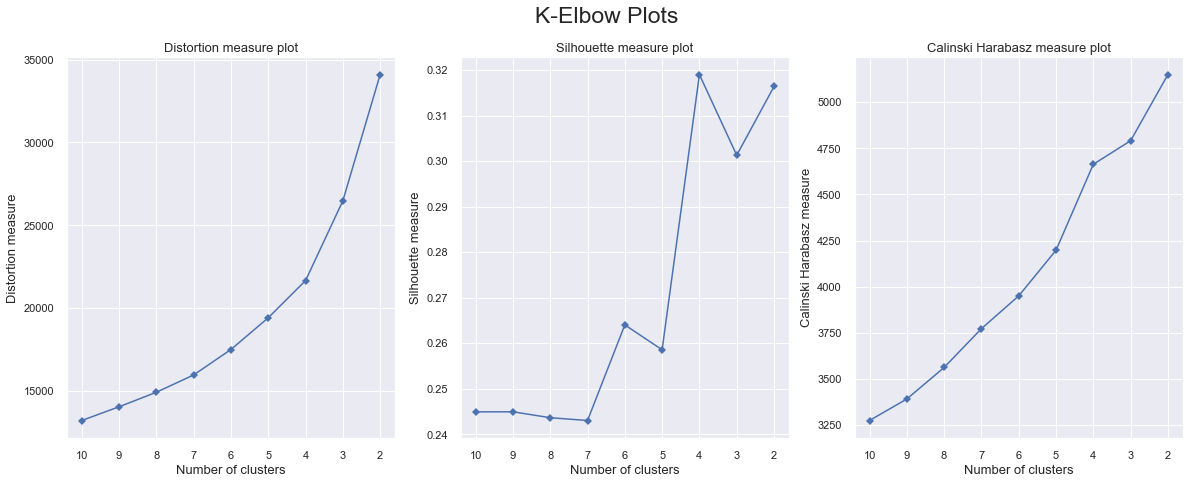

In [78]:
# Instantiate a scikit-learn K-Means model
clus_estim = KMeans(random_state=0)
# K-elbow plots
kelbowplots(clus_estim, prod_prop_std_df)

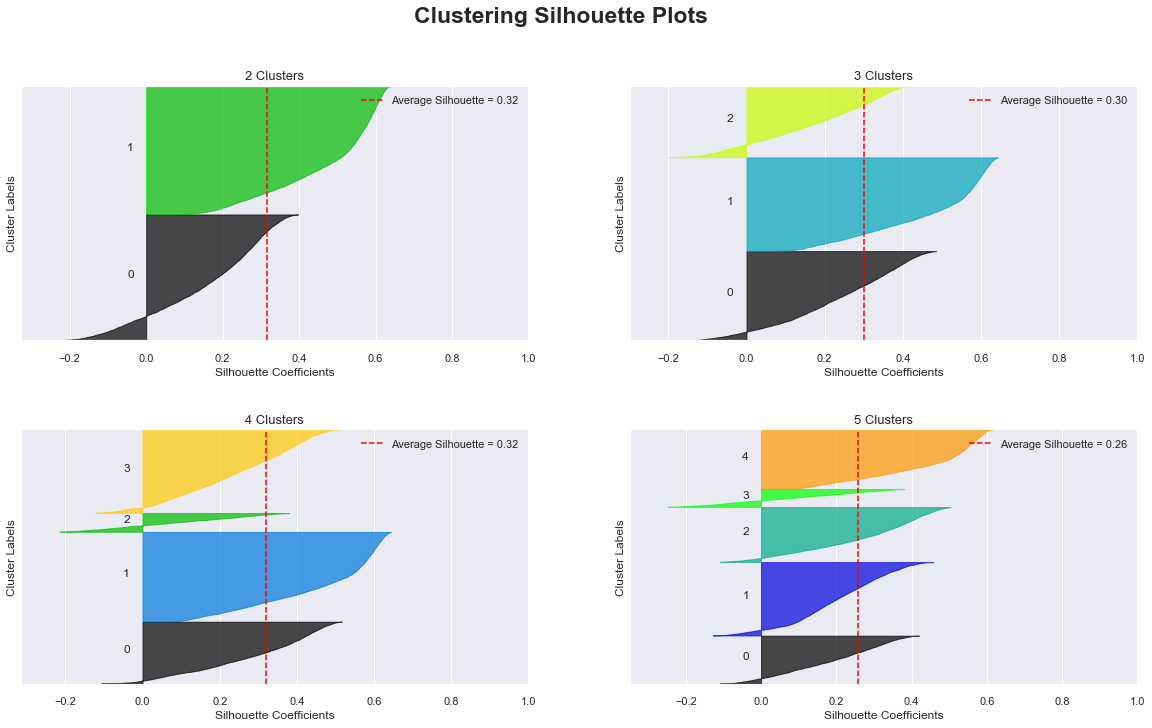

In [79]:
# Instantiate a scikit-learn K-Means model
clus_estim = KMeans(random_state=0)
# Produce silhouette_analysis
silhouette_analysis(prod_prop_std_df, clus_estim, (2,2), (20,11), max_nclus=6)

Once again we can visualize the silhouettes and the elbow plots. This will become a routine when having to decide how many clusters to retain. 

In this case the 4 cluster solution seems more appropriate, since it produces a better average silhouette score than the 3 clusters solution. Besides, there seems to be an elbow at the 4 clusters in the Distortion measure plot.

In [80]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(prod_prop_std_df, 4)
kmeans_prod_prop_std_df = prod_prop_std_df.copy()
kmeans_prod_prop_std_df["kmeans_prop_labels"] = clust_labels

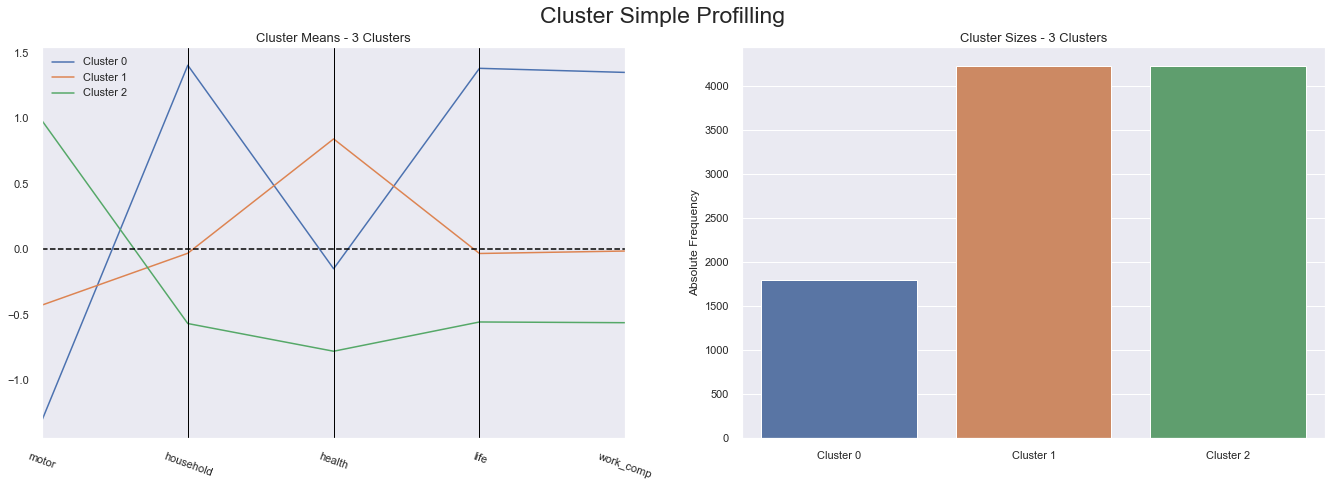

In [81]:
cluster_profiles(kmeans_prod_abs_std_df, ["kmeans_abs_labels"], figsize=(23, 7))

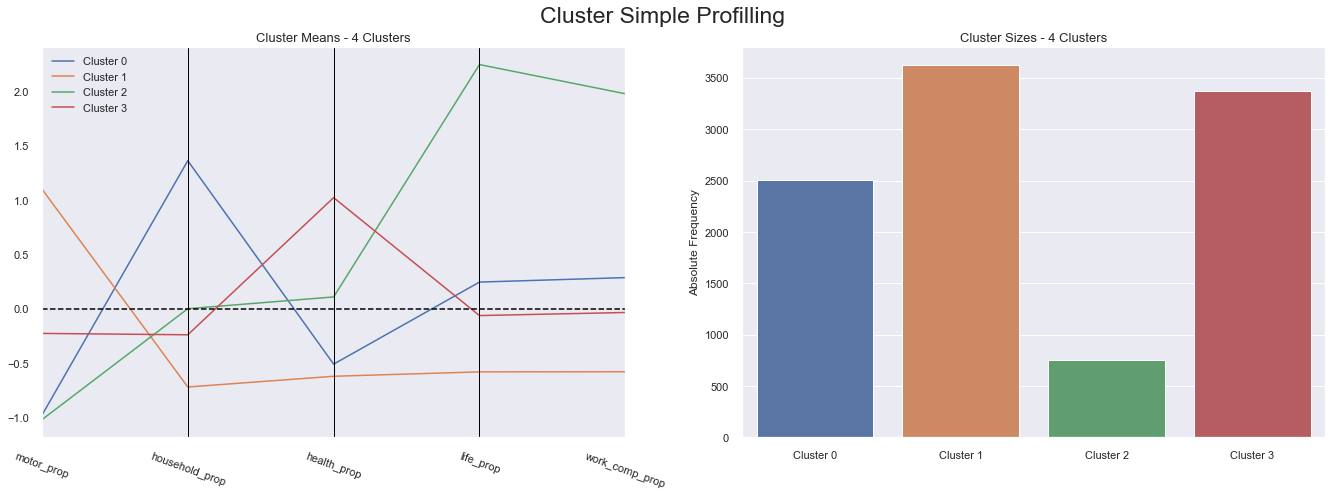

In [82]:
cluster_profiles(kmeans_prod_prop_std_df, ["kmeans_prop_labels"], figsize=(23, 7))

After comparing the results of a simple K-Means on the absolute value product data and on the proportional product data, we realised that both approaches provide valuable results that make sense in the business context. However, we noticed that in the proportion approach the correct number of clusters to retain is 4, whereas in the absolute approach it is 3. This difference can be attributed to the use of proportions, which point out a small cluster of clients that even though doesn't spend an absurd amount in life and work_comp, the proportion of the total amount spent in these two LOBs is very large.

We believe this smaller cluster is important and that the use of proportions is beneficial for the analysis since it provides a more pure view of the customers behaviour regarding the products. As a final decision, we opted to perform the Product Segmentation based on the proportion data.

### 4.4.2 - K-Means + Hierarchical Clustering (HC)

After deciding to use the proportional product data, we are now going to apply some clustering approaches that we fing appropriate. 

In this section we will apply the K-means algorithm together with the Hierarchical clustering algorithm. The K-means algorithm is a very fast and efficient way to perform segmentation, that often provides fairly good results. However, this algorithm has a disadvantage: it requires the number of clusters to be defined apriori. The Hierarchical clustering algorithm is a greedy/ local algorithm that can become heavy for large amounts of data and that often provides a suboptimal solution. Regardless its disadvantages, the HC algorithm is used because it doesn't require a pre-defined number of clusters. 

We can see that the algorithms complement each other and that, if used together, provide a fast, easy and efficient way to perform segmentation. We will first perform a k-means with k++ initialization in order to reduce the number of observations to a smaller number (e.g. 100) and then we will perform HC to find out the appropriate cluster solution, without having to define the number of clusters.

In [83]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(prod_prop_std_df, 100)
kmeans_clusters = prod_prop_std_df.copy()
kmeans_clusters["kmeans_prop_labels"] = clust_labels

With the K-means clustering done and the 100 clusters found, we will proceed to further segment the observations into a smaller number of clusters by applying HC.

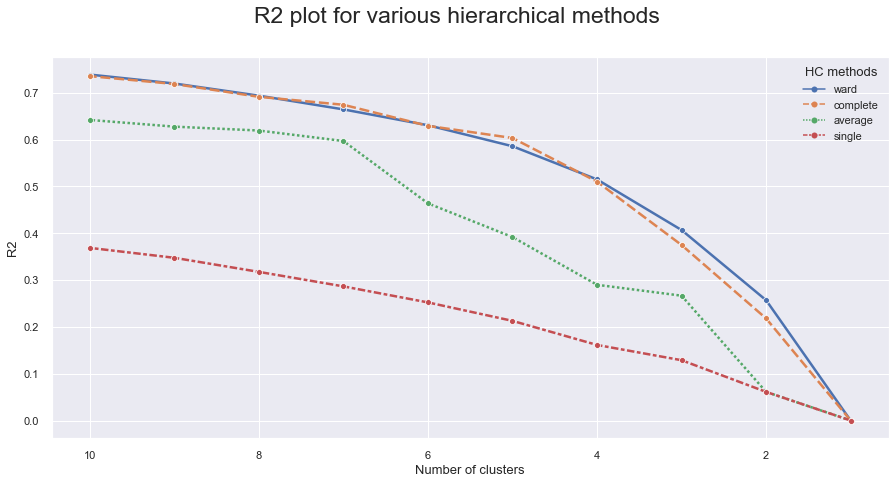

In [84]:
# Getting the centroids of each cluster given by the K-means
kmeans_clusters = kmeans_clusters.groupby("kmeans_prop_labels").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=kmeans_clusters, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

From the plot above, it is possible to compare the performance of the various Hierarchical Clustering methods (i.e. ward, complete, average and single) according to the R2 measure of clustering quality.The R2 measure is the ratio between the SSw and SSt and represents the homogeneity within the clusters of a given cluster solution.

The better the cluster solution, the highest the R2 will be, therefore, methods with higher R2 over different number of clusters will perform better for a given problem. In this case it can be seen that the ward's method outperforms the other methods and therefore should be used for linking the clusters.

Even though we were able to choose the most adequate method, we still don't know how many clusters to choose. For that reason, we will produce some visualizations that can help us with this task.

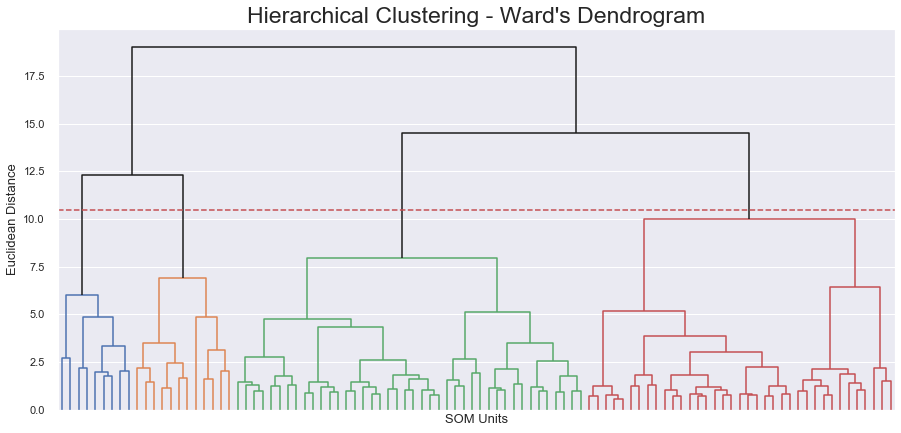

In [85]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(kmeans_clusters, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=10.2, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(10.5, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

Here we can visualize the Hierarchical clustering process through the Dendrogram. The Dendrogram not only provides a view of the clustering process but it also allows the analyst to select a cut-off point that defines the number of clusters to retain. 

In the above Dendrogram we can consider the first "big jump" to appear when the green and red cluster are merged. This indicates that these are farther away from each other than the clusters which were previously merged and therefore the analyst should stop the merging of these two clusters since it would form a dissimilar segment of customers. By applying the cut-off at this point, the clustering approach would retain 4 clusters.

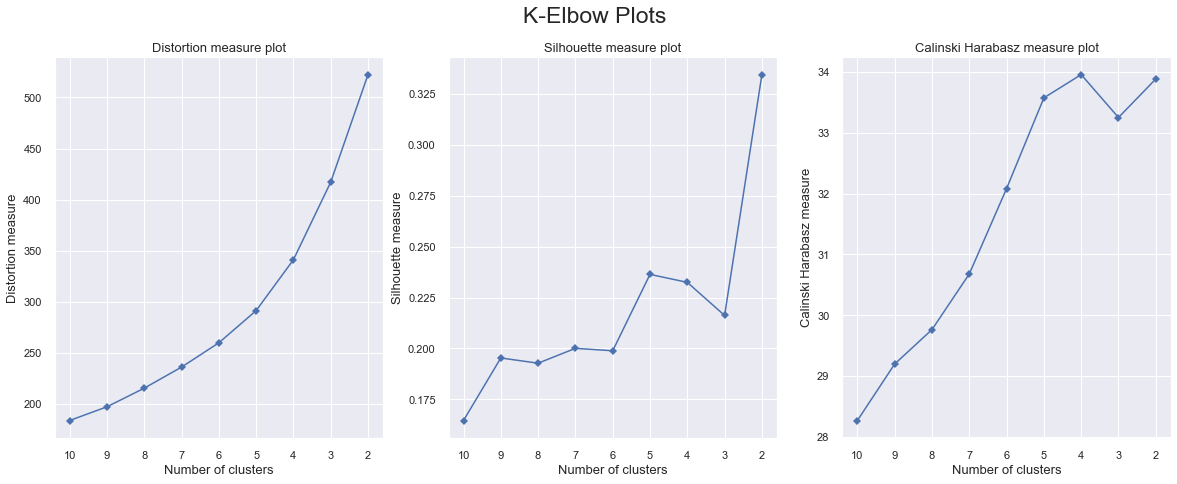

In [86]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Hclustering = AgglomerativeClustering(linkage=HCM)
# K-elbow plots
kelbowplots(Hclustering, kmeans_clusters)

Furthermore, the elbow plots were used in this case to select the appropriate number of clusters. However, it doesn't seem to appear an obvious choice regarding the number of clusters to retain from these visualizations.

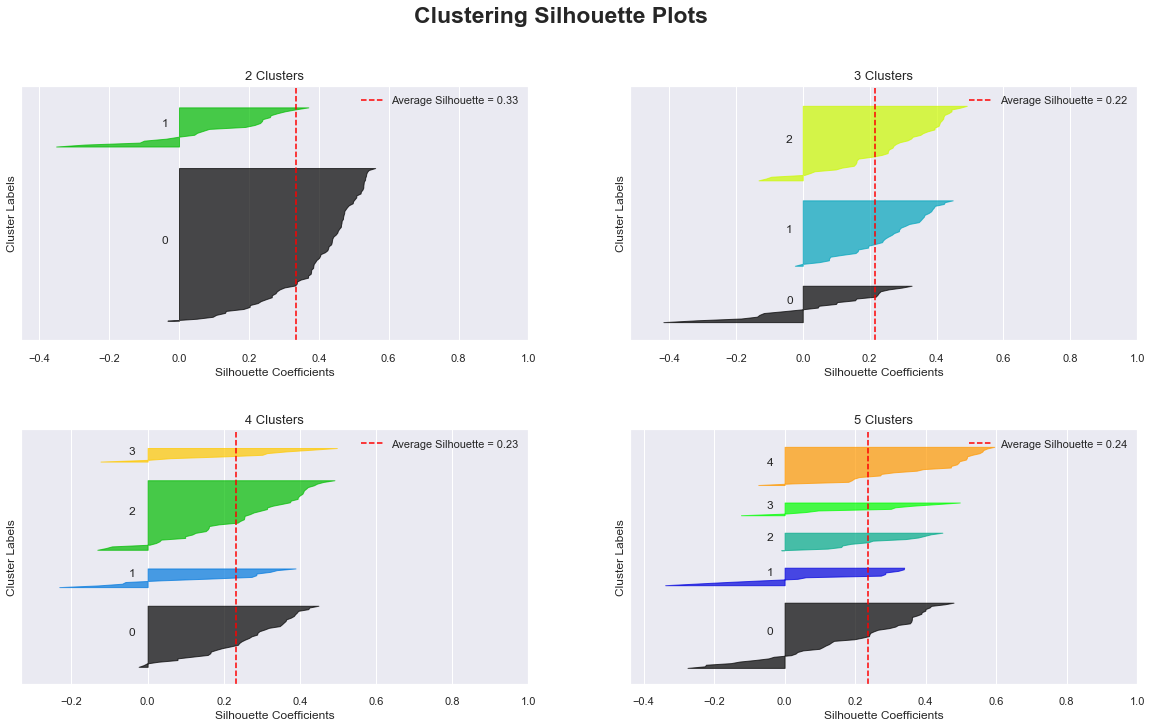

In [87]:
# Function defined above
estimator = AgglomerativeClustering(affinity="euclidean", linkage=HCM)
silhouette_analysis(kmeans_clusters, estimator, (2,2), (20, 11), 5)

Finally, we also performed a silhouette analysis to identify the number of clusters to retain. Right away we can see that the K-means + HC approach underperforms the simple K-means approach in terms of Silhouette Score (0.32 vs 0.23). Besides, there doesn't seem to exist a very good solution except the 2 clusters solution. However, we think that this is because of the clustering approach used and it doesn't reflect the true customer clusters since we saw in the simple K-means that a 4 clusters solution was valid and made sense.

### 4.4.3 - Gaussian Mixture Model (GMM)
We will also experimented using the GMM to segment the customers according to the product behaviour.

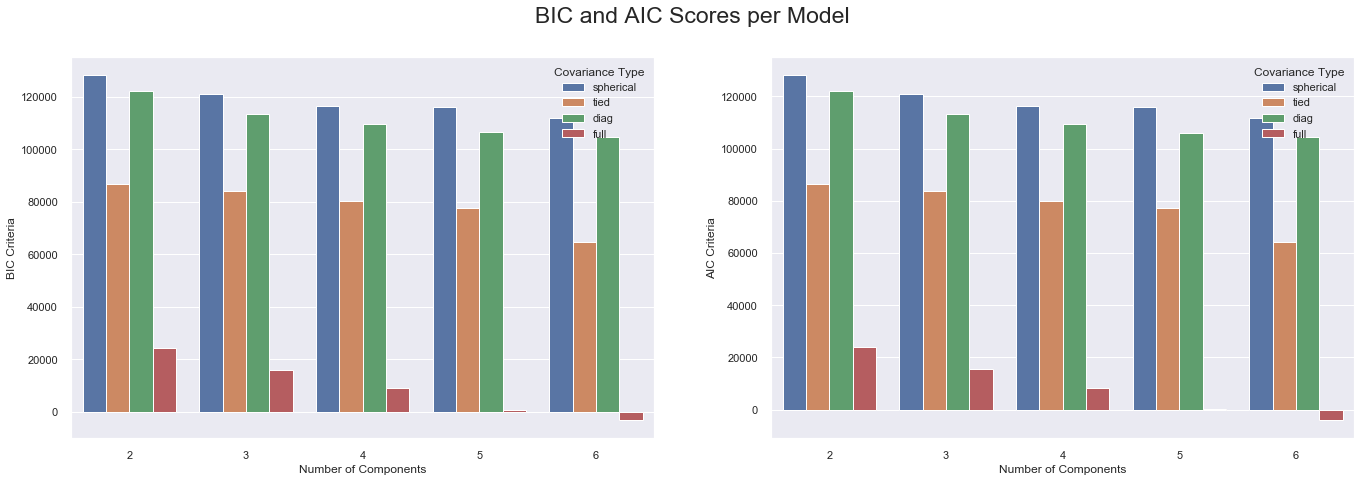

In [88]:
# Use the function built to choose the best GMM configuration
comp_gmm_models(prod_prop_std_df, 6)

From the plot above we can compare how the BIC and AIC criterias compare across different number of clusters and different covariance types. It is clear that the "full" covariance type outperforms the others since its value in both criterias is lower across all number of clusters. 

We will then use the "full" covariance type but first we will investigate what it the appropriate number of clusters to retain.

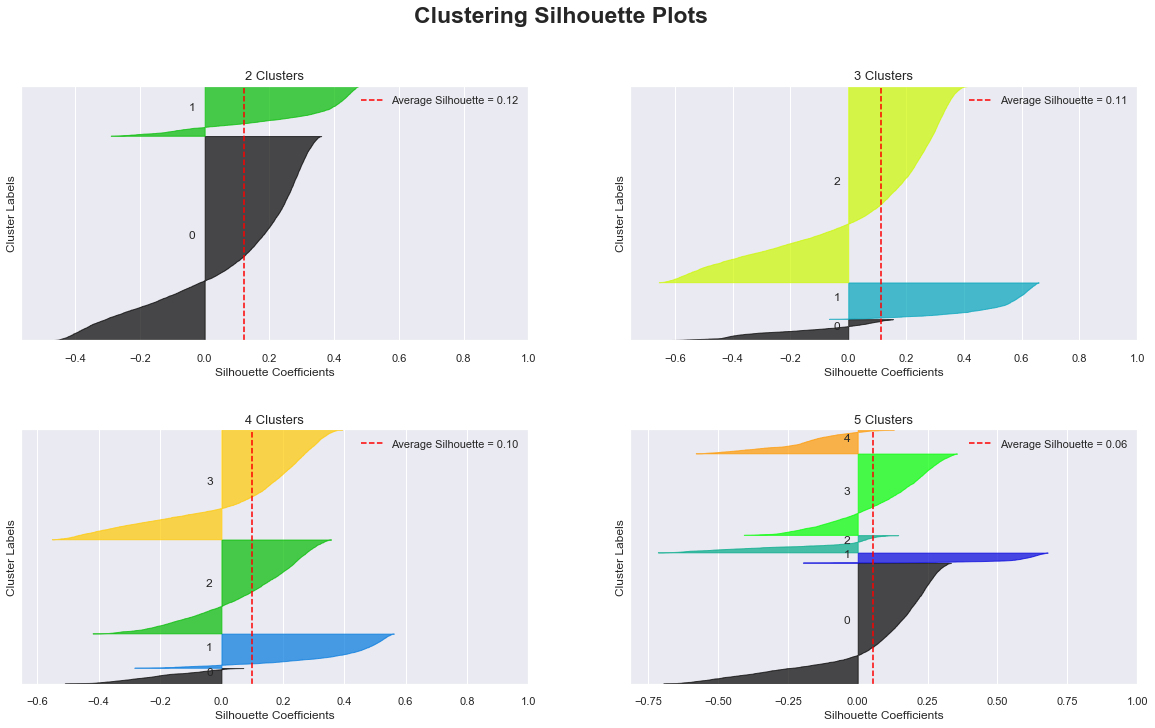

In [89]:
# Function defined above
estimator = GaussianMixture(random_state=0, n_init=10)
silhouette_analysis(prod_prop_std_df, estimator, (2,2), (20, 11), 5)

The silhouette analysis on the GMM suggest that this algorithm produces very poor clustering solutions in which there's a lot of "wrongly" assigned observations to each cluster.

We start to think that maybe the GMM clustering isn't the best for the data that we have or that the silhouette coefficient doesn't represent very well the quality of the GMM clusters.

In [90]:
# Performing gmm and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels = doGMM(prod_prop_std_df, 3)
gmm_clusters = prod_prop_std_df.copy()
gmm_clusters["gmm_prop_labels"] = clust_labels

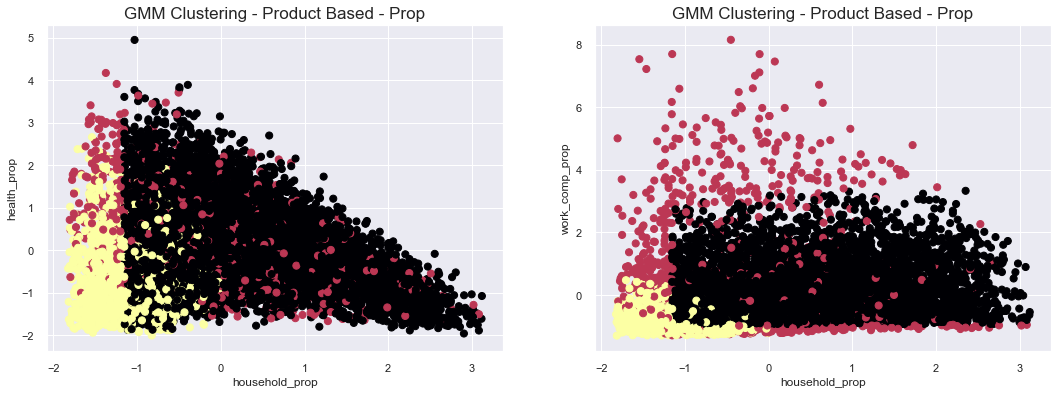

In [91]:
# let´s observe the results of the GMM with the variables we have used previously as a comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.scatter(gmm_clusters['household_prop'], gmm_clusters['health_prop'],
                     c=gmm_clusters['gmm_prop_labels'], s=50, cmap='inferno')

ax2.scatter(gmm_clusters['household_prop'], gmm_clusters['work_comp_prop'],
                     c=gmm_clusters['gmm_prop_labels'], s=50, cmap='inferno')

ax1.set_title('GMM Clustering - Product Based - Prop', fontsize=17)
ax1.set_xlabel('household_prop')
ax1.set_ylabel('health_prop')

ax2.set_title('GMM Clustering - Product Based - Prop', fontsize=17)
ax2.set_xlabel('household_prop')
ax2.set_ylabel('work_comp_prop')

plt.show()

We can additionaly see that the GMM isn't able to separate the clusters at least in these two projections of the multi-dimensional space.

### 4.4.4 - Self-Organizing Maps (SOM) + Hierarchical Clustering (HC)

We decided to experiment with the combination of these two algorithms since SOM provides a powerful clustering algorithm which suffers from having to be parameterized, namely when it comes to defining the grid of units that will cover the feature space. On the other hand, Hierarchical clustering is a simple but greedy algorithm which doesn't need to be parameterized. In this sense, we will perform SOM with a big grid of neurons which will then be grouped with HC in order to find the appropriate number of clusters and a adequate solution.

In [92]:
#Producing SOM clustering based on proportional product data
sm = SOMFactory().build(data=prod_prop_std_df.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        random_seed=8, # new random seed parameter for reproducibility
                        component_names=prod_prop_std_df.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=4,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

#Obtaining SOM's BMUs labels
som_prop_std_df = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=prod_prop_std_df.index, columns=np.append(prod_prop_std_df.columns,"labels_som"))

print("SOM quantization error: {0:.3f}".format(sm.calculate_quantization_error()))

SOM quantization error: 0.317


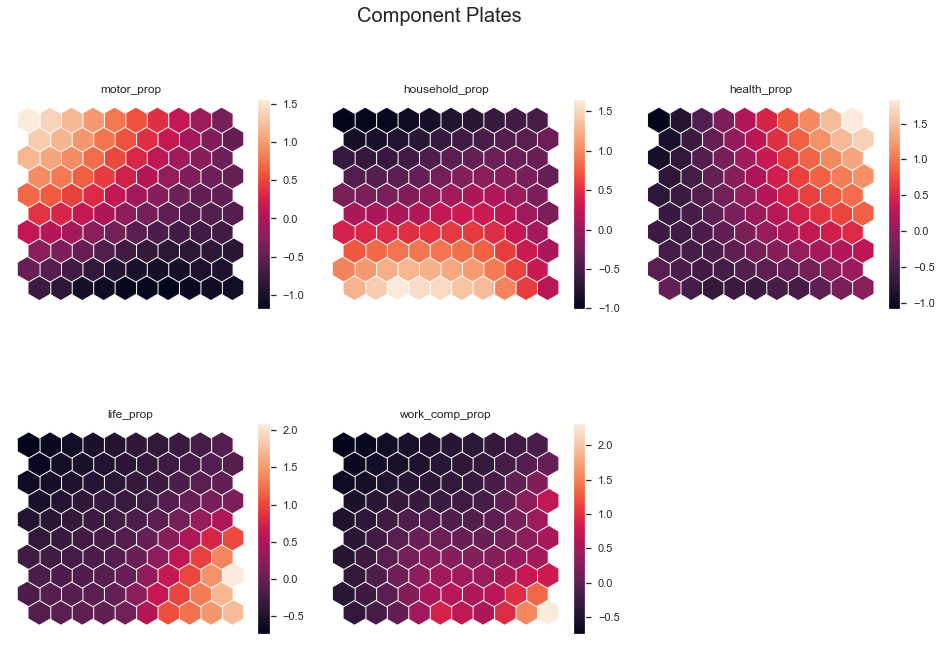

In [93]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(10,10,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

From our SOM solution we obtained the Component Plates above which reflect the distribution of the clustering variables along the grid of units. It is interesting to see that some of our findings in the exploratory research are confirmed here. We can see that the area covered by high values of motor_prop is also covered by low values on all other LOBs. Besides, high values on household_prop stand on a region with also high values on the life_prop and work_comp_prop, which confirms the correlation between household_prop and t_premiums.

Ahead we will proceed to group the units found by SOM with the help of the HC algorithm.

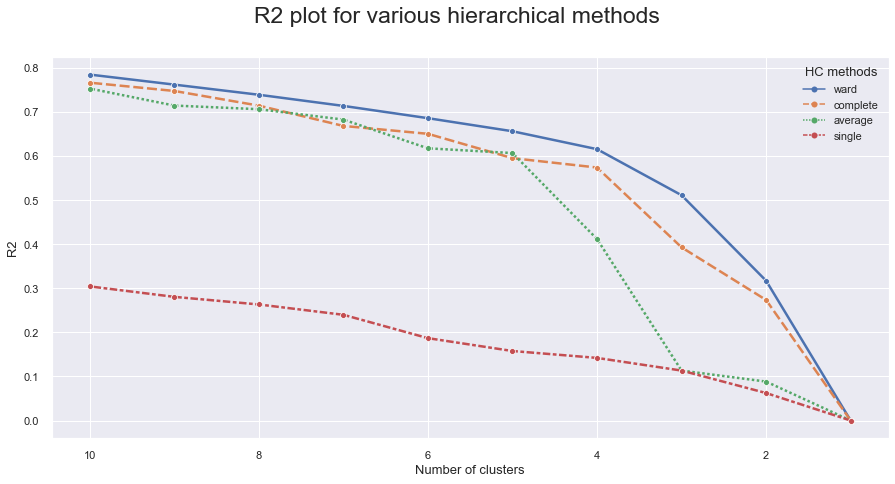

In [94]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = som_prop_std_df.groupby("labels_som").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=som_units, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

From the plot above, it is possible to compare the performance of the various Hierarchical Clustering methods (i.e. ward, complete, average and single) according to the R2 measure of clustering quality.The R2 measure is the ratio between the SSw and SSt and represents the homogeneity within the clusters of a given cluster solution.

The better the cluster solution, the highest the R2 will be, therefore, methods with higher R2 over different number of clusters will perform better for a given problem. In this case it can be seen that the ward's method outperforms the other methods and therefore should be used for linking the clusters.

Even though we were able to choose the most adequate method, we still don't know how many clusters to choose. The apparent elbow located at the 4 clusters in the R2 can be an indicative but we will produce some additional visualizations that can help us with this task.

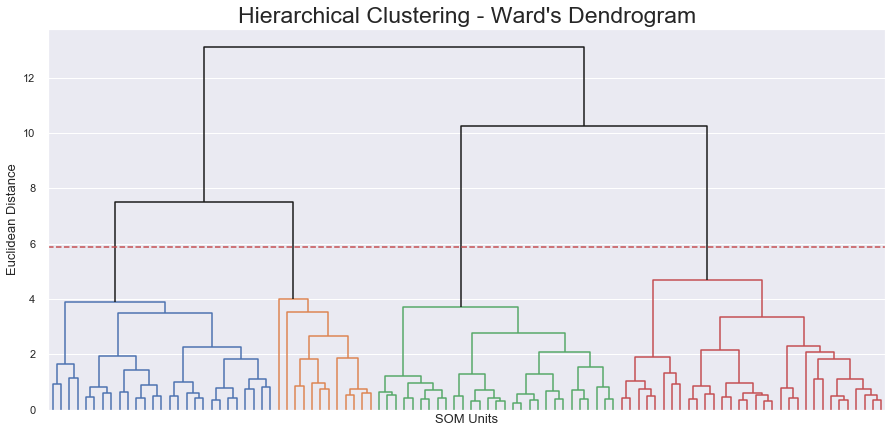

In [95]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(som_units, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=6, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(5.9, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

Here we can visualize the Hierarchical clustering process through the Dendrogram. It is clear that the first link with a reasonable distance is the one between the yellow and the blue clusters and therefore we will cut-off the procedure at this point to retain 4 clusters and avoid a potential large loss of intra-cluster homogeneity.

Before compromising with a 4 clusters we will use some other methods to define the number of clusters to retain.

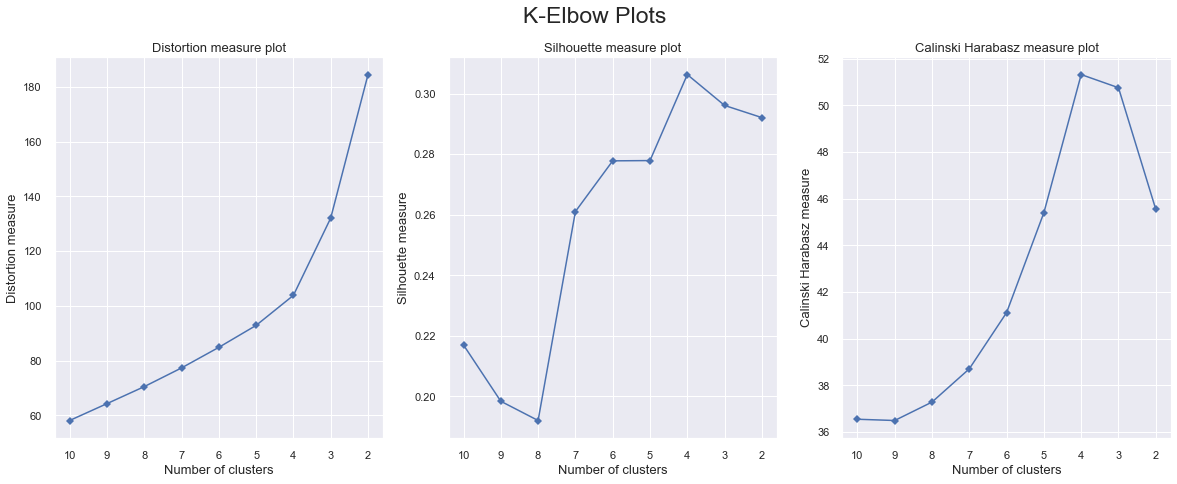

In [96]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Hclustering = AgglomerativeClustering(linkage=HCM)
# K-elbow plots
kelbowplots(Hclustering, som_units)

From the visualization above we can assess the quality of our decision and compare it with other options. In our opinion, it is clear that the right choice in this case is 4 clusters since all the 3 quality measure produce an elbow at the 4 clusters solution. This is an indication that our solution is relatively good.

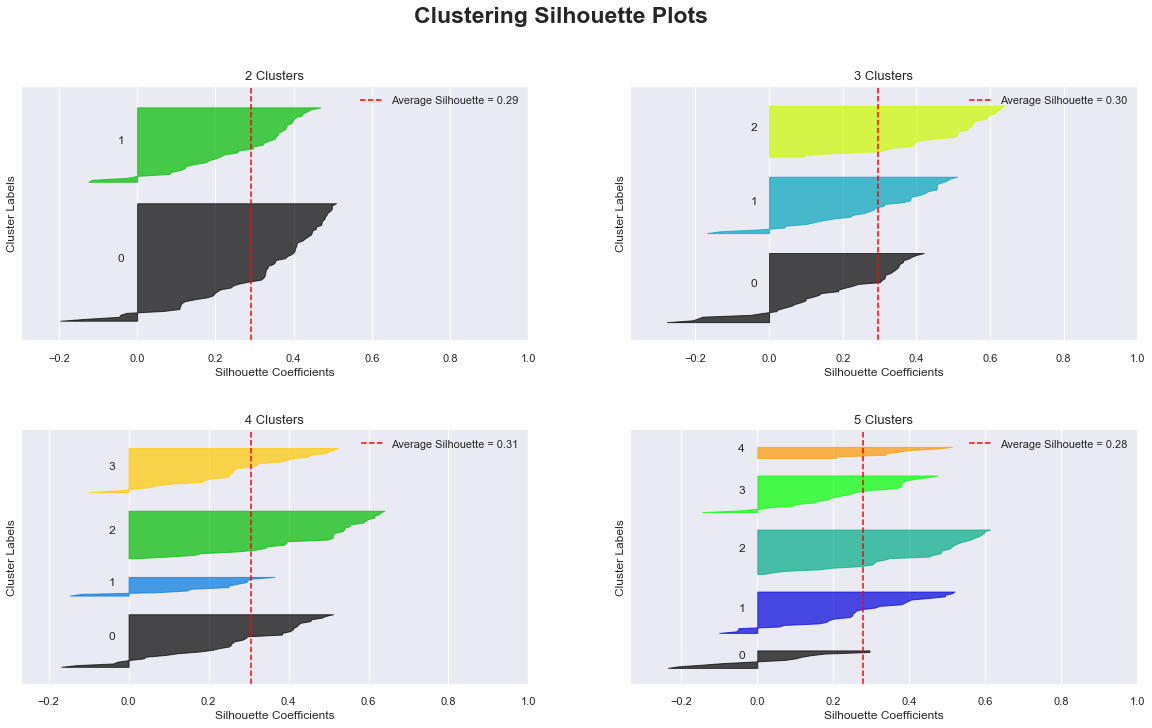

In [97]:
# Function defined above
estimator = AgglomerativeClustering(affinity="euclidean", linkage=HCM)
silhouette_analysis(som_units, estimator, (2,2), (20, 11), 5)

We also produced the Silhouette Plots to compare between different number of clusters. Once again we can see that the 4 clusters solution performs slightly better relative to the rest.

Also it is important to notice that we obtain few negative silhouette coefficients for the 4 clusters solution, meaning that a small number of observations is "wrongly" assigned, which is a clear improvement to the simple K-means clustering.

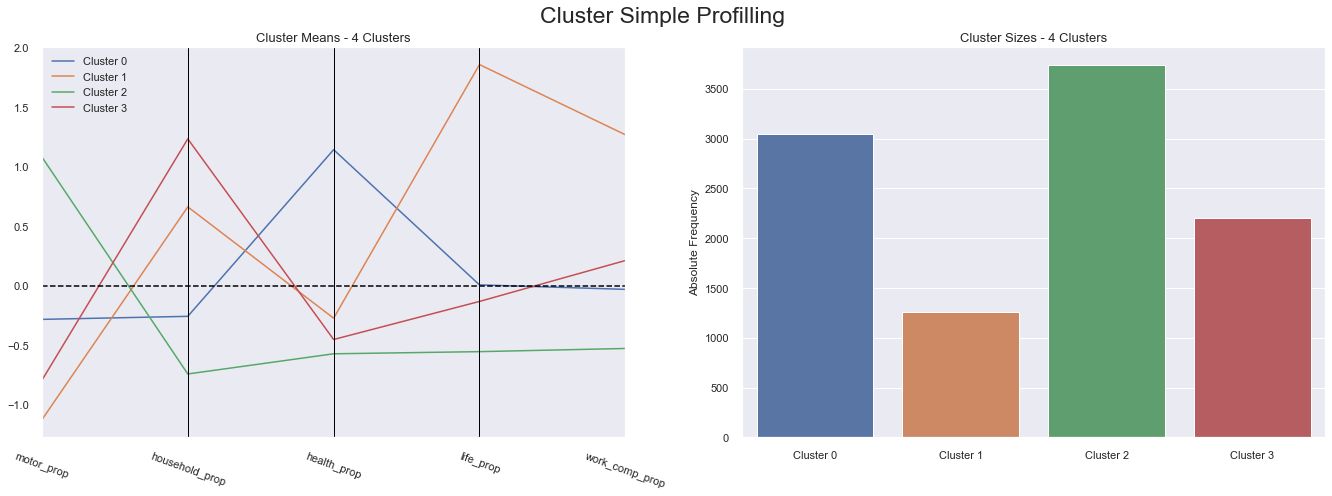

In [98]:
# Defining numbers of clusters
CLUSN = 4

# Hierarchical Clustering with sklearn
estimator = AgglomerativeClustering(n_clusters=CLUSN, linkage=HCM)
labels = estimator.fit_predict(som_units)

# Getting the HC labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_hc_4"]))

# Getting the HC labels for each observation in the main dataframe
som_hc_prop_std_df = som_prop_std_df.merge(right=som_units_hc.loc[:,"labels_som_hc_4"], 
                                           left_on="labels_som", right_index=True).sort_index()
# Cluster Simple Profilling
cluster_profiles(som_hc_prop_std_df.drop("labels_som", axis=1), ["labels_som_hc_4"], (23, 7))

By looking at the simple profilling of the clusters we can notice we have a cluster that stands out in motor_prop with a low value in all other LOBs (Cluster 2), this is also the cluster with the most customers. We also have a cluster with significant low value in household_prop and high values in life_prop and work_comp_prop (Cluster 1). Besides, Cluster 0 is characterized by having average values in all LOBs except health_prop, where it has the highest values of all clusters. Finally, Cluster 3, also performs around the mean in all LOBs but has a low value on motor_prop and a high value on household_prop.

### 4.4.5 - Self-Organizing Maps (SOM) + K-means
Considering the good results of the previous segmentation we decided to experiment with the SOM + K-means approach.

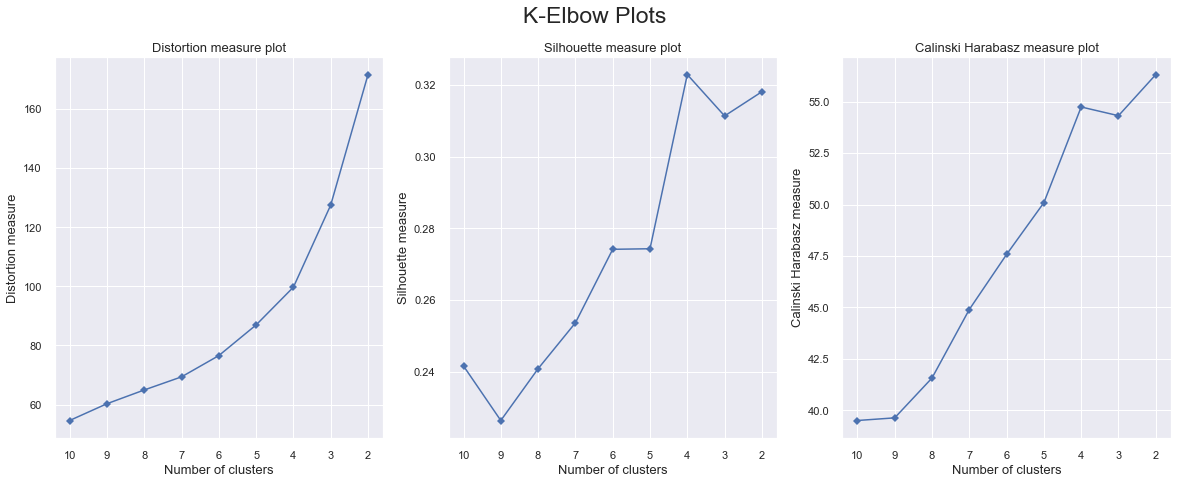

In [99]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Kmeans = KMeans(random_state=0)
# K-elbow plots
kelbowplots(Kmeans, som_units)

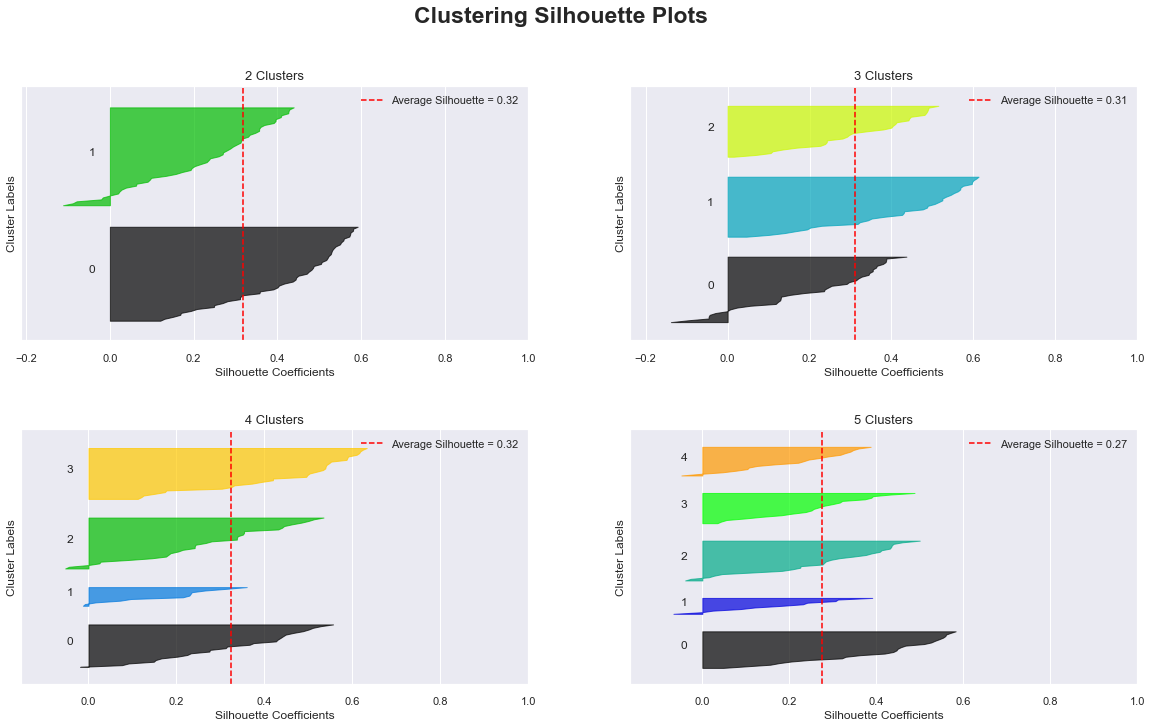

In [100]:
# Function defined above
estimator = KMeans(random_state=0)
silhouette_analysis(som_units, estimator, (2,2), (20, 11), 5)

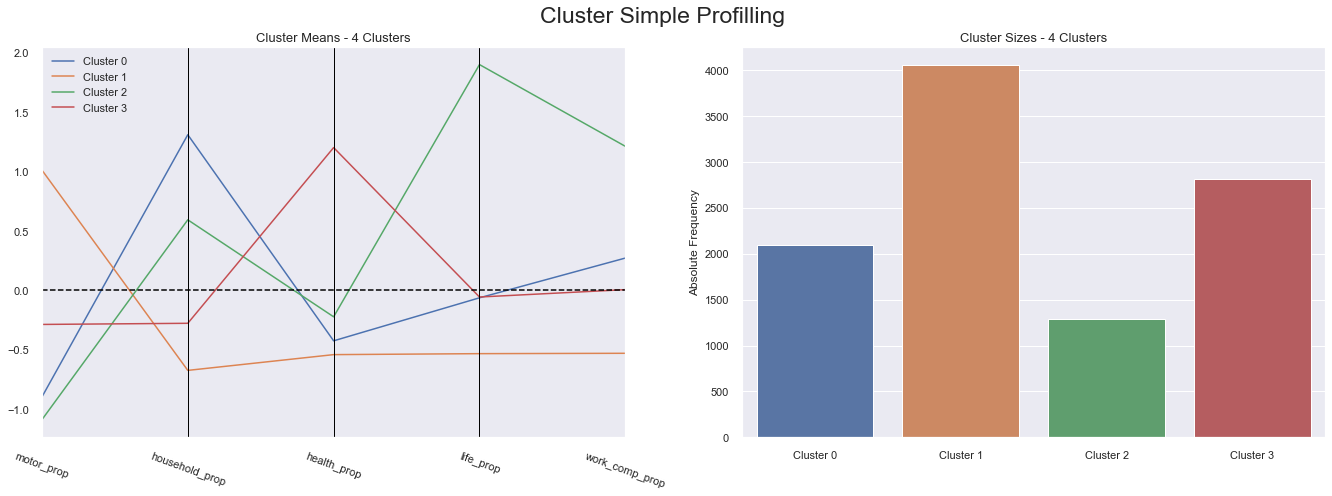

In [101]:
# Defining numbers of clusters
CLUSN = 4

# KMeans with sklearn
estimator = KMeans(n_clusters=CLUSN)
labels = estimator.fit_predict(som_units)

# Getting the KMeans labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_kmeans_4"]))

# Getting the KMeans labels for each observation in the main dataframe
som_kmeans_prod_prop_df = som_prop_std_df.merge(right=som_units_hc.loc[:,"labels_som_kmeans_4"], 
                                           left_on="labels_som", right_index=True).sort_index()
# Cluster Simple Profilling
cluster_profiles(som_kmeans_prod_prop_df.drop("labels_som", axis=1), ["labels_som_kmeans_4"], (23, 7))

As we have realised from the analysis above, the SOM + K-means slightly outperforms the SOM + HC, in terms of Distortion, Silhouette and Calinski Harabasz scores. Despite this improvement, the results remain fairly identical as well as the interpretation of the clusters. **Therefore we will employ the SOM + K-means procedure to segment the customers according to the product behaviour as this approach produces the best results.**

Below we will do an in depth profiling of the cluster solution using not only the clustering variables but also the remaining variables for characterization:

In [102]:
# First let's build a final dataset that we can append the final cluster labels as well as having the variables need to interpret the clusters
# One-hot encode categorical variables
cat_df = df.select_dtypes("object")
ohe = prep.OneHotEncoder()
concat_list = []
for i in cat_df.columns:
    concat_list.append(ohe.fit_transform(cat_df[i].values.reshape(-1,1)).toarray())
    
cat_ohe_df = pd.DataFrame(np.concatenate(concat_list, axis=1), index=cat_df.index, columns=["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"])
final_df = pd.concat([df, cat_ohe_df], axis=1)

# Appending final product cluster labels to final_df
final_df["prod_som_kmeans_4cl"] = som_kmeans_prod_prop_df["labels_som_kmeans_4"]

The Chi-square test of independence has a p-value of 0.00
The proportion of Inertia retained with 2 dimensions is 0.50


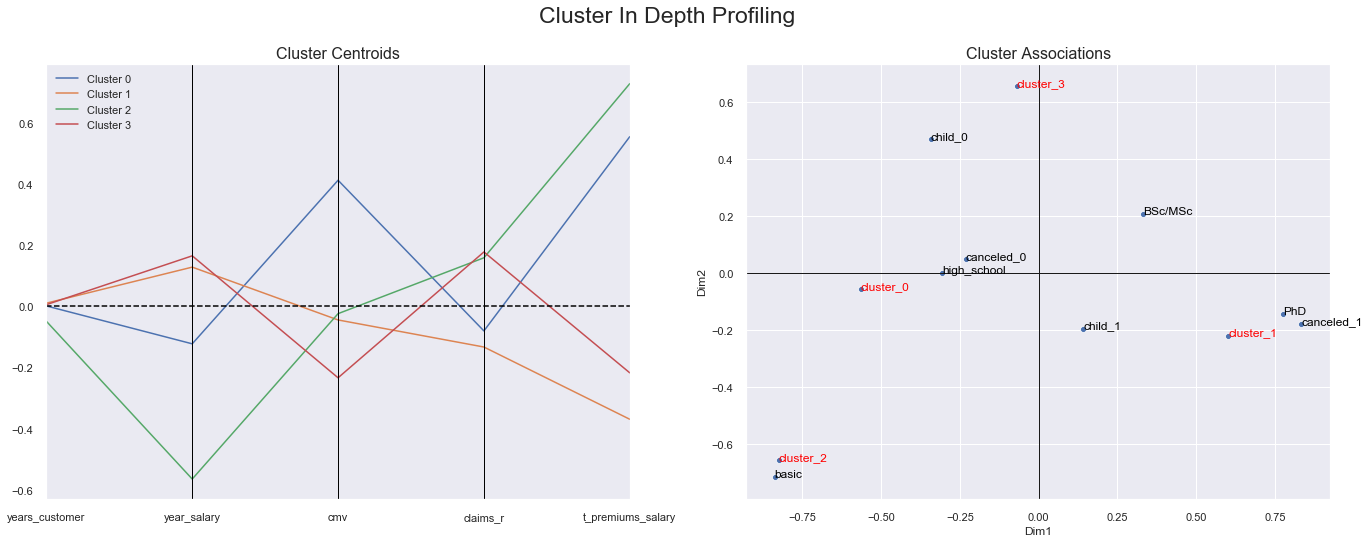

In [103]:
# Data - paralel coordinates
parallelc_df = final_df.drop(["educ_enc", "children", "motor", "household", "health", "life", "work_comp", 
                                    "annual_profit", "t_premiums", "basic", "high_school", "BSc/MSc", "PhD", 
                                    "canceled", "child_0", "child_1", "canceled_0", "canceled_1", "motor_prop",
                                    "household_prop", "health_prop", "life_prop", "work_comp_prop"], axis=1)

scaler = prep.StandardScaler()  # Standardizing the variables
parallelc_df = pd.DataFrame(np.append(scaler.fit_transform(parallelc_df.drop("prod_som_kmeans_4cl", axis=1)),
                                                np.expand_dims(parallelc_df["prod_som_kmeans_4cl"].values, axis=1), axis=1),
                                      index=parallelc_df.index, columns=parallelc_df.columns)

centroids = parallelc_df.groupby(by="prod_som_kmeans_4cl", as_index=False).mean()

# Data - mca
ohe = prep.OneHotEncoder()  # One-hot encode cluster labels
cluster_labels = pd.DataFrame(ohe.fit_transform(final_df["prod_som_kmeans_4cl"].values.reshape(-1,1)).toarray(),
                              index=final_df.index, columns=["cluster_0", "cluster_1", "cluster_2", "cluster_3"])

mca_df = cluster_labels.merge(final_df.loc[:, ["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"]],
                              left_index=True, right_index=True)

row_scores, _ = correspondence_analysis(mca_df, mca=True)  # Correspondence Analysis - we only need either the row or column scores as rows and columns are the same in a Burt table
mca_cord = pd.DataFrame(row_scores, index=["cluster_0","cluster_1","cluster_2", "cluster_3","basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"],
                         columns=["Dim1", "Dim2"])
# Figure
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))

# Traces
pd.plotting.parallel_coordinates(centroids, "prod_som_kmeans_4cl", color=sns.color_palette(), ax=ax1)
sns.scatterplot(x="Dim1", y="Dim2", data=mca_cord, ax=ax2)
for i in mca_cord.index:
    if "cluster" in i:
        ax2.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='red')
    else:
        ax2.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='black')

#Layout
handles, _ = ax1.get_legend_handles_labels()
cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
ax1.legend(handles, cluster_labels)
ax1.axhline(color="black", linestyle="--")
ax1.set_title("Cluster Centroids", fontsize=16)
ax2.axhline(y=0, color='k', linewidth=1)
ax2.axvline(x=0, color='k', linewidth=1)
ax2.set_title("Cluster Associations", fontsize=16)
plt.suptitle("Cluster In Depth Profiling", fontsize=23)

plt.show()

Above we can visualize the usual parallel coordinates plot for the metric variables that weren't used in the product segmentation. Besides, a perceptual map of the correspondence analysis between the cluster labels and the categorical features presents a way to interpret the associations between each cluster and categorical variables' modalities. We can interpret the perceptual map by looking at the angles between vectors of each modality. If the angle is acute as for example in cluster_2 and basic, then there's positive association. An obtuse angle indicates negative association and a right angle indicates no association.

From the previous analysis and visualizations we can extract some relevant information regarding each cluster. Following, we characterize and attribute a label to each cluster:

* **Cluster_0 - High Household and Low Motor Spenders**: The main characteristics of this cluster is their high spend rate on household policies and their low spend rate on motor policies. They reveal the highest customer monetary value (cmv) and the second highest proportion of salary spent in the company’s products. They seem associated with non cancelation and with an High School level of education. Their relative size is around 2000 customers;

* **Cluster_1 - High Motor Spenders**: This cluster’s main characteristic is that they don't buy anything else but motor insurance and they are the biggest spenders on it. If we analyze the other variables we discover that their salary is the second highest in average, have the lowest claims rate and are the clients that spend the least proportion of their salary in the company. From the correspondence analysis we see a high association rate of this cluster with PhD level of education and a high level of cancellations. This is the biggest segment with around 4000 clients;

* **Cluster_2 - High Life and Work Compensation Spenders**: The main characteristics of this cluster is their high spend rate on life and work compensation and they are the lowest spenders on motor’s policies. Further analysis reveals that they receive the lowest average salary and their claims rate is fairly high. They are the one’s spending the highest proportion of their salary on the company. Regarding non metric variables they reveal a high association with Basic Education. This is the smallest cluster with roughly 1300 clients;

* **Cluster_3 - High Health Spenders**: The main characteristics of this cluster is their high spend rate on health policies. They receive the highest average salary, reveal the lowest customer monetary value (cmv), from the highest claims rate coupled with the second lowest percentage of income spent in the company. They seem to be associated with being childless, being a segment of roughly 2800 customers. 

## 4.5: Customer Segmentation

In this section we will find what are the groups of customers according to their socio-economic characteristics and value. This will allow us to understand how the customer value relates to the demographics of the customers. Since we will be dealing with mixed data type variables, we will need to adopt approaches that are able to use the information present in both metric and non-metric features.

### 4.5.1 - K-prototypes

The K-prototypes is a clustering algorithm that enables clustering based on mixed data type variables. As defined by Z. Huang (1998), the K-prototypes "integrates the k-means and k-modes algorithms to allow for clustering objects described by mixed numeric and categorical attributes". This is particularly useful in our situation since we are dealing with both numeric and categorical variables that contain relevant information, as seen in the data exploration section.

In [104]:
# Standardize metric data because we want every one of them to have the same importance
metric_df = custom_df.select_dtypes("float64")
scaler = prep.StandardScaler() # Standardizing metric variables
metric_df = pd.DataFrame(scaler.fit_transform(metric_df), index=metric_df.index, columns=metric_df.columns)
cat_df = custom_df.select_dtypes("object")
custom_std_df = pd.concat([metric_df, cat_df], axis=1) # Will be used in K-prototypes

# One-hot encode categorical variables
ohe = prep.OneHotEncoder()
concat_list = []
for i in cat_df.columns:
    concat_list.append(ohe.fit_transform(cat_df[i].values.reshape(-1,1)).toarray())
    
cat_ohe_df = pd.DataFrame(np.concatenate(concat_list, axis=1), index=cat_df.index, columns=["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"])
custom_std_ohe_df = pd.concat([metric_df, cat_ohe_df], axis=1) # Will be used in K-means and for Correspondence Analysis

In [105]:
def get_cost_kproto(df, init, cat_index, rnd_state, max_nclus, min_nclus=1, n_init=1):
    """
    The Cost measure is one of the attributes of the KPrototypes estimator. It gives the sum of the distances from each observation to the closest centroid.
    It can be seen as a measure of cluster quality since the distance of each observation to the assigned cluster centroid should be minimal in order to get
    homogeneous clusters. This function compares the Cost measure over a range of cluster solutions given a specific initialization method.
    """
    
    cost = np.array([]) #where we will store the cost metrics
    
    for i in range(min_nclus, max_nclus+1):
        Kproto = KPrototypes(n_clusters=i, init=init, n_init=n_init, random_state=rnd_state)
        labels = Kproto.fit_predict(df, categorical=cat_index) #get cluster labels
        cost = np.append(cost, Kproto.cost_)
        
    return cost

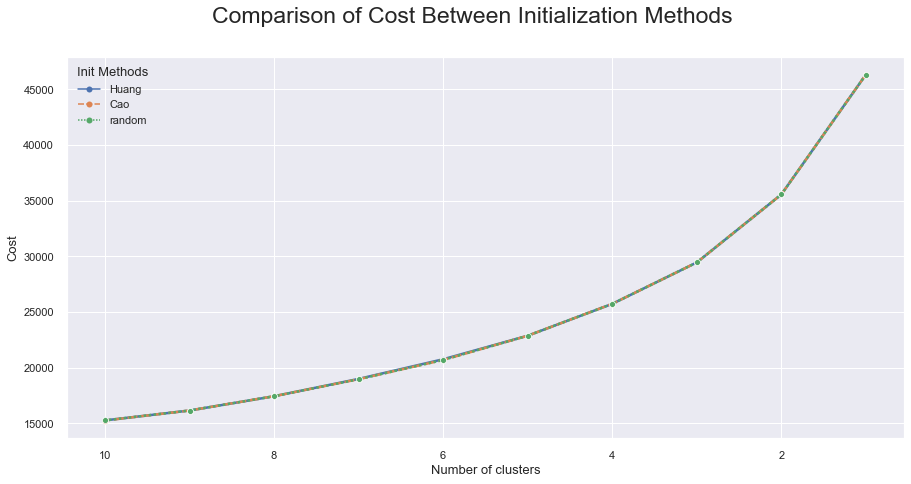

In [106]:
# THIS CELL IS VERY HEAVY TO RUN. IT PRODUCES THE PLOT BELOW. THEREFORE YOU CAN SKIP THE RUN OF IT.
# Prepare input
init_methods = ["Huang", "Cao", "random"]
# Function defined above 
kproto_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_cost_kproto(df=custom_std_df, init=i, cat_index=[4,5,6], rnd_state=0, 
                                                                                  max_nclus=10, min_nclus=1, n_init=10), 1) for i in init_methods], axis=1),
                              index=range(1,10+1), columns=init_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=kproto_methods, linewidth=2.5, markers=["o"]*3)

# Finalize the plot
fig.suptitle("Comparison of Cost Between Initialization Methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="Init Methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("Cost", fontsize=13)

# plt.savefig("./figures/cost_elbow.png") #saving figures since the data takes a while to produce
plt.show()

From the plot above one can visualize how the K-prototypes initializations perform comparing to each other, over the range of 10 to 1 clusters solutions. Furthermore, a n_init parameter with value of 10 ensures that the best solution over 10 runs is outputed in terms of cost, giving a more trustworthy comparison.

It looks that the initialization methods perform similarly in terms of cost, besides it is possible to spot a subtle elbow at the 3 clusters solution, which indicates that the marginal increase of cost is higher at this point and the number of clusters to retain should be 3.

We will proceed with the default initialization (Huang) since they are all identical in terms of performance. We will also opt for a 3 clusters solution given the elbow.

In [107]:
CLUSN = 3
# KPrototypes
Kproto = KPrototypes(n_clusters=CLUSN, n_init=10, random_state=0)
kp_labels = Kproto.fit_predict(custom_std_df, categorical=[4,5,6])

### 4.5.2 - K-Means
We also decided to perform a K-Means clustering based on the one-hot encoded categorical variables for comparison purposes. Even though this technique is based on euclidean distance, which is a continuous distance measure, and some of the variables we are using are binary, this is a widely adopted technique for mixed data type clustering because it yelds good results, despite the mathematical inadequacy of such a distance measure for this given scenario.

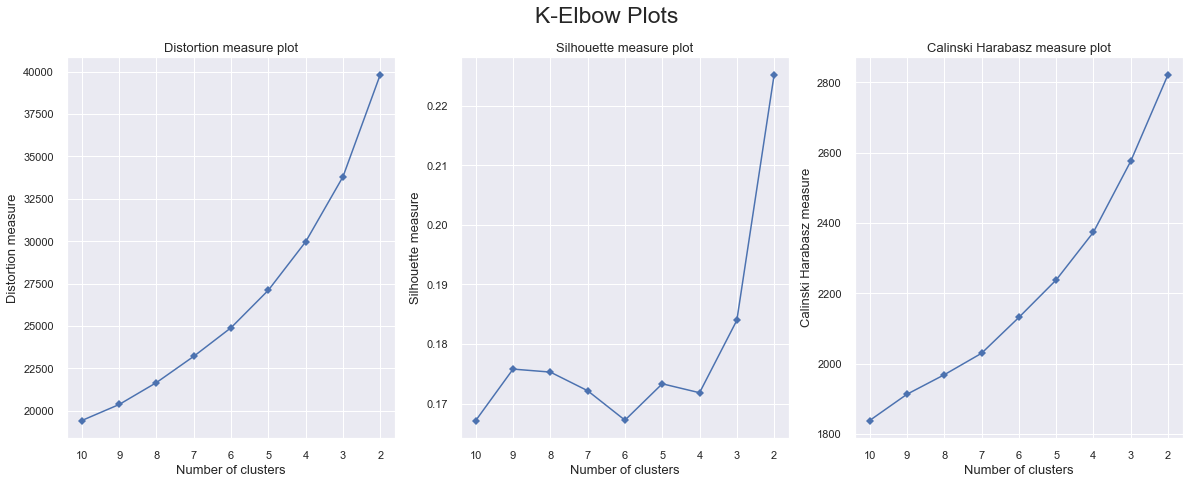

In [108]:
# Data for k-means: one-hot enconded categorical variables only need k-1 dummy variables to be represented, where k is the number of modalities of that variable.
# If we include all the k dummy variables of a given categorical variable, then we will have redundant information in our analysis.
kmeans_df = custom_std_ohe_df.drop(["PhD", "child_0", "canceled_1"], axis=1)
# K-Means clustering with sklearn
Kmeans = KMeans(random_state=0)
# K-elbow plots
kelbowplots(Kmeans, kmeans_df)

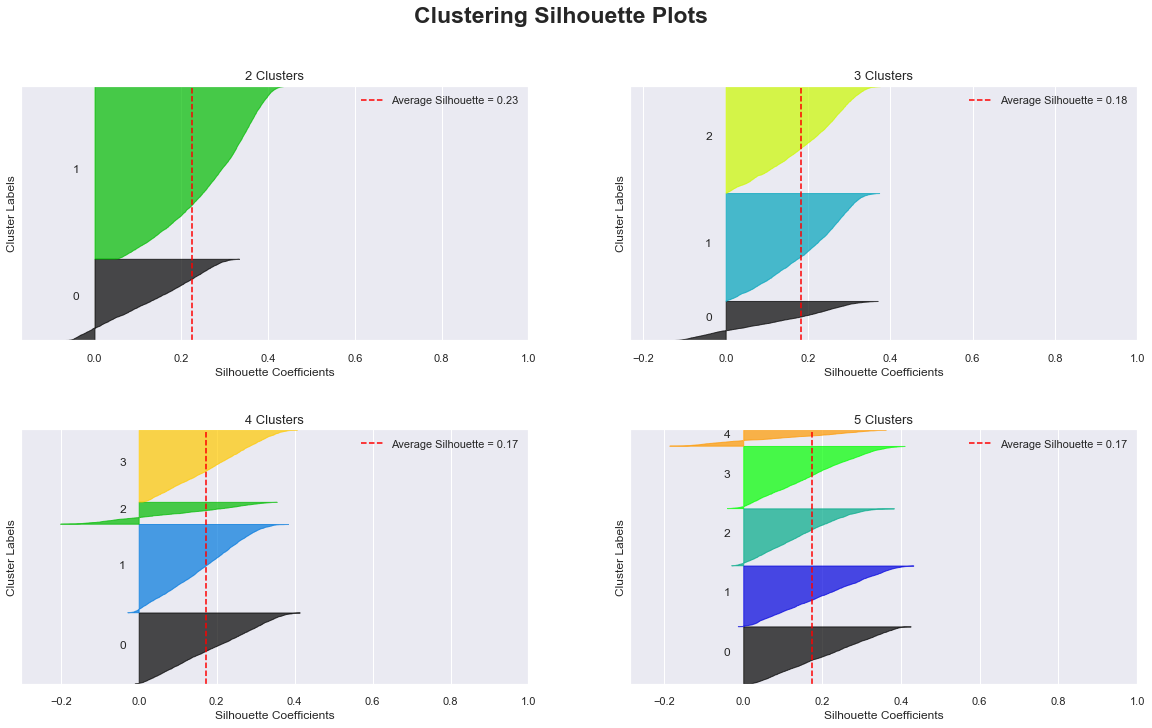

In [109]:
silhouette_analysis(kmeans_df, Kmeans, (2,2), (20, 11), 5)

From the silhouette analysis and elbow plots above there doesn't seem to appear an apparent choice regarding the number of cluster to retain, however we will opt to retain 3 clusters so that we have a terms of comparison with the K-prototypes clustering solution.

In [110]:
CLUSN = 3
# KMeans
Kmeans = KMeans(n_clusters=CLUSN, n_init=10, random_state=0)
km_labels = Kmeans.fit_predict(kmeans_df)

custom_std_ohe_df = pd.concat([custom_std_ohe_df, 
                               pd.Series(kp_labels, index=custom_std_df.index, name="labels_kproto"),
                               pd.Series(km_labels, index=kmeans_df.index, name="labels_kmeans")], axis=1)

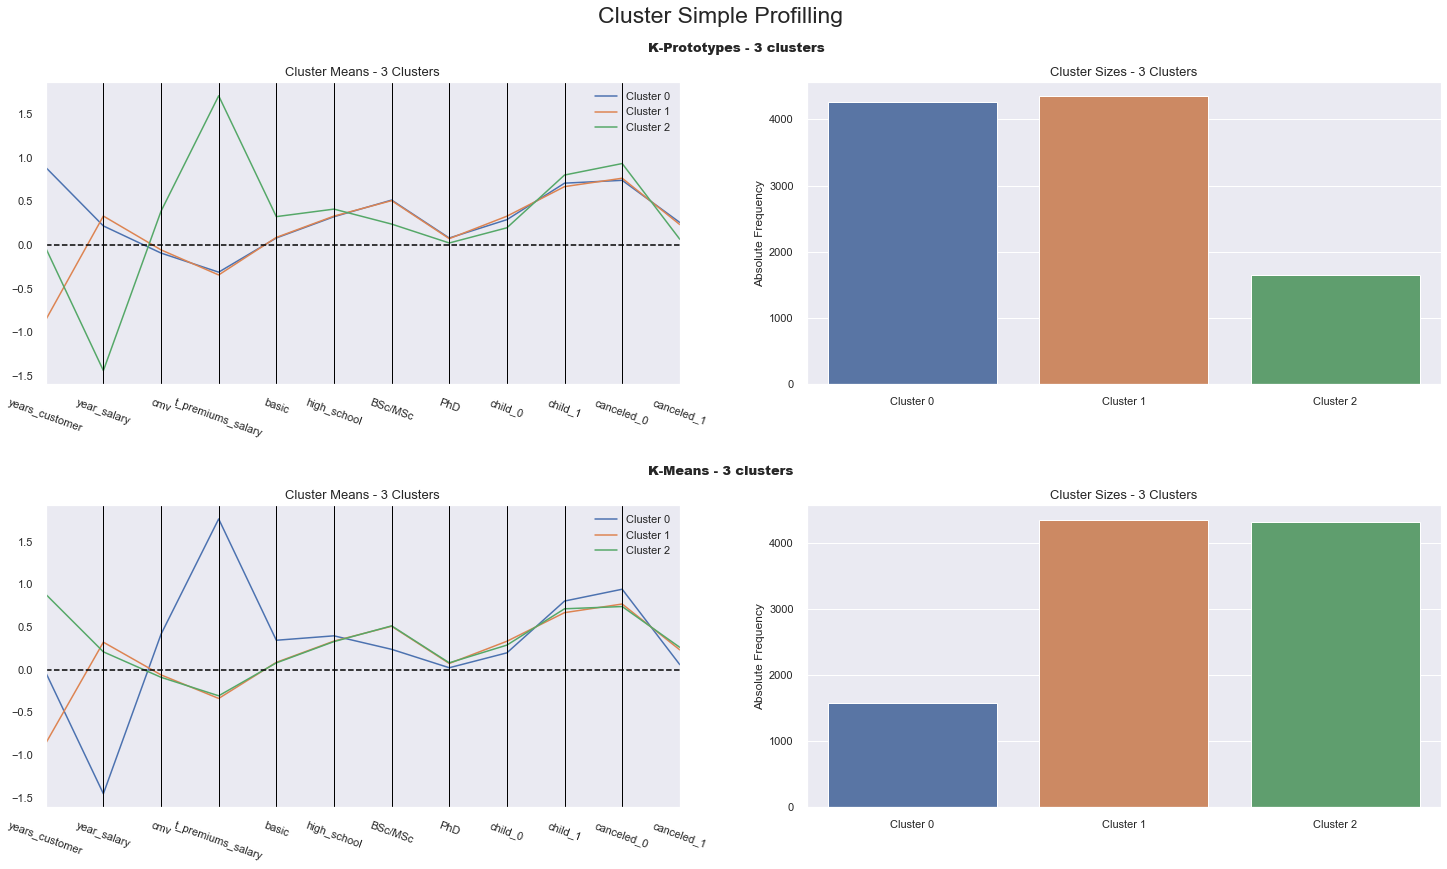

In [111]:
# Cluster Simple Profilling
cluster_profiles(custom_std_ohe_df, ["labels_kproto", "labels_kmeans"], (25,13), ["K-Prototypes - 3 clusters", "K-Means - 3 clusters"])

In [112]:
custom_std_ohe_df.pivot_table(aggfunc="count", values="cmv", index="labels_kproto", columns="labels_kmeans")

labels_kmeans     0     1     2
labels_kproto                  
0                 3     5  4248
1                 5  4310    29
2              1573    38    36

It is possible to see from the above profilling that both K-Means with one-hot encoded categorical variables and K-Prototypes produce fairly similar cluster solutions. This confirms the fact that despite the mathematical inadequacy, the K-Means algorithm yelds good results for mixed data type variables.

We will continue the analysis with the K-Prototypes clustering since this provides a more correct solution based on an appropriate dissimilarity measure for mixed data type variables. In order to characterize the cluster solution according to the categorical variables we will look at the associations between the clusters and each modality. For this reason, a multiple correspondence analysis (MCA) was performed to provide a visual representation (perceptual map) of the associations between the clusters and categorical varaibles' modalities. Bseides, a parallel coordinates plot will also be present to characterize the cluster according to the product variables.

In [113]:
# Appending the k-prototypes cluster label to the final df
final_df["cust_kproto_3cl"] = custom_std_ohe_df["labels_kproto"]

The Chi-square test of independence has a p-value of 0.00
The proportion of Inertia retained with 2 dimensions is 0.46


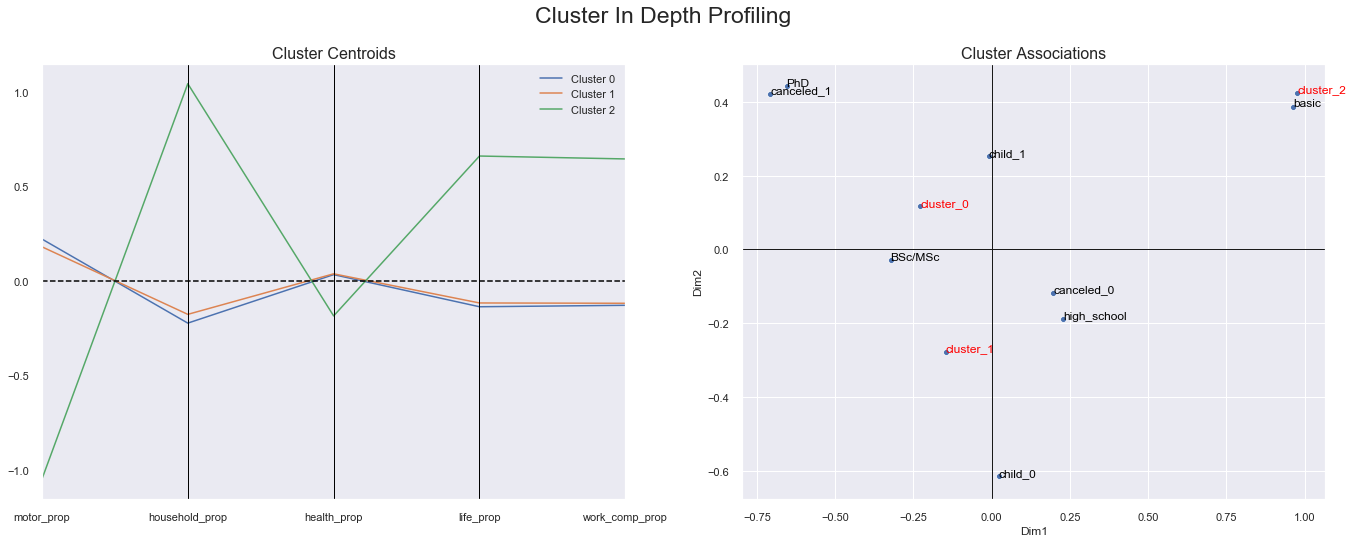

In [114]:
# Data - paralel coordinates
parallelc_df = final_df.drop(["educ_enc", "children", "motor", "household", "health", "life", "work_comp",
                              "annual_profit", "t_premiums", "basic", "high_school", "BSc/MSc", "PhD", 
                              "canceled", "child_0", "child_1", "canceled_0", "canceled_1", 
                              "prod_som_kmeans_4cl", "years_customer", "year_salary", "cmv", "claims_r",
                              "t_premiums_salary"], axis=1)

scaler = prep.StandardScaler()  # Standardizing the variables
parallelc_df = pd.DataFrame(np.append(scaler.fit_transform(parallelc_df.drop("cust_kproto_3cl", axis=1)),
                                                np.expand_dims(parallelc_df["cust_kproto_3cl"].values, axis=1), axis=1),
                                      index=parallelc_df.index, columns=parallelc_df.columns)

centroids = parallelc_df.groupby(by="cust_kproto_3cl", as_index=False).mean()

# Data - mca
ohe = prep.OneHotEncoder()  # One-hot encode cluster labels
cluster_labels = pd.DataFrame(ohe.fit_transform(final_df["cust_kproto_3cl"].values.reshape(-1,1)).toarray(),
                              index=final_df.index, columns=["cluster_0", "cluster_1", "cluster_2"])

mca_df = cluster_labels.merge(final_df.loc[:, ["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"]],
                              left_index=True, right_index=True)

row_scores, _ = correspondence_analysis(mca_df, mca=True)  # Correspondence Analysis - we only need either the row or column scores as rows and columns are the same in a Burt table
mca_cord = pd.DataFrame(row_scores, index=["cluster_0", "cluster_1", "cluster_2", "basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"],
                         columns=["Dim1", "Dim2"])
# Figure
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))

# Traces
pd.plotting.parallel_coordinates(centroids, "cust_kproto_3cl", color=sns.color_palette(), ax=ax1)
sns.scatterplot(x="Dim1", y="Dim2", data=mca_cord, ax=ax2)
for i in mca_cord.index:
    if "cluster" in i:
        ax2.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='red')
    else:
        ax2.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='black')

#Layout
handles, _ = ax1.get_legend_handles_labels()
cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
ax1.legend(handles, cluster_labels)
ax1.axhline(color="black", linestyle="--")
ax1.set_title("Cluster Centroids", fontsize=16)
ax2.axhline(y=0, color='k', linewidth=1)
ax2.axvline(x=0, color='k', linewidth=1)
ax2.set_title("Cluster Associations", fontsize=16)
plt.suptitle("Cluster In Depth Profiling", fontsize=23)

plt.show()

Above we can visualize the usual parallel coordinates plot for the metric variables that weren't used in the customer segmentation. Besides, a perceptual map of the correspondence analysis between the cluster labels and the categorical features presents a way to interpret the associations between each cluster and categorical variables' modalities. We can interpret the perceptual map by looking at the angles between vectors of each modality. If the angle is acute as for example in cluster_2 and basic, then there's positive association. An obtuse angle indicates negative association and a right angle indicates no association.

From the previous analysis and visualizations we can extract some relevant information regarding each cluster. Following, we characterize and attribute a label to each cluster:

* **Cluster_0 - Old Customers**: The main characteristic of this cluster is their high years_customer, which indicates that they are with the company for many years. Besides they reveal an average behaviour in every product variable and an high positive association with higher education and cancelation rate. Their relative size is around 4000 customers;

* **Cluster_1 - New Customers**: This cluster’s main characteristic is their low years_customer, indicating that they are relatively recent customers. This segment is very similar in terms of product consumption to the Old Customers cluster, having an average behaviour in every LOB. Besides, they also have a slightly higher income than the Old Customers cluster. From the correspondence analysis we see an high association with having no children. This is the biggest segment with around 4500 clients;

* **Cluster_2 - Valuable Customers**: The main characteristics of this cluster is their low yearly salary and high proportion of salary spent in the company. This makes them the cluster with the highest customer monetary value. Further analysis reveals that they don't invest in motor and spend their money mainly on household, life and work_comp. Regarding the categorical variables, they are positively associated with basic education. his is the smallest cluster with roughly 1700 clients.

Regarding the results we obtained from the Customer Segmentation, we believe that there isn't a lot of discrimination between clusters, mainly between Old Customer and New Customers. This can be a consequence of the data, suggesting that the main dimension of customer differentiation is the product consumption and not the socio-economic aspect.

Furthermore, we can make an association between the cluster Valuable Customers from this segmentation and the cluster High Life and Work Compensation Spenders from the product segmentation, as they both have low year_salary, high t_premiums_salary and spend a lot in the life and work_comp LOBs.

In the next section we will extract some conclusions from the segmentations made and we will try to combine all the information available into a single set of clusters.

## 4.5: Segmentation Conclusion
In this section we will gather all the findings that we obtained both from the 3 segmentations we produced. We will try to combine these findings and make summary of the conclusions made so far.

In [115]:
# First we need to append the results of the complete data segmentation in the final df
final_df["comp_kmeans_3cl"] = comp_complete_std_df["kmeans_labels"]
final_df = final_df.astype({"prod_som_kmeans_4cl": object, "cust_kproto_3cl": object, "comp_kmeans_3cl": object})

The Chi-square test of independence has a p-value of 0.00
The proportion of Inertia retained with 2 dimensions is 0.76


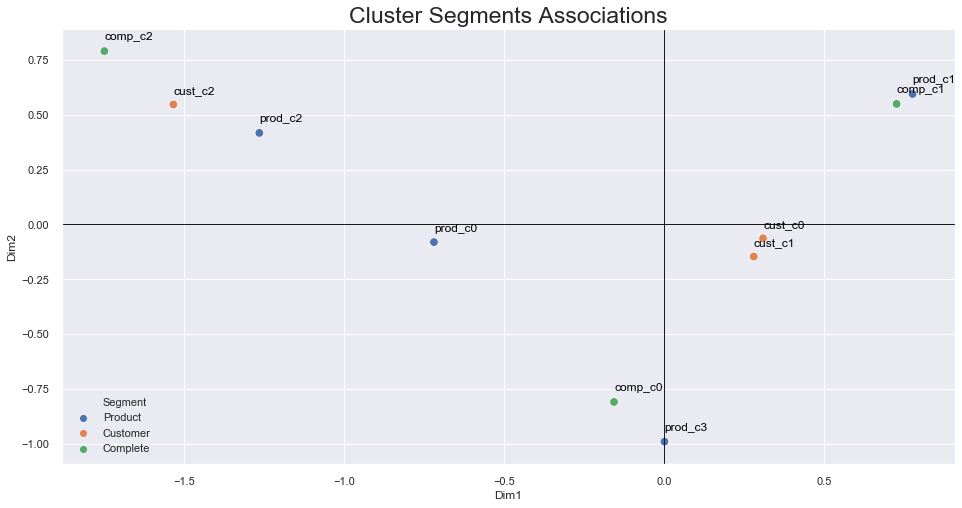

In [116]:
# Data - mca
ohe = prep.OneHotEncoder()  # One-hot encode cluster labels
mca_df = pd.DataFrame(ohe.fit_transform(final_df.loc[:, ["prod_som_kmeans_4cl", "cust_kproto_3cl", "comp_kmeans_3cl"]]).toarray(),
                              index=final_df.index, columns=["prod_c0", "prod_c1", "prod_c2", "prod_c3", "cust_c0", "cust_c1", 
                                                             "cust_c2", "comp_c0", "comp_c1", "comp_c2"])

row_scores, _ = correspondence_analysis(mca_df, mca=True)  # Correspondence Analysis - we only need either the row or column scores as rows and columns are the same in a Burt table
mca_cord = pd.DataFrame(row_scores, index=mca_df.columns, columns=["Dim1", "Dim2"])
mca_cord["Segment"] = ["Product"]*4 + ["Customer"]*3 + ["Complete"]*3 # Appending column with segmentation information

# Figure
sns.set()
fig, ax = plt.subplots(figsize=(16, 8))

# Traces
sns.scatterplot(x="Dim1", y="Dim2", hue="Segment", data=mca_cord, s=75, ax=ax)
for i in mca_cord.index:
    ax.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"]+0.05, i, horizontalalignment='left', size='medium', color='black')

#Layout
ax.axhline(y=0, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.set_title("Cluster Segments Associations", fontsize=23)

plt.show()

From the above visualization we can see how the clusters in each segmentation are related. 

At the top left corner we have the clusters with the highest customer monetary value which are characterized by having the lowest year_salary, highest t_premiums_salary, highest household_prop, highest life_prop and highest work_comp_prop. Besides, these customers are associated with basic level of education. These clusters are all positively associated and this seems to be the segment that persists the most across segmentations. 

Then we have the associated clusters at the top right corner which are the ones that spend the smallest proportion of their salary in the company. They are also motor LOB consumers and don't invest in any other LOB. Besides, they are associated with PhD level of education and high cancelation of premiums.

Finally, at the bottom of the graphic, we have the associated clusters with the lowest customer monetary value. These clusters are characterized by having the highest income, investing low in motor and high in health.

In [117]:
final_df.pivot_table(aggfunc="count", values="cmv", index="prod_som_kmeans_4cl", columns="cust_kproto_3cl") #comp_kmeans_3cl

cust_kproto_3cl         0     1    2
prod_som_kmeans_4cl                 
0.0                   678   728  691
1.0                  1985  1966   99
2.0                   337   386  568
3.0                  1256  1264  289

### 4.5.1 - Clusters Concatenation
**What if we want to have a single set of clusters for the entire customer population?** This is the question that we will be answering in this section.

We will merge the clusters of Product and Customer segmentation using a simple Hierarchical clustering. The objective is to define a set of cluster that we can use to provide the marketing strategies and don't worry much about the clusters from each segmentation, except in more specific situations.

In [118]:
# Adding column with concatenated labels of product and customer segmentation
final_df["concat_cl"] = final_df.loc[:, ["prod_som_kmeans_4cl", "cust_kproto_3cl"]].apply(lambda x: "_".join(map(str,x.to_list())), axis=1)

# Producing centroids to cluster clusters of 2 segmentations
concat_df = final_df.drop(['motor','household', 'health', 'life', 'work_comp', 'annual_profit', 't_premiums', 
                           "PhD", "child_0", "canceled_1"], axis=1).groupby(by="concat_cl").mean()
std = prep.StandardScaler()
concat_std_df = pd.DataFrame(std.fit_transform(concat_df), index=concat_df.index, columns=concat_df.columns)

In this section we will be working with the entire dataset and therefore we needed to one hot encode the categorical features. Also, in the previous cell we grouped the entire dataset by the unique combinations of cluster labels of both Customer and Product Segmentation, using the mean. Since the mean of the binary variables is a proportion, we didn't had any problems in using the euclidean distance together with the HC.

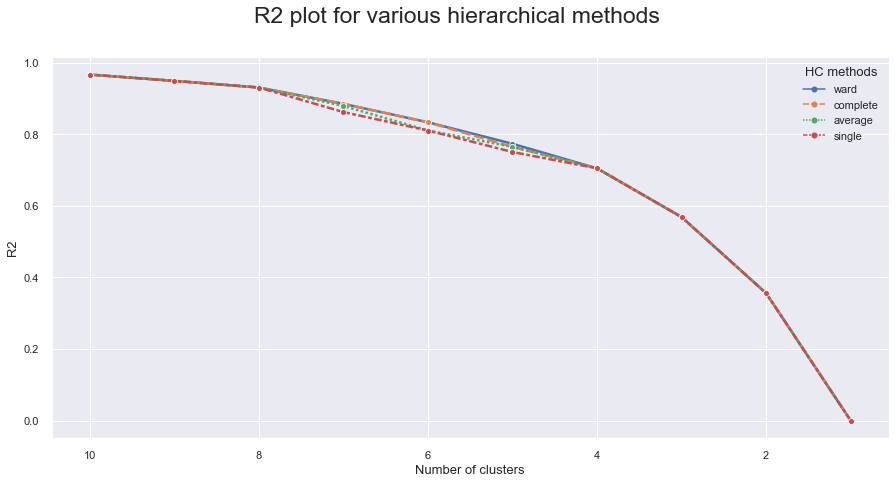

In [119]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=concat_std_df, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

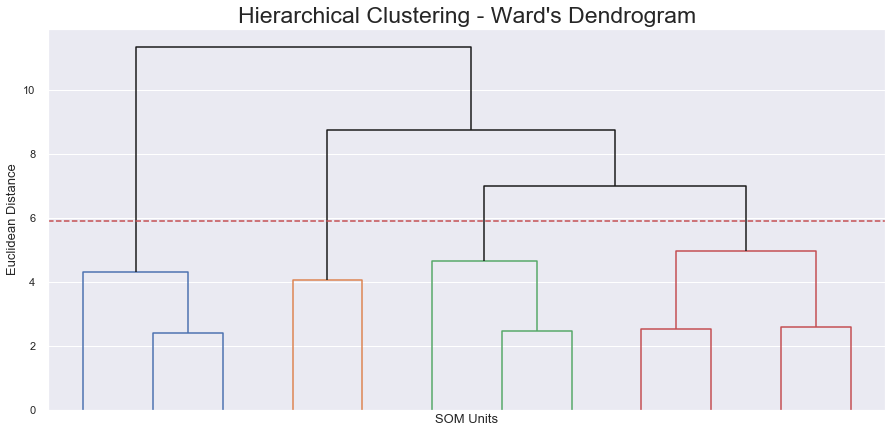

In [120]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(concat_std_df, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=6, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(5.9, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

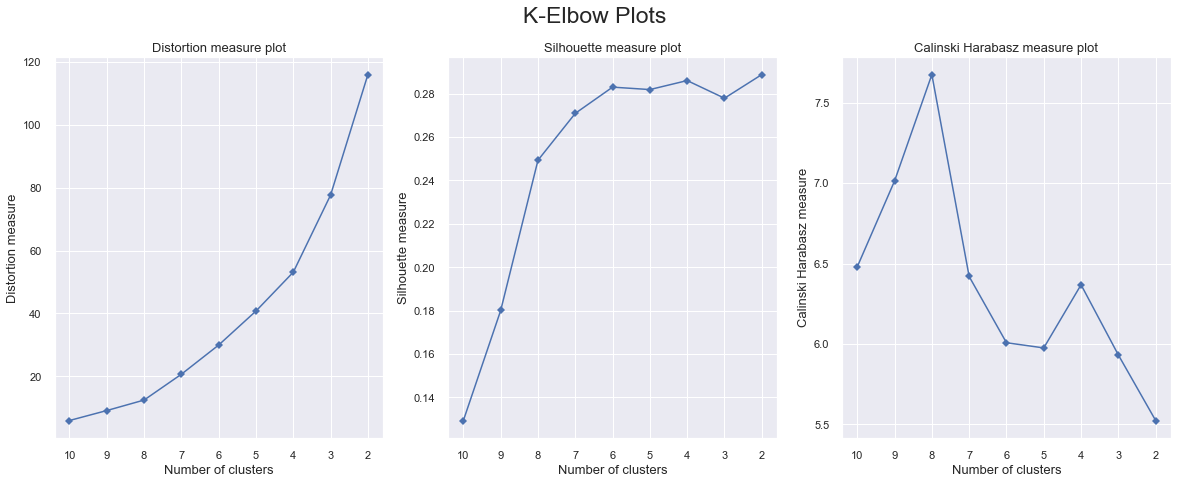

In [121]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Hclustering = AgglomerativeClustering(linkage=HCM)
# K-elbow plots
kelbowplots(Hclustering, concat_std_df)

From the above analysis we decided to use the Ward's method since they all perform similarly (R2 plot), we also decided to retain 4 clusters because there's an elbow at the 4 clusters solution in the R2 plot, in all the Elbow plots and there's also a big jump before merging the red and green clusters in the Dendrogram.

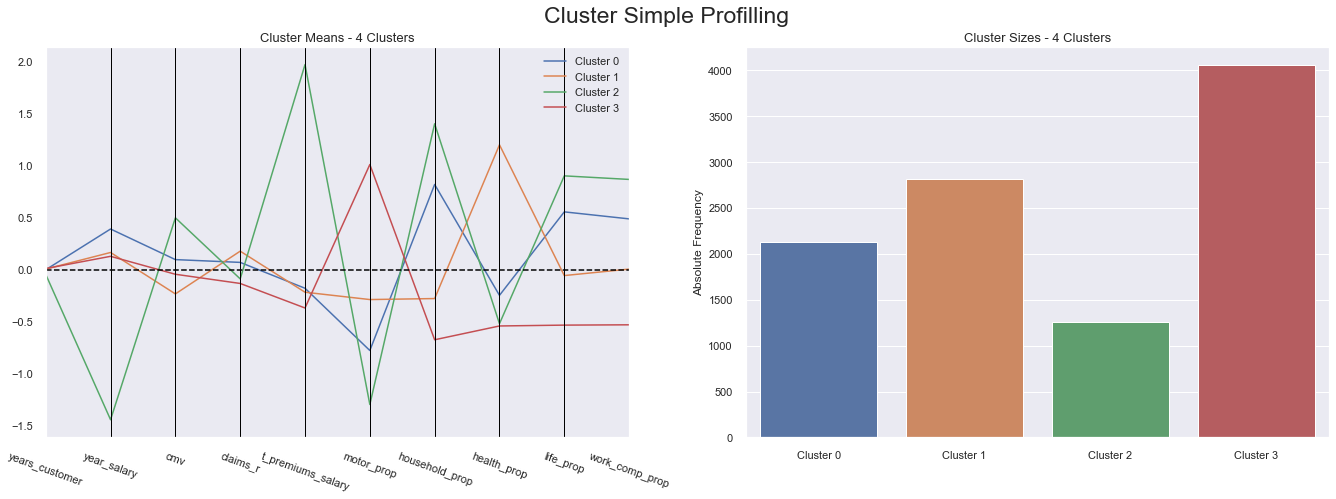

In [122]:
# Defining numbers of clusters
CLUSN = 4

# Hierarchical Clustering with sklearn
estimator = AgglomerativeClustering(n_clusters=CLUSN, linkage=HCM)
labels = estimator.fit_predict(concat_std_df)

# Getting the HC labels for each SOM Unit
concat_final_df = pd.DataFrame(np.concatenate((concat_std_df.values, np.expand_dims(labels,1)), axis=1), 
                               index=concat_std_df.index, columns=np.append(concat_std_df.columns,["labels_hc_concat"]))

# Getting the HC labels for each observation in the final_df
final_df = final_df.merge(right=concat_final_df.loc[:,"labels_hc_concat"], 
                                           left_on="concat_cl", right_index=True).sort_index()

# Dropping concat_cl as it is not useful anymore
final_df.drop("concat_cl", axis=1, inplace=True)

# Cluster Simple Profilling
parallel_c = final_df.loc[:, ["years_customer", "year_salary", "cmv", "claims_r", "t_premiums_salary", "motor_prop", 
                              "household_prop", "health_prop", "life_prop", "work_comp_prop", "labels_hc_concat"]]

std = prep.StandardScaler()
parallel_c = pd.DataFrame(np.concatenate((std.fit_transform(parallel_c.drop("labels_hc_concat", axis=1)),
                                          np.expand_dims(parallel_c["labels_hc_concat"].values, axis=1)), axis=1),
                          index=parallel_c.index, columns=parallel_c.columns)

cluster_profiles(parallel_c, ["labels_hc_concat"], (23, 7))

The Chi-square test of independence has a p-value of 0.00
The proportion of Inertia retained with 2 dimensions is 0.52


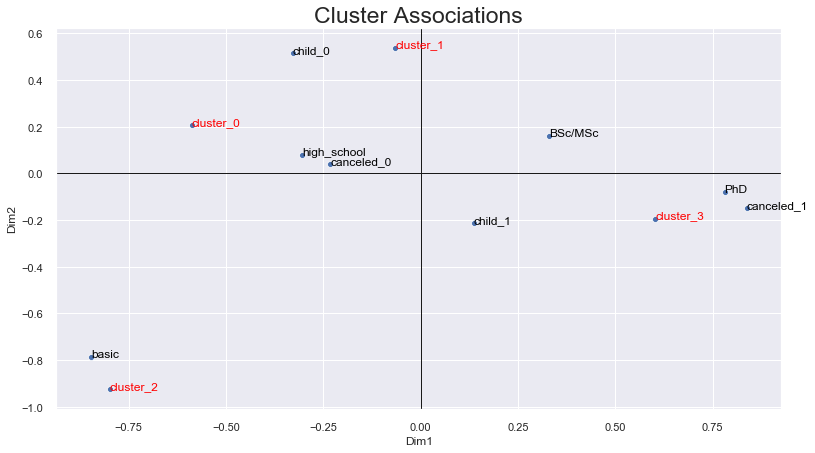

In [123]:
# Data - mca
mca_df = final_df.loc[:, ["labels_hc_concat", "basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"]]
ohe = prep.OneHotEncoder()  # One-hot encode cluster labels
cluster_labels = pd.DataFrame(ohe.fit_transform(mca_df["labels_hc_concat"].values.reshape(-1,1)).toarray(),
                              index=mca_df.index, columns=["cluster_0", "cluster_1", "cluster_2", "cluster_3"])

mca_df = cluster_labels.merge(mca_df.loc[:, ["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"]],
                              left_index=True, right_index=True)

row_scores, _ = correspondence_analysis(mca_df, mca=True)  # Correspondence Analysis - we only need either the row or column scores as rows and columns are the same in a Burt table
mca_cord = pd.DataFrame(row_scores, index=["cluster_0", "cluster_1", "cluster_2", "cluster_3", "basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"],
                         columns=["Dim1", "Dim2"])
# Figure
sns.set()
fig, ax = plt.subplots(figsize=(13, 7))

# Traces
sns.scatterplot(x="Dim1", y="Dim2", data=mca_cord, ax=ax)
for i in mca_cord.index:
    if "cluster" in i:
        ax.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='red')
    else:
        ax.text(mca_cord.loc[i, "Dim1"], mca_cord.loc[i, "Dim2"], i, horizontalalignment='left', size='medium', color='black')

#Layout
ax.axhline(y=0, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.set_title("Cluster Associations", fontsize=23)

plt.show()

After concatenating the clusters from Customer and Product segmentation using HC, we will do an in depth profiling of the concatenated clusters.

Following, we characterize and attribute a label to each cluster:

* **Cluster_0 - Diverse and Potential**: This clusters is characterized by its higher consumption of household, life and work_comp, while having a low consumption of motor. They are also the cluster with the highest income and have an above average customer monetary value. From the correspondence analysis we conclude that this customers are negatively associated with cancelation and higher levels of education. This cluster is composed of around 2000 customers;

* **Cluster_1 - Health**: This cluster’s main characteristic is the high proportion of spending in health. The remaining behaviours don't stand out much, however they are the cluster with the lowest customer monetary value and the highest claims rate. They also seem to be positively associated with not having children. Finally, this cluster is composed of roughly 2800 customers.

* **Cluster_2 - Diverse and Valuable**: This is the smallest cluster with around 1250 customers. Nevertheless, they are the most important in terms of customer monetary value with an average around 0.5 standard deviations above the mean. They are also the customers that earn less on average, however they are the ones that spend the highest proportion of their salary in the company. Besides, they are characterized by having an extremely low proportion of spendings in motor and an extremely high in household. Also they have a fairly high proportion of spending in life and work compensation. It can be said that this cluster has a similar product consumption behaviour to Cluster_0. Finally, they are highly positively associated with basic level of education.

* **Cluster_3 - Motor**: The main characteristic of this cluster is the high proportion of spending in motor and low proportion of spending in every single other LOB. Besides they are the customer with the lowest claims rate and proportion of salary spent in the company. They are the biggest cluster with roughly 4000 customers and they are positively associated with high levels of education and cancelation of contracts.

# 5) Classification of Outliers
Even though we believe some of the outliers we spotted previously can be truly aberrant observations, we will proceed to classify them according to the final concatenated cluster. For this task we will resort to a simple decision tree which allows us to easily classify the outliers.

This classifier will also provide a useful tool for the future, as a set of rules can be extracted that helps understand why customers belong to a certain cluster. With this information, we can easily classify future customers by making simple queries to the database. This will allow a more personalized service to each future customer which can be dynamically adapted (a customer can belong to different clusters across time).

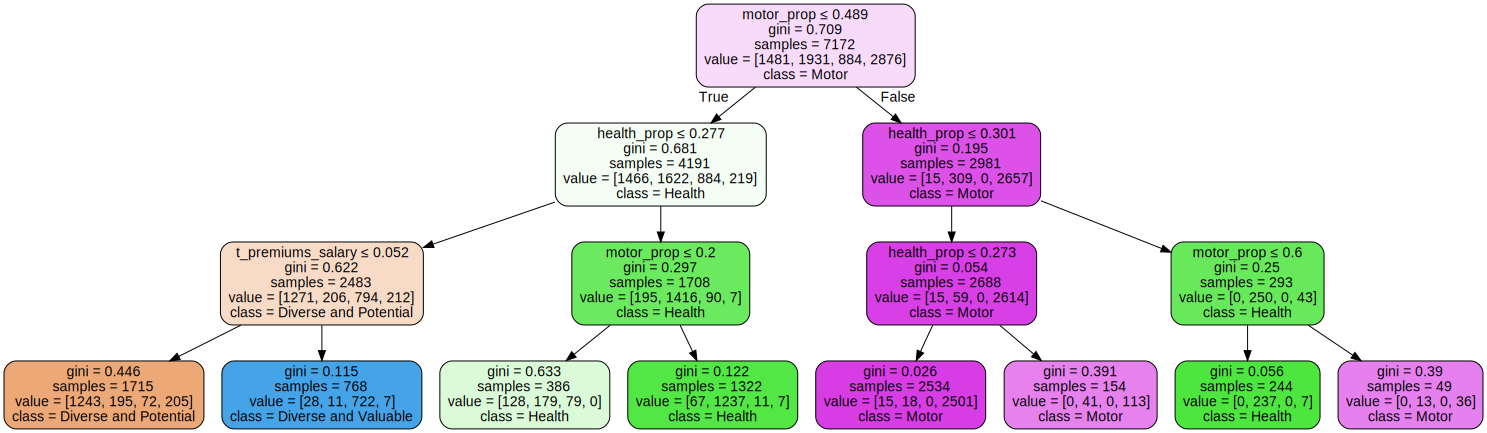

In [124]:
# Dependent and Independent Variable
X = final_df.drop(['educ_enc', 'children', 'motor', 'household', 'health', 'life', 'work_comp', 'annual_profit', 't_premiums', 
                   'canceled', 'prod_som_kmeans_4cl', 'cust_kproto_3cl', 'comp_kmeans_3cl', 'labels_hc_concat'], axis=1)
y =  final_df.loc[:, 'labels_hc_concat'] # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns.to_list(),
                           class_names=["Diverse and Potential", "Health", "Diverse and Valuable", "Motor"],
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)
# fig, ax = plt.subplots(figsize=(20, 10))
# plot_tree(clf, filled=True, ax=ax)
# plt.savefig("fig.png")

Above we can visualize the fitted decision tree. Our procedure was to start with a low depth, in this case 3, and then progress to higher depths in case we weren't able to produce a good classifier.

It turns out that with a simple decision tree with a depth of 3 levels, we are able to predict the test observations with an accuracy of around 86%, as seen below. We consider these results quite satisfactory and we will proceed with this fitted tree, as we have experimented with higher depths and the marginal increase in accuracy wasn't significant. Besides, by increasing the complexity of the tree we would be in risk of overfitting the data. Of course this could have been avoided by utilizing a cross-validation approach, however the purpose of the project isn't to produce the best classifier and we wanted to keep things simple.

In [125]:
# Test accuracy
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(clf.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 86.11% of the customers correctly


In [126]:
# Predicting cluster membership of outlier observations
ohe = prep.OneHotEncoder()
ohe_cat_vars = pd.DataFrame(ohe.fit_transform(df_out.loc[:, ["educ_enc", "children", "canceled"]]).toarray(),
                            columns=["basic", "high_school", "BSc/MSc", "PhD", "child_0", "child_1", "canceled_0", "canceled_1"],
                            index=df_out.index)
df_out_pred = df_out.loc[:, ["years_customer", "year_salary", "cmv", "claims_r", "t_premiums_salary", "motor_prop",
                             "household_prop", "health_prop", "life_prop", "work_comp_prop"]].merge(ohe_cat_vars, left_index=True, right_index=True)

labels_out = clf.predict(df_out_pred) # predicting to which cluster each outlier belongs

df_out["cluster_label"] = labels_out
df_out.head()

years_customer educ_enc  year_salary  children         cmv  claims_r  \
id                                                                          
52             34.0        3      38808.0       1.0   -14714.08     25.36   
113            19.0        4      28248.0       1.0    -8719.04     15.65   
136            19.0        3      26112.0       1.0   -10198.91     14.80   
150            27.0        1      11808.0       1.0      255.71      0.63   
172            26.0        3      13032.0       1.0  -165680.42    256.20   

      motor  household  health    life  ...  annual_profit  t_premiums_salary  \
id                                      ...                                     
52   557.44      20.00   29.56    5.00  ...    -432.767059           0.015770   
113  518.32       4.45   55.90    3.89  ...    -458.896842           0.021009   
136  297.61     162.80  143.36  136.47  ...    -536.784737           0.028349   
150   64.90     197.25   29.56   18.56  ...       9.470741           0.064516   
172  378.07      78.90  166.81    6.89  ...   -6372.323846           0.049810   

     t_premiums  motor_prop  household_prop  health_prop  life_prop  \
id                                                                    
52       612.00    0.910850        0.032680     0.048301   0.008170   
113      593.45    0.873401        0.007499     0.094195   0.006555   
136      740.24    0.402045        0.219929     0.193667   0.184359   
150      761.80    0.085193        0.258926     0.038803   0.024363   
172      649.12    0.582435        0.121549     0.256979   0.010614   

     work_comp_prop  canceled cluster_label  
id                                           
52        -0.014706         1           3.0  
113        0.018350         0           3.0  
136       -0.004053         1           0.0  
150        0.592715         0           2.0  
172        0.028423         0           3.0  

[5 rows x 21 columns]

Besides the classification of the outliers, the decision tree classifier provides a set of simple rules that allow future customer classification into each cluster by performing some simple queries. Below, it is illustrated what are the questions necessary to classify a customer into each cluster:

* **Diverse and Potential**: If motor_prop ≤ 0.49 and health_prop ≤ 0.28 and t_premiums_salary ≤ 0.05, then the customer belongs to this cluster with a 73% probability;
* **Diverse and Valuable**: If motor_prop ≤ 0.49 and health_prop ≤ 0.28 and t_premiums_salary ≥ 0.05, then the customer belongs to this cluster with a 94% probability;
* **Health**: motor_prop ≤ 0.49 and health_prop ≥ 0.28 and motor_prop ≥ 0.2, then the customer belongs to this cluster with a 94% probability;
* **Motor**: motor_prop ≥ 0.49 and health_prop ≤ 0.3 and health_prop ≤ 0.27, then the customer belongs to this cluster with a 99% probability.

With this set of rules we can easily filter our database to classify customers that weren't present in the sample provided as well as future customers. It is possible to see that we only need to access the values of the motor_prop, health_prop and t_premiums_salary variables in order to classify the customers. This is also an indicative that the clusters ared defined mainly by these three variables. This matches the findings in the Customer segmentation that the variables used didn't provide a lot of discriminance.

# 6) Conclusion

In this work, a full end-to-end data mining project was performed. The data wasn’t provided in the best condition and therefore the first thing we had to do was to prepare the data for clustering. Coherence checks, outlier detection and missing value imputation were performed to make the data usable. In total, 48 observations were removed due to being outliers and around 400 missing values were imputed. Before proceeding to the cluster analysis, we also analyzed the importance of the non-metric variables as these are an obstacle to the common clustering techniques. We ended up excluding the area categorical variable, however, we also created 11 new features to help us discriminate between clusters.

We divided the clustering process into 3 segments: Overall, Customer and Product. Our intention was to use each segment to understand a specific customer behaviour. In these segments we utilize a wide range of techniques such as K-Means, SOM, HC, K-Protypes and GMM. Often, we used combinations of these techniques as well. To analyze each cluster, we used methods such as Silhouette analysis, K-elbow plots, R2 plots, Dendrograms, Correspondence Analysis, etc.

In order to reduce the number of clusters to consider, we proposed a final set of clusters by grouping the ones we had from Customer and Product segmentation with HC. Finally, we also employed a Decision Tree classifier to predict to which cluster the outliers belong, as well as to extract the set of rules that helps us understand why each customer belongs to each cluster.

# 7) References

* Outlier detection: https://scikit-learn.org/stable/modules/outlier_detection.html, https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py, https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html, https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate, Applied Multivariate Statistical Analysis, Johnson & Wichern
* Missing values: https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py, https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute
* Categorical variables: https://seaborn.pydata.org/examples/pointplot_anova.html, https://seaborn.pydata.org/examples/paired_pointplots.html
* GMM: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html, https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
* SOM: https://github.com/sevamoo/sompy, https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11#file-basic_exaples_20160908-ipynb, http://www.cis.hut.fi/projects/somtoolbox/package/docs2/somtoolbox.html
* Cluster evaluation: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster, https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation, https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html, https://www.scikit-yb.org/en/latest/api/cluster/elbow.html, https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#
* Cluster profiling: https://www.scikit-yb.org/en/latest/api/features/pcoords.html
* k-means: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans, https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py
* K-Prototypes: "Extensions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Values", Zhexue Huang, 1998, https://cran.r-project.org/web/packages/clustMixType/index.html
* Correspondence analsys: "An Introduction to Correspondence Analysis", Phillip M. Yelland, https://codefying.com/2018/12/21/introduction-to-correspondence-analysis/, https://www.displayr.com/normalization-correspondence-analysis/, https://www.displayr.com/math-correspondence-analysis/
* Decision trees: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning, https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier